## Analyze TMAs <a name="intro"></a> 

[contents](#contents)

**Samples:** 
- JP-TMA-1 (survival data and patient characteristics: age, stage, tumor size)
- JP-TMA-2 (mostly TNBC; only 2 ER+, survival data, some neoadjuvant)
- IMC Basel TMA (survival data and patient characteristics)
- IMC Zurich TMA (no survival data)
- MIBI TMA (TNBC only, survival data)

** note **

Use only IMC images thats pass QC on ER staining.

**Analysis**: 

- Mean cell fraction in tissue versus clinical outcome
- Heiarchical clustering of patient tissues based on stromal and epithelial cell types
- Correlation of stromal and epithelial cell types and subtypes
- Comparison of immune cell types, fuctional status and clustering in high proliferation versus low proliferation tissues
- Co-expression of functional markers (Patwa et al Comm Biol 2021)

**Spatial  metrics**: 

Process counted cells with their XY coordinates in 20-40 microns radius from a single cell, then run the following: 
1.   Number of neighbors of pairs of cells (**Janiszewska et al.  JCI Insight, 2021**)
   2. Mixing score (**Keren et al. Cell 2018**)
3. Lymphocyte Clusters (**Wortman et al. npj Breast Cancer 2021**)
4.   Homotypic and heterotypic interactions (**Ali et al. Nat Cancer 2020**)

Additional spatial analyses

1. Ripley’s L (a density normalized measure of clustering) (**spatstat**)
2. Multitype K function (Kcross; a density normalized measure of two celltypes’ co-localization) (**spatstat**)
3. Multitype G function (G cross; a measure of two celltypes’ co-localization) (**spatstat**)
4. Spatial LDA Latent Dirichlet Allocation; (**Chen et al. J Comput Biol. 2020**), followed by kmeans clustering
5. K means clustering of neighborhood counts (control for Chen et al. J Comput Biol. 2020)
6. Voronoi interactions (**Patwa et al Comm Biol 2021**)



# create environment

After installing python3/miniconda, enter the following in the terminal to set up an `analysis` environment. 

`conda create -n analysis`

`conda activate analysis`

`conda install seaborn scikit-learn statsmodels numba pytables pandas ipykernel`

`conda install -c conda-forge jupyterlab matplotlib python-igraph leidenalg scikit-image opencv tifffile libpysal shapely lifelines umap-learn napari scanpy statsmodels`

`conda install -c anaconda psutil pysal pillow`

`conda install -c bioconda anndata`

`pip install DeepCell`

`git clone https://gitlab.com/engje/mplex_image.git`



In [1]:
#load libraries

import os
import itertools
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import math
import warnings
import importlib

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, gridspec
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
mpl.rc('figure', max_open_warning = 0)

import sklearn
from sklearn.preprocessing import minmax_scale, scale, FunctionTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import lifelines
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import multivariate_logrank_test
from lifelines import exceptions
warnings.filterwarnings("ignore",category = exceptions.ApproximationWarning)

import scipy
from scipy import stats
from scipy.stats import entropy, norm
from scipy.spatial import cKDTree
from scipy.stats import pearsonr

import statsmodels
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm


import anndata
from anndata import AnnData

import util
import plotting

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [2]:
#original paths
#update codedir to reflect to path where you have your code
codedir = os.getcwd() #'/home/groups/graylab_share/Chin_Lab/ChinData/engje/Data/20200000/20200406_JP-TMAs'  

#load mplex_imge: you will change this to location of mplex_image repo
#os.chdir('/home/groups/graylab_share/Chin_Lab/ChinData/engje/Data')
#os.chdir('..')
#from mplex_image import visualize as viz, process, preprocess, normalize, mics, mpimage
#from spatial import spatial
np.random.seed(912)

#download data from synapse.org and place in folder called "data"
# https://www.synapse.org/#!Synapse:syn50134757/. (Free account required).
datadir = f'{codedir}/data'
s_date = '20240904'#
os.chdir(codedir)
try:
    if not os.path.exists(s_date):
        os.mkdir(s_date)
        os.mkdir(f'{s_date}/Survival_Plots')
        os.mkdir(f'{s_date}/Survival_Plots_Both')
    b_binder=False
except:
    print('binder')
    b_binder=True
%matplotlib inline

# Table of contents <a name="contents"></a>
0. [Intro](#intro)
1. [functions](#func)
2. [Load annotation](#loadold)
3. [Load cell types and name](#cluster)
4. [Tissue means](#tissue)
5. [Single variable survival](#surv) [Spatial LDA survival](#clin)
6. [Multivariable Subtyping](#subtIMC) [1 Platforms together (epithelial)](#st1) [2 Platforms separate (stromal)](#st2)  
7. [Tissue correlation (Pearson & chi square)](#st3) [Spatial LDA correlation and survival](#lda_corr) [Figure 5 scatterplots](#lda_scatter)
8. [Categorical Regression](#st4) [Neoadjuvant](#neoadj) 8a. [ER+ vs endothelial](#slide15) [TNBC, ER+ high low prolif](#byimmune)
8. [Mixing score vs survival](#n1) 
9. [Boxplots Kmeans Neighborhoods](#leidneigh)  [Survival](#leidneighsurv)
10. [Immune phenotype of proliferating tumors](#imph)  11a. [Tumor phenotype of tumor subtypes (CD44)](#imphCD44)
11. [Immune spatial distribution](#imm_sp)  
12. [Neighborhoods](#nbrhood)    [Lymphocyte Clusters](#agg)    [Ripleys K](#kest)    [Kcross](#kcross)     [Occupancy](#nolan)        [G cross](#gcross)
12. [Correlation of spatial metrics](#metric)
13. [**Immunoregulatory**](#sqpy)
14. [**MIBI vs cycIF**](#mibivs)
12. [Old](#dist)



## functions <a name="func"></a> 


[contents](#contents)

In [6]:
#functions
from scipy.spatial import Delaunay, delaunay_plot_2d, Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image, ImageDraw
import seaborn
from itertools import combinations
from itertools import product

#from patwa et al

def create_voronoi(centdf): #returns the Voronoi diagram object
    vor = Voronoi(np.c_[centdf.column.values, centdf.row.values])
    return vor
def plot_voronoi(vor, identifier): #Void - just plots the graph
    fig, ax = plt.subplots(figsize=(16, 16))

    fig = voronoi_plot_2d(vor, ax, show_vertices=False, line_colors='blue', 
                      line_width=2, point_size=2)
    ax.set_xlim([0, 2048])
    ax.set_ylim([2048, 0])
    plt.axis("off")
    plt.tight_layout()
    plt.savefig("/Users/aalokpatwa/Desktop/MIBI/voronoi/voronoi_plotsv2/" + identifier + ".pdf", dpi=300)
    plt.close()
    #plt.show()

def make_voronoi_dataframe(voronoi, centroiddf):
    count_skipped = 0
    number_centroids = voronoi.points.shape[0]
    information_list = []
    for centroid in range(number_centroids):
        centroid_list = []
        centroid_y = voronoi.points[centroid][0]
        centroid_x = voronoi.points[centroid][1]
        centroid_list.append(centroid)
        centroid_list.append((centroid_x, centroid_y))
        region_index = voronoi.point_region[centroid]
        centroid_list.append(region_index)
        vertices = voronoi.regions[region_index]
        if -1 in vertices:
            count_skipped += 1
            continue
        else:
            vertex_list = []
            for vertex in vertices:
                y_coord = int(round(voronoi.vertices[vertex][0]))
                x_coord = int(round(voronoi.vertices[vertex][1]))
                vertex_list.append((y_coord, x_coord))
            centroid_list.append(vertex_list)
        centroid_list.append(centroiddf.at[centroid, "celltype"])
        information_list.append(centroid_list)       
    infodf = pd.DataFrame(information_list, columns=["CentroidIndex","CentroidCoord", "RegionIndex",
                                                     "Vertices", "Celltype"])
    return infodf, count_skipped

def extract_current_mask(vertexlist):
    img = Image.new("L", (2048,2048), 0)
    ImageDraw.Draw(img).polygon(vertexlist, fill=1)
    mask = np.array(img)
    binary_mask = np.where(mask==1)
    coordinates = list(zip(binary_mask[0], binary_mask[1]))
    return coordinates, len(coordinates)

def expression_within_cell(biomarker_image, pixellist, size):
    total_vector = np.zeros(44)
    for pixel in pixellist:
        expression_vector = biomarker_image[pixel[0], pixel[1]]
        total_vector += expression_vector
    total_vector = total_vector / size
    return total_vector

def create_multimarker_image(imagepath):
    biomarker_pil = Image.open(imagepath)
    n_frames = biomarker_pil.n_frames
    
    first_level = np.array(biomarker_pil, dtype="uint8")
    first_level = np.reshape(first_level, (2048,2048,1))
        
    combined_image = first_level
    
    for frame in range(1, n_frames):
        biomarker_pil.seek(frame)
        current_level = np.array(biomarker_pil, dtype="uint8").reshape((2048,2048,1))
        combined_image = np.concatenate((combined_image, current_level), axis=2)
    return combined_image

def create_neighbor_matrix(voronoi, voronoi_df):
    number_regions = len(voronoi_df.index)
    adjacency_list = []
    for region in range(number_regions):
        adjacency_list.append([])
    ridge_points = voronoi.ridge_points
    for edge in ridge_points:
        first_centroid = edge[0]
        second_centroid = edge[1]
        first_cell = voronoi_df[voronoi_df["CentroidIndex"] == first_centroid]
        second_cell = voronoi_df[voronoi_df["CentroidIndex"] == second_centroid]
        if (first_cell.empty or second_cell.empty):
            continue
        first_index = int(first_cell.index[0])
        second_index = int(second_cell.index[0])
        adjacency_list[first_index].append(second_centroid)
        adjacency_list[second_index].append(first_centroid)
    new_df = voronoi_df.copy()
    new_df["Adjacency"] = adjacency_list
    return new_df

# author: engjen
def pie_chart_labels(df):
    s_name = df.index.name
    labels = [f'{s_name} {item}' for item in df.index]
    percentages = [x for x in df.iloc[:,0]]
    linebreak = '\n'
    return [f'{p}{linebreak}{i} Pts.' for p,i in zip(labels,percentages)]

# Load annotation <a name="loadold"></a>

- patient
- clinical subtype
- clinical outcome

[contents](#contents)

In [7]:
#Cyclic patients and subtypes
df_cyc_sub = pd.read_csv(f'data/JP-TMAs_CoreID_Clinical-Subtype.csv',index_col=0)
#collapse Subtypes
d_replace = {'0':'other','?':'other', np.nan:'other'}
df_cyc_sub['ID'] = df_cyc_sub.ID.replace(d_replace)
df_cyc_sub.loc[df_cyc_sub.index.str.contains('JP-TMA2-1'),'Accession'] = df_cyc_sub.loc[df_cyc_sub.index.str.contains('JP-TMA2-1')].index
#add subtype and patient
d_cyc_sub = dict(zip(df_cyc_sub.index.tolist(),df_cyc_sub.ID.tolist()))
d_patient = dict(zip(df_cyc_sub.index,df_cyc_sub.Accession))
# JP-TMA2 subtypes
d_cyc_sub2 = {'JP-TMA2-1_scene01': 'TNBC', 'JP-TMA2-1_scene02': 'TNBC', 'JP-TMA2-1_scene03': 'TNBC', 'JP-TMA2-1_scene04': 'TNBC',
 'JP-TMA2-1_scene05': 'TNBC', 'JP-TMA2-1_scene06': 'TNBC', 'JP-TMA2-1_scene07': 'TNBC', 'JP-TMA2-1_scene08': 'ER+HER2+',
 'JP-TMA2-1_scene09': 'TNBC', 'JP-TMA2-1_scene10': 'TNBC', 'JP-TMA2-1_scene11': 'TNBC', 'JP-TMA2-1_scene12': 'TNBC',
 'JP-TMA2-1_scene13': 'TNBC', 'JP-TMA2-1_scene14': 'TNBC', 'JP-TMA2-1_scene15': 'TNBC', 'JP-TMA2-1_scene16': 'TNBC',
 'JP-TMA2-1_scene17': 'TNBC', 'JP-TMA2-1_scene18': 'TNBC', 'JP-TMA2-1_scene19': 'TNBC', 'JP-TMA2-1_scene20': 'TNBC',
 'JP-TMA2-1_scene21': 'TNBC', 'JP-TMA2-1_scene22': 'TNBC', 'JP-TMA2-1_scene23': 'TNBC', 'JP-TMA2-1_scene24': 'TNBC',
 'JP-TMA2-1_scene25': 'TNBC', 'JP-TMA2-1_scene26': 'TNBC', 'JP-TMA2-1_scene27': 'TNBC', 'JP-TMA2-1_scene28': 'TNBC',
 'JP-TMA2-1_scene29': 'TNBC', 'JP-TMA2-1_scene30': 'TNBC', 'JP-TMA2-1_scene31': 'TNBC', 'JP-TMA2-1_scene32': 'TNBC',
 'JP-TMA2-1_scene33': 'TNBC', 'JP-TMA2-1_scene34': 'TNBC', 'JP-TMA2-1_scene35': 'TNBC', 'JP-TMA2-1_scene36': 'TNBC',
 'JP-TMA2-1_scene37': 'TNBC', 'JP-TMA2-1_scene38': 'TNBC', 'JP-TMA2-1_scene39': 'TNBC', 'JP-TMA2-1_scene40': 'TNBC',
 'JP-TMA2-1_scene41': 'TNBC', 'JP-TMA2-1_scene42': 'TNBC',} #'HR+HER2+'


In [ ]:
# data wrangling from various sources (already done)
# #survival
# df_surv_cyc = pd.read_csv(f'{codedir}/data/cycIF_clinical_outcome.csv',index_col=0)
# df_surv_cyc['Platform'] = 'cycIF'
# df_surv_cyc.rename({'Recurence_time':'Recurrence_time'},axis=1,inplace=True)

# # clinical variables
# df_cyc_a = pd.read_csv('annotation/JP-TMAs_Clinical_Variables.csv',index_col=0)

# #combine
# d_sub_both = dict(zip(df_cyc_sub.Accession,df_cyc_sub.ID))
# d_sub_both.update(d_cyc_sub2)
# df_surv_cyc['subtype'] = df_surv_cyc.index.map(d_sub_both)
# df_surv_cyc.head()
# #load validation data (available on request)
# df_tma2 = pd.read_excel(f'{codedir}/annotation/JP-TMA2_TMA101+followup+map.xlsx',
#                          sheet_name='FU')

# df_tma2_surv = df_tma2.rename({'CycIF ID':'Matrix'},axis=1).merge(df_cyc_sub.loc[df_cyc_sub.index.str.contains('JP-TMA2'),['TMA_scene.1','Matrix','ID']],on='Matrix').sort_values(by='Matrix')
# d_rename_surv_names = {'RSF_time':'Recurrence_time',
#                        'RSF_status':'Recurrence',
#                        'OS_time':'Survival_time',
#                        'OS_status':'Survival'
#                       }
# df_tma2_surv = df_tma2_surv.set_index('TMA_scene.1').rename(d_rename_surv_names,axis=1)
# df_tma2_surv.sort_values(by ='Matrix')


# ls_surv_col = ['Survival', 'Survival_time', 'Recurrence', 'Recurrence_time']
# df_surv_val = df_tma2_surv.loc[:,ls_surv_col].copy()
# df_surv_val['Platform'] = 'cycIF'
# df_surv_val['subtype'] = 'TNBC'
# #months to days
# for s_months in ['Survival_time','Recurrence_time']:
#     df_surv_val.loc[:,s_months] = df_surv_val.loc[:,s_months] * 30.437
# df_surv_val.head()
# # add in TMA2
# df_surv_cyc = pd.concat([df_surv_cyc,df_surv_val])


# #add neoadjuvant treatment
# # ls_neo = ['FAC','Adriam+cytoxan']
# # df_cyc_a[df_cyc_a.Neo_adj_trt_Y_or_N.isin(ls_neo)].index
# # ls_neo_pts_1 = ['98-15913-C', '97-19088-2K', '03-7604-1P', '95-20479-2B']
# # df_tma2[df_tma2.NAT!='no'].loc[:,'CycIF ID'].tolist()
# # ls_neo_pts_2 = ['A3','B3','C3','D4','E4','F3','F4', 'G1','G4',
# #  'H4','I2','I4','I5','J4','J5']
# #df_tma2_surv[df_tma2_surv.Matrix.isin(ls_neo_pts_2)].index

# ls_neo_pts = ['JP-TMA2-1_scene03', 'JP-TMA2-1_scene07', 'JP-TMA2-1_scene11',
#        'JP-TMA2-1_scene16', 'JP-TMA2-1_scene20', 'JP-TMA2-1_scene23',
#        'JP-TMA2-1_scene24', 'JP-TMA2-1_scene25', 'JP-TMA2-1_scene28',
#        'JP-TMA2-1_scene31', 'JP-TMA2-1_scene34', 'JP-TMA2-1_scene36',
#        'JP-TMA2-1_scene37', 'JP-TMA2-1_scene41', 'JP-TMA2-1_scene42',
#              '98-15913-C', '97-19088-2K', '03-7604-1P', '95-20479-2B']
# df_surv_cyc['Neoadjuvant'] = False
# df_surv_cyc.loc[df_surv_cyc.index.isin(ls_neo_pts),'Neoadjuvant']=True

# #IMC annotation
# # download IMC data from Zenodo
# # instructions at https://github.com/BodenmillerGroup/SCPathology_publication
# # specify the folder where you put the data
# imcdir = '/home/groups/graylab_share/Chin_Lab/ChinData/engje/Data/IMC_Data_publication'
# df_a = pd.read_csv(f'{imcdir}/BaselTMA/Basel_PatientMetadata.csv')
# df_z = pd.read_csv(f'{imcdir}/ZurichTMA/Zuri_PatientMetadata.csv',index_col=0)
# df_z['PID'] = ['Z'+item.split('_')[2] for item in df_z.core]
# df_a = pd.concat([df_a,df_z]) 
# df_imc_a = pd.DataFrame(data=pd.Series(data=dict(zip(df_a.PID,df_a.clinical_type))),columns=['subtype'])

# df_imc_a['Survival_time'] = df_imc_a.index.map(dict(zip(df_a.PID,df_a.OSmonth)))/12*365
# df_imc_a['Survival'] = df_imc_a.index.map(dict(zip(df_a.PID,df_a.Patientstatus.str.contains('death'))))
# df_imc_a['Survival'] = df_imc_a.Survival.replace({True:1,False:0})
# # recurrence
# df_imc_a['Recurrence_time'] = df_imc_a.index.map(dict(zip(df_a.PID,df_a.DFSmonth)))/12*365
# df_imc_a['Recurrence'] = df_imc_a.index.map(dict(zip(df_a.PID,(df_a.Patientstatus.str.contains('death') | df_a.Patientstatus.str.contains('metastases')))))
# df_imc_a['Recurrence'] = df_imc_a.Recurrence.replace({True:1,False:0})
# df_imc_a['Platform'] = 'IMC'
# df_imc_a['subtype'] = df_imc_a.subtype.replace({'TripleNeg':'TNBC','HR+HER2-':'ER+'})

# #
# df_surv2 = pd.concat([df_surv_cyc,df_imc_a]) 
# df_imc_a.head()

# #MIBI: dowload clinical data from 
# # https://github.com/aalokpatwa/rasp-mibi/tree/main/rawdata
# # specify directory where you put it
# mibidir = '/home/groups/graylab_share/Chin_Lab/ChinData/engje/Data/Keren et al_'
# df_mib_a = pd.read_csv(f'{mibidir}/clinical_data.csv',index_col=0)
# df_mib_a['Platform'] = 'MIBI'
# df_mib_a['subtype'] = 'TNBC'
# df_mib_a.index = ['M'+str(item) for item in df_mib_a.index]
# df_surv = pd.concat([df_surv2,df_mib_a])
# df_mib_a.head()

# # more IMC data
# df_stain_IMC = pd.read_csv(f'{imcdir}/Basel_Zuri_StainingPanel.csv')

# #load qc (see paper for explanation)
# df_qc = pd.read_csv(f'{imcdir}/Basel_Zurich_ER_QC.csv')
# df_qc.rename({'Unnamed: 0':'FileName_FullStack'},axis=1,inplace=True)
# df_qc = df_a.merge(df_qc,on='FileName_FullStack')
# df_qc['name'] = [item.split('2017')[1] for item in df_qc.loc[:,'FileName_FullStack']]
# df_qc['slide_scene'] = [f"{item.split('_')[2]}_{item.split('_')[3]}-{item.split('_')[4]}" for item in df_qc.name]

# # add cyclic samples with survival data withheld from training
# df_surv.subtype = df_surv.subtype.replace({'HR-HER2+':'HER2+','HR+HER2+':'ER+HER2+'})

# ls_index = ['JP-TMA2-1_scene01', 'JP-TMA2-1_scene02', 'JP-TMA2-1_scene03',
#        'JP-TMA2-1_scene04', 'JP-TMA2-1_scene05', 'JP-TMA2-1_scene06',
#        'JP-TMA2-1_scene07', 'JP-TMA2-1_scene08', 'JP-TMA2-1_scene09',
#        'JP-TMA2-1_scene10', 'JP-TMA2-1_scene11', 'JP-TMA2-1_scene12',
#        'JP-TMA2-1_scene13', 'JP-TMA2-1_scene14', 'JP-TMA2-1_scene15',
#        'JP-TMA2-1_scene16', 'JP-TMA2-1_scene17', 'JP-TMA2-1_scene18',
#        'JP-TMA2-1_scene19', 'JP-TMA2-1_scene20', 'JP-TMA2-1_scene21',
#        'JP-TMA2-1_scene22', 'JP-TMA2-1_scene23', 'JP-TMA2-1_scene24',
#        'JP-TMA2-1_scene25', 'JP-TMA2-1_scene26', 'JP-TMA2-1_scene27',
#        'JP-TMA2-1_scene28', 'JP-TMA2-1_scene29', 'JP-TMA2-1_scene30',
#        'JP-TMA2-1_scene31', 'JP-TMA2-1_scene32', 'JP-TMA2-1_scene33',
#        'JP-TMA2-1_scene34', 'JP-TMA2-1_scene35', 'JP-TMA2-1_scene36',
#        'JP-TMA2-1_scene37', 'JP-TMA2-1_scene38', 'JP-TMA2-1_scene39',
#        'JP-TMA2-1_scene40', 'JP-TMA2-1_scene41', 'JP-TMA2-1_scene42']
# if not df_surv.index.isin(ls_index).any():
#     print('appending TMA2')
#     df_to_append =pd.DataFrame(index=ls_index,data='cycIF',columns=['Platform'])
#     df_surv = pd.concat([df_surv,df_to_append]) 
#     df_surv.loc[ls_index,'subtype'] = 'TNBC'
# if not df_surv.index.isin(['M22', 'M38']).any():
#     print('appending MIBI')
#     df_to_append = pd.DataFrame(index=['M22', 'M38'],data='MIBI',columns=['Platform'])
#     df_to_append['subtype'] = 'TNBC'
#     df_surv = pd.concat([df_surv,df_to_append]) 
# #error in recurrence time
# df_surv.loc[(df_surv.Platform=='cycIF')&(df_surv.Recurrence==0),'Recurrence_time'] = df_surv.loc[(df_surv.Platform=='cycIF')&(df_surv.Recurrence==0),'Survival_time']
# df_surv.loc['JP-TMA2-1_scene08','subtype'] = 'ER+HER2+'
# df_surv.loc['NB-05-12002','Platform'] = 'cycIF'
# #strings!
# df_surv.index = df_surv.index.astype('str')

# #clinical variables
# import re
# #IMC
# df_imc_a = df_a[df_a.diseasestatus=='tumor'].copy()
# df_imc_a['Stage'] = [re.sub("[^0-9]", "",str(item)) for item in df_imc_a.loc[:,'PTNM_T']]
# df_imc_a['N_Stage'] = [re.sub("[^0-9]", "",str(item)) for item in df_imc_a.loc[:,'PTNM_N']]
# df_imc_a.index = df_imc_a.PID

# #cyclic
# df_cyc_a['Stage'] = [re.sub("[^0-9]", "",str(item)).replace('99','').replace('0','') for item in df_cyc_a.loc[:,'PathT']]
# df_cyc_a['N_Stage'] = [re.sub("[^0-9]", "",str(item)).replace('99','').replace('0','') for item in df_cyc_a.loc[:,'PathN']]

# d_replace = {'Age_at_diagnosis':'age', }
# df_cyc_a = df_cyc_a.rename(d_replace,axis=1)
# d_path = {'unknown':np.nan, 'small':'1', '< 2':'1', '??':np.nan, 'T2':'3.5'}
# df_cyc_a['tumor_size'] = df_cyc_a.path_size.replace(d_path).astype('float64')
# #df_cyc_a.columns

# #both
# df_clin = df_imc_a.loc[~df_imc_a.index.duplicated(),['age','grade', 'tumor_size','Stage','N_Stage']]
# df_clin = pd.concat([df_clin,df_cyc_a.loc[:,['age', 'tumor_size','Stage','N_Stage']]])
# df_clin.index = df_clin.index.astype('str')

# ### add jp-TMA2 clincal variables
# d_stage_name = {'IIB':'2', 'IIA':'2', 'III':'3', 'I':'1', '2A':'2',
#                  'yIIIA':'3', 'yIIA':'2', 'I ':'1', 'IIIC':'3','II':'2',
#                  'IIIA':'3', 'yI':'1', 'yIIIC':'3', 'IIA ':'2',
#                  'IIA\xa0':'2', 'yIIB':'2', 'y0':'0'}
# df_tma2_surv['Stage'] = df_tma2_surv.Stage.replace(d_stage_name)
# df_tma2_surv['tumor_size'] = (df_tma2_surv.loc[:,'T size']*10)
# df_tma2_surv['age'] = df_tma2_surv.loc[:,'Age at dx']
# df_tma2_surv.loc[:,['age', 'tumor_size','Stage']].dropna(how='any')

# df_clin = pd.concat([df_clin,df_tma2_surv.loc[:,['age', 'tumor_size','Stage']]])
# df_clin.loc[:,['age', 'tumor_size','Stage']].dropna(how='any')

# df_surv.loc['NB-05-12002','subtype'] = 'Normal Breast'

In [8]:
# save (done)
# if not os.path.exists('TMA_Survival_Subtype.csv'):
#     print('saving')
#     df_surv.to_csv('TMA_Survival_Subtype.csv')

#load survival data
df_surv = pd.read_csv('data/TMA_Survival_Subtype.csv',index_col=0)

In [9]:
# save (done)
# if not os.path.exists('TMA_Clinical_Variables.csv'):
#     print('saving')
#     df_clin.to_csv('TMA_Clinical_Variables.csv')

#load clinical data
df_clin = pd.read_csv('data/TMA_Clinical_Variables.csv',index_col=0)
df_clin.dropna(how='all',inplace=True)

In [10]:
ls_drop = df_surv[~df_surv.subtype.isin(['ER+','TNBC','ER+HER2+','HER2+'])].index

In [11]:
df_clin['Platform'] = pd.NA
df_clin.loc[df_clin.index.str.contains('-'),'Platform'] = 'cycIF'
df_clin['Platform'] = df_clin.Platform.fillna('IMC')
#df_clin

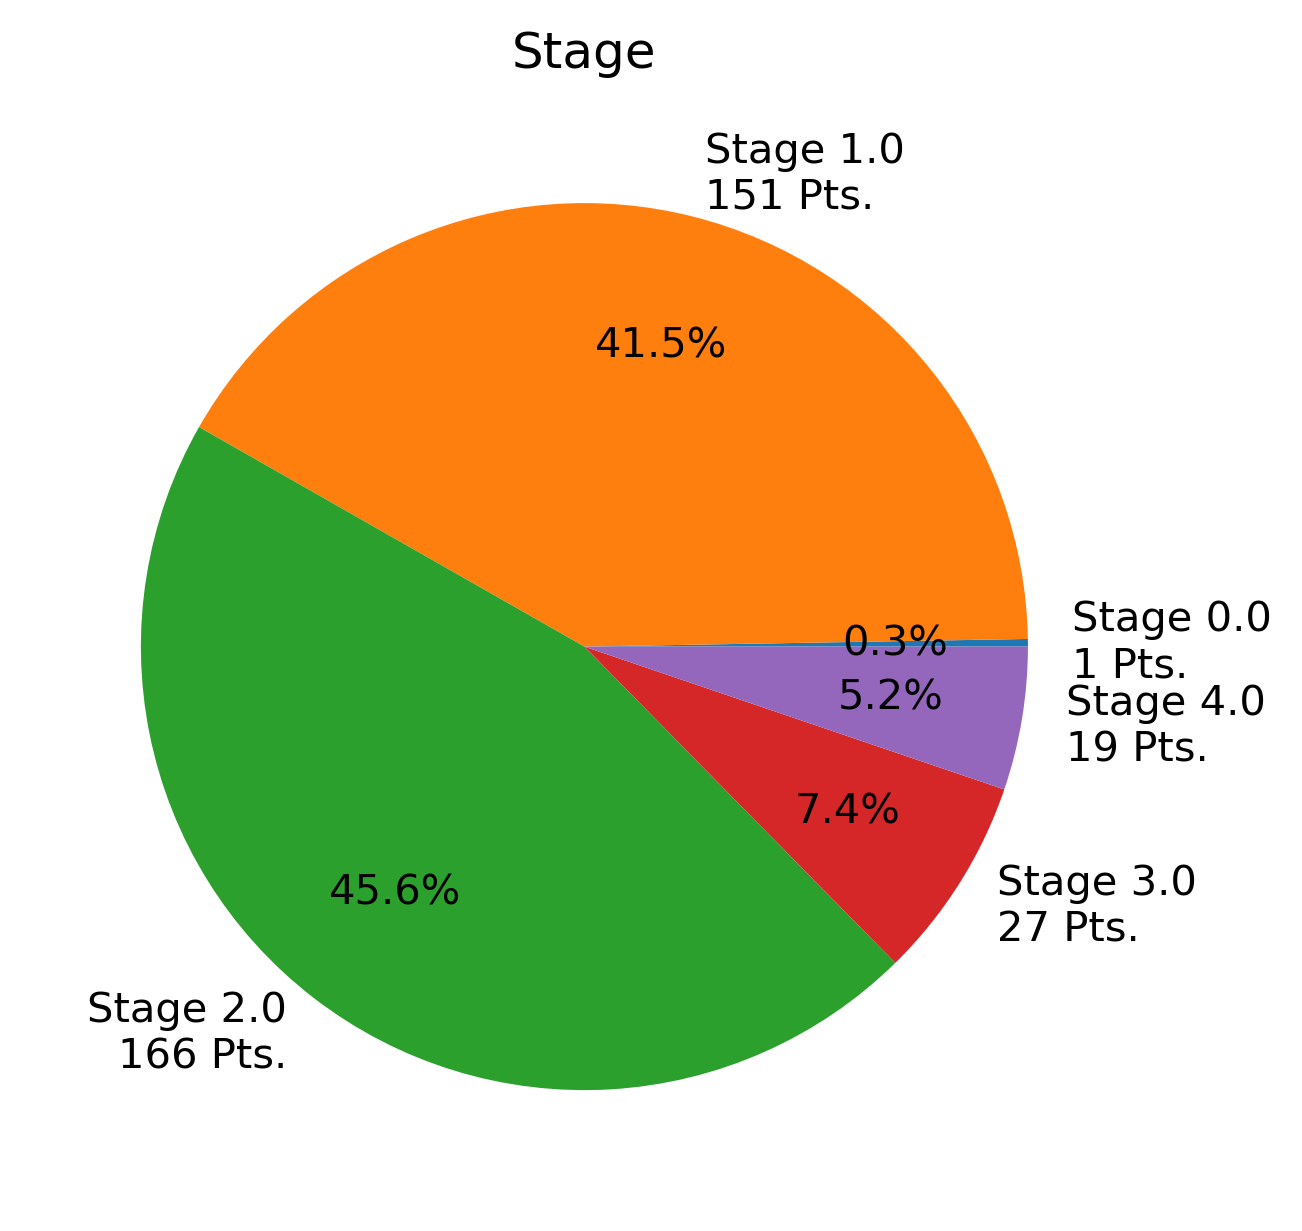

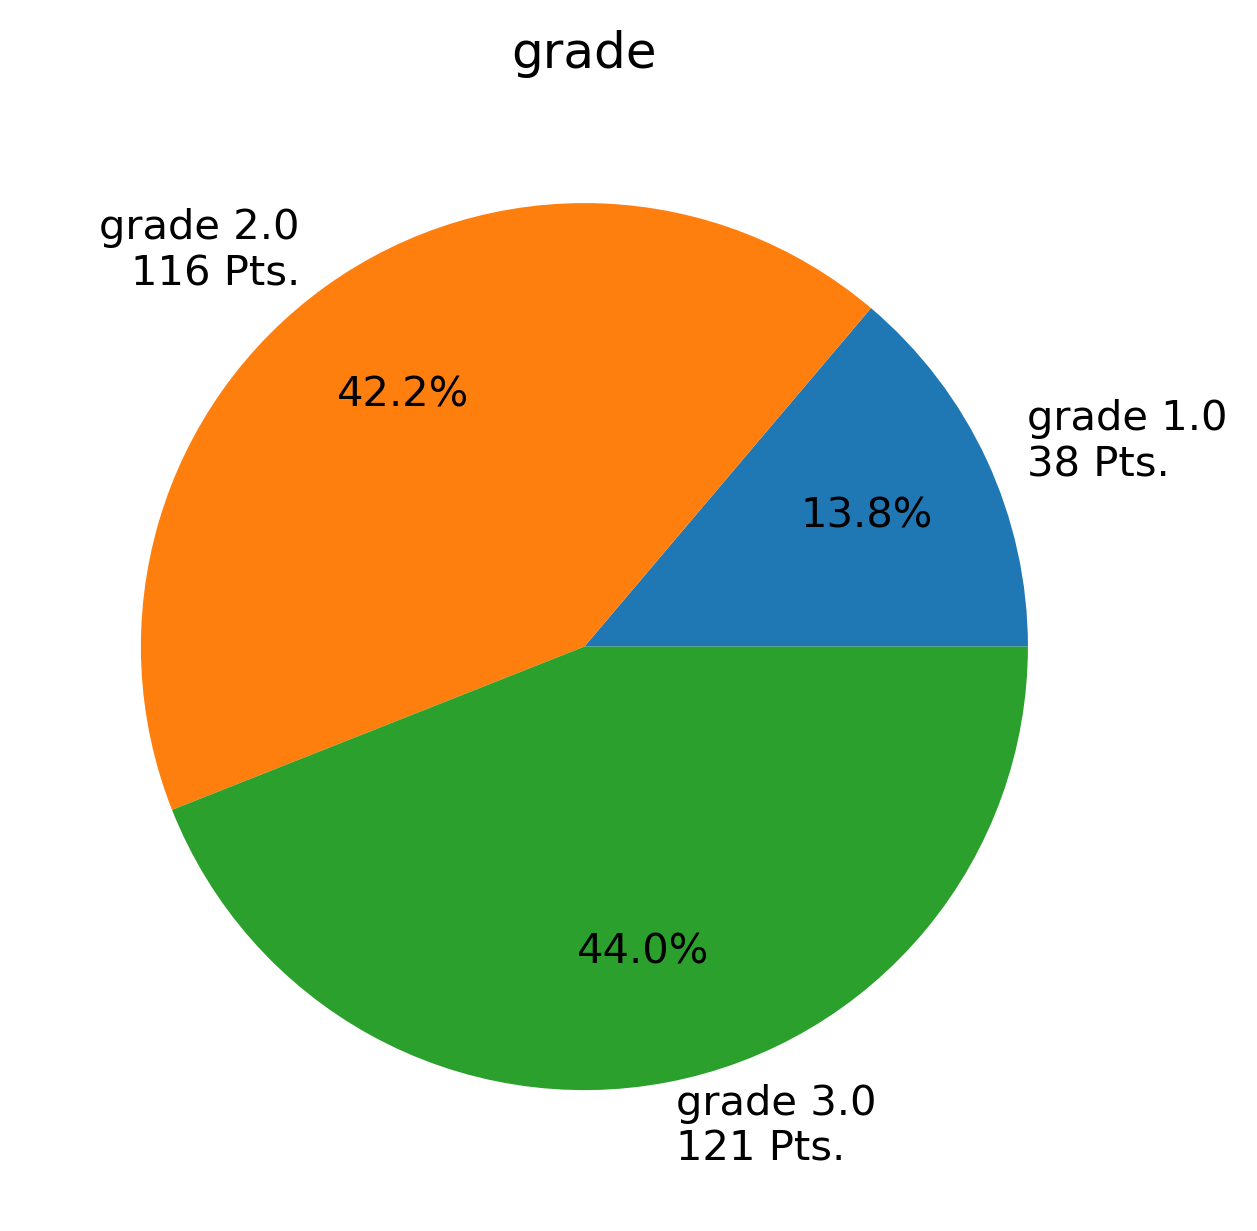

In [12]:

    
for s_clin in ['Stage','grade']:
    df = pd.DataFrame(df_clin.loc[~df_clin.index.isin(ls_drop),s_clin].value_counts())
    df.index.name = s_clin
    df.rename({'count':'No. Pts.'},axis=1,inplace=True)
    # if s_clin == 'Stage':
    #     df.drop('',inplace=True)
    df.to_csv(f'Table_of_{s_clin}.csv')
    df.sort_index(inplace=True,ascending=True)
    fig, ax = plt.subplots(dpi=300)
    ax.pie(df.loc[:,'No. Pts.'],labels=pie_chart_labels(df),autopct='%1.1f%%',
           startangle=0,pctdistance=0.7)
    ax.set_title(s_clin)
    

In [ ]:
#separate cohorts
for s_subtype in ['ER+','TNBC']:
    ls_keep = df_surv[df_surv.subtype==s_subtype].index #,'ER+HER2+','HER2+'
    ls_drop_stage = ['','0']
    width = 0.8
    for s_clin in ['Stage','grade']:
        df = df_clin.loc[(df_clin.index.isin(ls_keep)) & (~df_clin.loc[:,s_clin].isin(ls_drop_stage)),[s_clin,'Platform']].groupby('Platform').value_counts(normalize=True)
        df = df.reset_index().rename({'proportion':'No. Pts.'},axis=1)
        df.sort_values(by=s_clin,inplace=True)
        fig,ax=plt.subplots(figsize=(2,3),dpi=300)
        bottom = np.zeros(2)
        species = sorted(df.loc[:,'Platform'].unique())
        weight_counts = {}
        
        for s_stage in df.loc[:,s_clin].unique():
            print(s_stage)
            df_stage = df[df.loc[:,s_clin]==s_stage]
            try:
                v1 = df_stage.loc[df_stage.Platform==species[0],'No. Pts.'].values[0]
            except:
                v1=0
            try:
                v2 = df_stage.loc[df_stage.Platform==species[1],'No. Pts.'].values[0]
            except:
                v2=0
            a = np.array([v1,v2])
            weight_counts.update({s_stage:a})
        for boolean, weight_count in weight_counts.items():
            p = ax.bar(species, weight_count, width, label=boolean, bottom=bottom)
            bottom += weight_count
        plt.legend(bbox_to_anchor=(1,1),title=s_clin)
        ax.set_title(f'{s_clin} vs. Platform in {s_subtype}')
        ax.set_ylim(0,1.05)
        #break


In [ ]:
d_venn = pd.read_excel('data/marker_panels.xlsx',sheet_name=None,header=1)

In [ ]:
#!conda install -y -c conda-forge matplotlib-venn

In [ ]:
from matplotlib_venn import venn3, venn3_circles
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
ls_drop = set(['Antigen', 'Cytokeratins','Adhesion Molecules', 'Hormone Receptors','RTK Signaling','Endothelial', 
          'Stromal Markers', 'Epigenetic Mark','Transcription Factors','Cell Growth and Division','Immune Context',
          'Nuclear','Cell Death',np.nan])


#venn
d_marker = {}
for s_plat in d_venn.keys():
    d_venn[s_plat]
    es_marker = set(d_venn[s_plat].iloc[:,0]) | set(d_venn[s_plat].iloc[:,2])
    es_marker = es_marker - ls_drop
    d_marker.update({s_plat:es_marker})
fig,ax = plt.subplots(figsize=(4,2.5),dpi=300)
venn3([d_marker['CycIF'], d_marker['IMC'], d_marker['MIBI']], ('CycIF', 'IMC', 'MIBI'),ax=ax)
ax.set_title('Marker Overlap')

In [ ]:
#neo vs survival plot
df_surv.Neoadjuvant = df_surv.Neoadjuvant.replace({True:'Yes',False:'No'})
importlib.reload(plotting)
s_col = 'Neoadjuvant'
for s_time, s_censor in [('Survival_time','Survival'),('Recurrence_time','Recurrence')]:
    for s_subtype in ['TNBC','ER+','both']:
        df=df_surv.loc[df_surv.subtype==s_subtype,[s_col,s_time, s_censor]].dropna()
        if s_subtype == 'both':
            s_subtype = ''
            df=df_surv.loc[df_surv.subtype.isin(['ER+','TNBC']),[s_col,s_time, s_censor]].dropna()
        fig,ax,ls_order = plotting.km_plot_cat(df,s_col,s_time,s_censor,fontsize='medium',loc='upper center')
        ax.set_title(f'Neoadjuvant {s_subtype}')

In [ ]:
df_p = df_clin.merge(df_surv,left_index=True,right_index=True,suffixes=('','_x'))
df_p = df_p[(df_p.Neoadjuvant.notna()) & (df_p.subtype.isin(['TNBC','ER+']))]
s_marker= 'Neoadjuvant'
for s_time, s_censor in [('Survival_time','Survival'),('Recurrence_time','Recurrence')]:
    fig2,ax,cph,df_marker = plotting.clinical_cph(df_p,s_marker,s_time,s_censor,
                    alpha=1,ls_clin=['age','tumor_size','Stage'],figsize=(3.2,1.6))
    ax.set_title(f'{s_marker} {s_censor}\np={cph.summary.loc[s_marker,"p"]:.2} n={len(df_marker)}')
    plt.tight_layout()


In [ ]:
cph.summary

In [ ]:
df_marker.Neoadjuvant.value_counts()

In [ ]:
result, pvalue = stats.ttest_ind(df_marker.loc[df_marker.Neoadjuvant,'tumor_size'],df_marker.loc[~df_marker.Neoadjuvant,'tumor_size'])
fig,ax=plt.subplots(dpi=300,figsize=(2,3))
sns.stripplot(data=df_marker,x='Neoadjuvant',y='tumor_size',ax=ax,alpha=0.7,hue='Neoadjuvant',legend=False)
ax.set_title(f'Neoadjuvant vs Tumor size\nT-test p={pvalue:.2}')

# Load Data and name cell types  <a name="cluster"></a>

- leiden results
    - anotate
- mean intensity


[contents](#contents)

In [ ]:
#name celltypes

d_celltype_cycif = {'4':'Luminal ER+ t.', '12':'Basal t.', '15':'HER2+ Ki67+ t.', '18':'HER2++ t.','22':'HER2++ t.', '19':'endothelial', '20':'EGFR+ t.', '5':'Prolif. t.',
 '9':'Macrophage', '17':'Myoepithelial', '14':'ColI+ FB', '6':'Vim+ FB', '10':'FB', '16':'Quies. str.', '8':'Quies. str.',
 '2':'Vim+ FB', '7':'CK lo. t.', '3s':'CD44+ str.', '3t':'CD44+ t.', '0':'Luminal t.', '11':'CK lo. t.', '13':'CD8 T cell',
 '1':'CD4 T cell', '21':'CD20 B cell'}

#new 4/13
d_celltype_IMC = {'7b':'Basal t.', '21':'Luminal ER+ t.', '22':'EGFR+ t.', '23':'Luminal ER+ t.', '13':'HER2+ ER+ t.',
 '16':'HER2+ ER+ PR+ t.', '14':'Luminal ER+ t.', '2':'Luminal ER+ t.', '17':'CD44+ t.', '12':'Prolif. t.',
 '7':'Myoepithelial', '10':'CK lo. t.', '11':'Luminal ER+ t.', '18':'Luminal t.', '19':'HER2+ Ki67+ t.',
 '4':'HER2+ ER+ t.', '6':'FN+ FB', '3':'Vim+ FB', '1':'Luminal t.', #or CKlo?
 '0':'Quies. str.', '5':'Quies. str.','0b':'FN+ FB','7c':'Pericyte SMA+FB',
 '9':'CD3 T cell', '9b':'CD20 B cell', '15':'Macrophage', '8':'endothelial'}

#update 4/12
d_celltype_MIBI = {'3':'CD4 T cell','3b':'CD20 B cell', '3c':'Dendritic cell', '2b':'CD8 T cell', '2':'CD4 T cell', '17':'FoxP3 Treg',
 '7':'Basal t.', '15':'PD-L1+ Basal t.', '14':'IDO+ Basal t.', '14b':'Dendritic cell', '18':'NK cell', '12':'endothelial',
 '20':'CD209+ imm.', #DC-SIGN  # artifact'21':'quiesc str',
 '9':'Prolif. t.', '6':'CK lo. t.', '5':'Myoepithelial', '19':'EGFR+ t.', '11':'CD63+ t.', '13':'CK lo. t.',
 '1':'FB', '4':'Quies. str.', '0':'Luminal t.', '8':'EGFR+ Basal t.', '10':'Macrophage', '16':'Neutrophil'} #0412

In [ ]:
#leiden clustering results
df_lei_both = pd.DataFrame()

#IMC
#download from synapse: https://www.synapse.org/Synapse:syn61455523
df_lei = pd.read_csv(f'data/20220201_IMC-TMAs_qc_s_g_LeidenClusteringGating_neighbors30_resolution0.6_markers22_all.csv',index_col=0)
df_lei.drop(['DAPI_Xc', 'DAPI_Yc','slide_scenec'],axis=1,inplace=True) #'DAPI_Xc.1', 'DAPI_Yc.1', 'slide_scenec.1'
df_lei['Platform'] = 'IMC'
df_lei['Patient'] = [item.replace('B','') for item in df_lei.Patient]
df_lei['subtype'] = df_lei.subtype.replace({'TripleNeg':'TNBC','HR+HER2-':'ER+','HR+HER2+':'ER+ HER2+', 'HR-HER2+':'HER2+'})
df_lei.leidencelltype3 = df_lei.leidencelltype3.fillna(df_lei.gatedcelltype3).replace({'str.':'stromal','imm.':'immune'})
df_lei.leidencelltype4 = df_lei.leidencelltype4.fillna(df_lei.gatedcelltype3).replace({'str.':'stromal','imm.':'immune'})
df_lei.leidencelltype5 = df_lei.leidencelltype5.fillna(df_lei.gatedcelltype5)
#celltype names
df_lei['leiden'] = df_lei.leiden.astype('str').replace(d_celltype_IMC)
print(len(df_lei))
print(df_lei.loc[:,['DAPI_X','DAPI_Y']].median())
#append IMC
df_lei_both = pd.concat([df_lei_both,df_lei])

#leiden cell types (cyclic)
df_lei = pd.read_csv(f'data/20220408_JP-TMAs_LeidenClustering_neighbors30_resolution0.4_markers23_all.csv',index_col=0)
df_lei['slide_scene'] = [item.split('_cell')[0] for item in df_lei.index]
df_lei['Platform'] = 'cycIF'
df_lei['Patient'] = df_lei.slide_scene.map(dict(zip(df_cyc_sub.index,df_cyc_sub.Accession)))
df_lei['subtype'] = df_lei.slide_scene.map(dict(zip(df_cyc_sub.index,df_cyc_sub.ID)))
df_lei['gatedcelltype3'] = df_lei.celltype.replace({'endothelial':'stromal'})
df_lei['leiden'] = df_lei.leiden.replace(d_celltype_cycif)
#rename columns
df_lei = df_lei.rename({'aSMA':'SMA'},axis=1)
#rescale
print(df_lei.loc[:,['DAPI_X','DAPI_Y']].median())
df_lei.loc[:,['DAPI_X','DAPI_Y']] = df_lei.loc[:,['DAPI_X','DAPI_Y']]*.325
print(len(df_lei))
print(df_lei.loc[:,['DAPI_X','DAPI_Y']].median())
#append cycIF
df_lei_both = pd.concat([df_lei_both,df_lei])

#mibi
#0.39 μm per pixel
df_lei = pd.read_csv(f'data/20220316_MIBI_s_LeidenClusteringGating_neighbors30_resolution0.6_markers35_Filtered.csv',index_col=0)
df_lei['slide_scene'] = [item.split('_cell')[0] for item in df_lei.index]
df_lei['Platform'] = 'MIBI'
df_lei['Patient'] = ['M'+str(item) for item in df_lei.slide]
df_lei['subtype'] = 'TNBC'
#rescale
print(df_lei.loc[:,['DAPI_X','DAPI_Y']].median())
df_lei.loc[:,['DAPI_X','DAPI_Y']] = df_lei.loc[:,['DAPI_X','DAPI_Y']]*.39
df_lei['leiden'] = df_lei.leiden.replace(d_celltype_MIBI)
d_replace = { 'immune':'stromal', 'fibroblast':'stromal', 'endothelial':'stromal'}
df_lei['leidencelltype2'] = df_lei.leidencelltype5.replace(d_replace)
print(len(df_lei))
print(df_lei.loc[:,['DAPI_X','DAPI_Y']].median())
#append mibi
df_lei_both = pd.concat([df_lei_both,df_lei])


In [ ]:
df_lei_both.Platform.isna().any()

In [ ]:
#Median radius of tissues from each platform
df_lei_both.loc[:,['DAPI_X','DAPI_Y','Platform']].groupby('Platform').median()

In [ ]:
#save combined dataframes of celltype
s_out = f'{codedir}/data/20220420_JP-TMAs_IMC-TMAs_MIBI_CombinedCelltypes_all.csv' #20220204_JP-TMAs_BaselTMA_CombinedCelltypes.csv
if not os.path.exists(s_out):
    print('saving csv')
    #df_lei_both.to_csv(s_out)

## Summarize Tissue Variables <a name="tissue"></a>

per patient means


[contents](#contents)

In [ ]:
#load combined
s_sample = '20220420_JP-TMAs_IMC-TMAs_MIBI' 
s_type = 'all'
#download from synapse: https://www.synapse.org/Synapse:syn61455523
df_lei = pd.read_csv(f'{codedir}/data/{s_sample}_CombinedCelltypes_{s_type}.csv',index_col=0,low_memory=False)
df_lei['celltype1'] = 'all'
df_lei['countme'] = True
df_lei['leidencelltype2_tofill'] = df_lei.leidencelltype3.replace({'tumor':'epithelial','endothelial':'stromal',
                                                            'immune':'stromal','imm.':'stromal','str.':'stromal'})
df_lei['leidencelltype2'] = df_lei.leidencelltype2.fillna(df_lei.leidencelltype2_tofill)
df_lei.subtype = df_lei.subtype.replace({'ER+HER2+':'ER+ HER2+'})
df_lei.Patient = df_lei.Patient.astype('str')
df_lei.leiden = df_lei.leiden.astype('str')

In [ ]:
from matplotlib_venn import venn3, venn3_circles
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted

#venn
d_marker = {}
for s_plat in df_lei.Platform.unique():
    es_marker = set(df_lei[df_lei.Platform==s_plat].leiden.unique()) | set(['CD3 T cell','CD3 T cell'])
    d_marker.update({s_plat:es_marker})
fig,ax = plt.subplots(figsize=(4,2.5),dpi=300)
venn3([d_marker['cycIF'], d_marker['IMC'], d_marker['MIBI']], ('cycIF', 'IMC', 'MIBI'),ax=ax)
ax.set_title('Cell Type Overlap')

In [ ]:

print(df_lei.Platform.unique())
print(df_lei.subtype.unique())
for s_cell in ['gatedcelltype5','leidencelltype5',]:
    for s_subtype in ['ER+', 'TNBC', 'HER2+']:
        df_both = pd.DataFrame(index = ['endothelial', 'epithelial', 'fibroblast', 'immune', 'stromal'])
        ls_plat_pt = []
        for s_plat in sorted(df_lei[df_lei.subtype==s_subtype].Platform.unique()):
            df_mib = df_lei[(df_lei.subtype==s_subtype)&(df_lei.Platform==s_plat)]
            df_st = df_mib.groupby(s_cell).CD31.count()/len(df_mib)
            df = pd.DataFrame(df_st).rename({'CD31':s_plat},axis=1)
            df_both = pd.concat([df_both,df],axis=1)
            ls_plat_pt.append(str(df_mib.Patient.nunique()))
        #corr
        se_corr = df_both.corr(method='pearson').unstack().loc['cycIF']
        i_corr = se_corr[se_corr != 1].mean()
        fig,ax = plt.subplots(figsize=(3,3),dpi=300)
        pd.DataFrame(df_both).T.plot(kind='bar',stacked=True,title=s_subtype,ax=ax)
        ax.legend(bbox_to_anchor=(1,.7),title=s_cell,frameon=False)
        ax.set_title('')
        ax.set_title(f'No. Pts.={", ".join(ls_plat_pt)}',fontsize='medium',loc='right')
        fig.suptitle(f'{s_subtype}  r={i_corr:.2}',x=.29,y=.9)
        plt.tight_layout()
        #fig.savefig(f'{codedir}/{s_date}/Cell_Fractions_{s_subtype}_{s_cell}.png')
        #break
    #break


In [ ]:

df_both = pd.DataFrame(index = ['ER+',  'HER2+','ER+ HER2+','TNBC',])
for s_plat in ['IMC', 'cycIF', 'MIBI']:
    df_mib = df_lei[(df_lei.Platform==s_plat)]
    df_mib.index = df_mib.Patient
    df_st = df_mib[~df_mib.index.duplicated()].groupby('subtype').CD31.count()
    df = pd.DataFrame(df_st).rename({'CD31':s_plat},axis=1)
    print(s_plat)
    print(df)
    df_both = pd.concat([df_both,df],axis=1)
fig,ax = plt.subplots(figsize=(4.3,2),dpi=300)
pd.DataFrame(df_both).T.plot(kind='barh',stacked=True,title='No. Pts.',ax=ax)
ax.legend(bbox_to_anchor=(1,.95),title='subtype')
plt.tight_layout()
#fig.savefig(f'{codedir}/{s_date}/Subtype_Fractions_{s_subtype}.png')

In [ ]:
d_both = {}
for s_plat in ['IMC', 'cycIF', 'MIBI']:
    df_mib = df_lei[(df_lei.Platform==s_plat)]
    df_st = df_mib.groupby('Patient').CD31.count()
    d_both.update({s_plat:df_st})
    
df_both = pd.DataFrame(d_both)
fig,ax=plt.subplots(figsize=(3,3),dpi=300)
sns.violinplot(data=df_both,order=['IMC','MIBI','cycIF'],cut=0,ax=ax)
sns.stripplot(data=df_both,order=['IMC','MIBI','cycIF'],palette='dark',s=1,ax=ax)
ax.set_title('Number of Cells per Patient')
plt.tight_layout()

In [ ]:
if not os.path.exists(f'{codedir}/Results/'):
    print('make results file folder')
    if not b_binder:
        os.mkdir(f'{codedir}/Results/')

In [ ]:
# import pandas as pd
# import sys
# import os
# save out the source data (done)
# idx = 0
# with pd.ExcelWriter('Source_Data.xlsx') as writer:
#     for csvfilename in sorted(os.listdir('data')):
#         if csvfilename.find('.csv') > -1:
#             size_mb = (os.path.getsize(f'data/{csvfilename}')/1024)/1024
#             if size_mb < 10:
#                 print(f'good size: {csvfilename}')
#                 idx+=1
#                 df = pd.read_csv(f'data/{csvfilename}')#,index_col=0
#                 sheet_name = csvfilename[:31]
#                 df.to_excel(writer, sheet_name=sheet_name)
#             else:
#                 print(f'too large: {csvfilename}')
#     print(idx)
#     for csvfilename in sorted(os.listdir('Results')):
#         if csvfilename.find('.csv') > -1:
#             size_mb = (os.path.getsize(f'Results/{csvfilename}')/1024)/1024
#             if size_mb < 50:
#                 print(f'good size: {csvfilename}')
#                 df = pd.read_csv(f'Results/{csvfilename}')#,index_col=0
#                 if csvfilename.find('subtyping_') >-1:
#                     sheet_name = csvfilename.split("subtyping_")[1].replace('LeidenClustering','LeidenClust')[-31:]
#                 else:
#                     sheet_name = csvfilename.split("results_")[1][:31]
#                 df.to_excel(writer, sheet_name=sheet_name)
#             else:
#                 print(f'too large: {csvfilename}')

In [ ]:
#Save gated and clustering cell lineages (fraction per patient)

s_grouper='Patient'
ls_cell = ['leidencelltype5','gatedcelltype5']#,'celltype' 'leidencelltype3','leidencelltype4',
for s_cell in ls_cell:
    df_prop = viz.prop_positive(df_lei,s_cell=s_cell,s_grouper=s_grouper)
    s_out = f'results_{s_sample}_GatedCellTypes_by{s_grouper}_by{s_cell}_{s_type}.csv'
    print(s_out)
    if not os.path.exists(f'{codedir}/Results/{s_out}'):
        print('saving')
        #df_prop.to_csv(f'{codedir}/Results/{s_out}')
    #break
print(len(df_lei))

## leiden celltypes

In [ ]:
#corrections (ER+ artifacts in TN tissues)
ls_TNBC = ['103', '114', '116', '129', '163', '272', '00-8939-2D', '90-526-2M', 'JP-TMA2-1_scene21', 'JP-TMA2-1_scene26',
 'JP-TMA2-1_scene31', 'Z28']
ls_ERneg = ['3', '4', '18', '24', '29', '32', '35', '38', '44', '48', '50', '56', '62', '65', '76', '79', '80', '83', '86',
 '92', '100', '101', '102', '108', '109', '118', '119', '120', '122', '126', '128', '130', '131', '138', '141', '146', '148',
 '153', '158', '169', '170', '173', '177', '183', '188', '206', '210', '211', '212', '217', '219', '221', '223', '225', '234',
 '237', '239', '242', '245', '247', '248', '250', '256', '260', '263', '264', '268', '271', '273', '279', '281', '282']
print(s_date)
if not s_date == '20220412': #produced results_20220420_JP-TMAs_IMC-TMAs_MIBI
    print('update ER status')
    df_lei.loc[(df_lei.Patient.isin(ls_TNBC)) & (df_lei.leiden=='Luminal ER+ t.'),'leiden'] = 'Luminal t.'
print(len(df_lei))

#Save leiden celltypes (fraction per patient)

for s_celltype in ['leidencelltype2','celltype1']: #'celltype3','celltype',
    for s_cell in df_lei.loc[:,s_celltype].unique():
        df_cell = df_lei.loc[df_lei.loc[:,s_celltype]==s_cell]
        df_prop = viz.prop_positive(df_cell,s_cell='leiden',s_grouper='Patient')
        s_out = f'results_{s_sample}_LeidenClustering_byPatient_by{s_celltype}_in{s_cell}_{s_type}.csv'
        for s_plat in df_lei.Platform.unique():
            ls_patient = df_lei[df_lei.Platform==s_plat].Patient.unique()
            df_prop.loc[ls_patient,~df_prop.loc[ls_patient].isna().all()] = df_prop.loc[ls_patient,~df_prop.loc[ls_patient].isna().all()].fillna(0)
        if not os.path.exists(f'{codedir}/Results/{s_out}'):
            print('saving')
            #df_prop.to_csv(f'{codedir}/Results/{s_out}')
        print(s_out)

## Survival analysis <a name="surv"></a>


- single variable


[contents](#contents)


In [ ]:
#load annotation
df_surv = pd.read_csv('data/TMA_Survival_Subtype.csv',index_col=0)
df_clin = pd.read_csv('data/TMA_Clinical_Variables.csv',index_col=0)
df_surv.loc[df_surv.index.str.contains('JP-TMA2'),'Platform'] = 'cycIF2'

In [ ]:
#Load per patient means
s_sample = '20220420_JP-TMAs_IMC-TMAs_MIBI'#

df_file = pd.DataFrame()
for s_file in os.listdir('Results'):
    if s_file.find(f'results_{s_sample}_LeidenClustering_') > -1:
        s_type = 'LeidenClustering'
        s_subtype = s_file.split('.csv')[0].split('_')[-1]
        s_partition = s_file.split('.csv')[0].split('_')[-3].split('by')[1]
        s_cell = s_file.split('.csv')[0].split('_')[-2].split('in')[1]   
    elif s_file.find(f'results_{s_sample}_Density_') > -1:
        s_type = 'Density'
        s_subtype = s_file.split('.csv')[0].split('_')[-1]
        s_partition = s_file.split('.csv')[0].split('_')[-2].split('by')[1]
        s_cell = 'density'
    else:
        continue
    df_file.loc[s_file,'subtype'] = s_subtype
    df_file.loc[s_file,'type'] = s_type
    df_file.loc[s_file,'partition'] = s_partition
    df_file.loc[s_file,'cell'] = s_cell
    #break

df_surv.index = df_surv.index.astype('str')
ls_file = ['results_20220420_JP-TMAs_IMC-TMAs_MIBI_LeidenClustering_byPatient_bycelltype1_inall_all.csv']

In [ ]:
df_file
ls_file

### Find cutpoints 

Find the quantile that binarizes patients into high and low with maximum difference in survival, using cycIF data.

Test tertitles and median.

In [ ]:
#single platform survival for supplement
alpha = 0.05
%matplotlib inline
# cycif results - ER+ CD44+ tum TNBC: CD20 b cell, CD3 t cell,  CD44+ tum, CD44+ str.
#[CD8 t cell,CD4 t cell] macrophage, myoep, prolif tum, endothelial
savedir = f'{codedir}/{s_date}'

for s_time, s_censor in [('Survival_time','Survival'),('Recurrence_time','Recurrence')]:
    for s_index in ls_file: 
        print(s_index)
        s_type = df_file.loc[s_index,'type']
        s_cell = df_file.loc[s_index,'cell']
        df_all=pd.read_csv(f'results/{s_index}',index_col=0)
        df_all.index = df_all.index.astype('str')
        ls_marker = df_all.columns
        df_all = df_all.merge(df_surv,left_index=True,right_index=True)
        if df_all.columns.str.contains('CD4 T cell').any():
            df_all.loc[df_all.Platform!='IMC','CD3 T cell'] = df_all.loc[df_all.Platform!='IMC',['CD4 T cell','CD8 T cell']].sum(axis=1)
        for s_subtype in ['ER+','TNBC',]:#,'HER2+'
            for s_plat in ['cycIF','IMC','MIBI',]:
                for s_col in ls_marker:
                    #s_col = 'Vim+ FB' #'CD8 T cell'#
                    for cutp in [0.33,.5,.66,]:
                        util.single_km(df_all,s_cell,s_subtype,s_plat,s_col,savedir,alpha,cutp,s_time,s_censor)
                        #break
                    #break
                break #platform
            #break #subtype
        break #only test in all
    break #survival/recur

# combine platforms

FDR multiple testing  correction

In [ ]:
# load high and low proliferation output
df_prolif = pd.read_csv(f'{codedir}/data/Prolif._t._high_low.csv',index_col=0)
df_prolif.index = df_prolif.index.astype('str')
df_prolif.rename({'Prolif. t. abundance':'abundance'},axis=1,inplace=True)
d_prolif = dict(zip(df_prolif.index,df_prolif.abundance))
print(len(df_prolif))
#read dataframe with more cell types
s_index ='results_20220420_JP-TMAs_IMC-TMAs_MIBI_LeidenClustering_byPatient_bycelltype1_inall_all.csv'
df_all=pd.read_csv(f'Results/{s_index}',index_col=0)
print(len(df_all))
df_all.index = df_all.index.astype('str')
df = df_all.merge(df_surv,left_index=True,right_index=True,how='left')
df.loc[df.Platform!='IMC','CD3 T cell'] = df.loc[df.Platform!='IMC',['CD4 T cell','CD8 T cell']].sum(axis=1)
df['prolif'] = df.index.map(d_prolif)
df.index = df.index.astype('str')
print(len(df))

In [ ]:
# combine platforms for survival analysis by all, and by low/high proliferation

savedir = f"{codedir}/{s_date}"
#what do i correct for? 4 cell types
d_cut = {'CD20 B cell':0.33,
             ##'CD8 T cell':0.33, 'CD4 T cell':0.33, #not found in IMC (use CD3 T cell 
             ##'CD44+ str.':0.33,'Myoepithelial':0.66, #not found in MIBI
             ##'CD44+ t.':0.33,  #discovery  #not found in MIBI
             'CD3 T cell':0.33, #discover (CD8)
          'endothelial':0.33, 'Prolif. t.':0.5,
             ##'Vim+ FB':0.5, #discovery #Vim+ FB not prognostic, plotting to compare to Vim+ spatial LDA neighborhood
            }

alpha = 1.05
#df_prolif = pd.DataFrame()
d_discovery = {#'Discovery':['cycIF'],
    'Validation':['IMC','MIBI','cycIF2'],
               'Clinical':['IMC','MIBI','cycIF2','cycIF']}
for s_discovery, ls_plat in d_discovery.items():
    if s_discovery == 'Discovery':
        print(s_discovery)
        alphad=0.05
    else:
        alphad=0.000001
    for s_time, s_censor in [('Survival_time','Survival'),('Recurrence_time','Recurrence')]:
        for s_subtype in ['ER+','TNBC',]:
            for s_cell in ['all','high-prolif','low-prolif',]: #,
                if (s_cell.find('prolif')>-1) & (s_subtype=='ER+') & (s_discovery=='Validation'):
                    print('including cycIF')
                    ls_plat = ['IMC','cycIF','cycIF2']
                ls_pval = []
                d_data = {}
                for s_col, cutp in d_cut.items():
                    #combine all samples high and low across platforms
                    df_both=pd.DataFrame()
                    print(ls_plat)
                    for s_plat in ls_plat:
                        if s_cell == 'all':
                            df_all = df.drop('prolif',axis=1).copy()
                            df_all.index = df_all.index.astype('str')
                        elif s_cell == 'high-prolif':
                            s_discovery = s_cell
                            s_low_high = 'high'
                            df_all = df.loc[df.prolif==s_low_high,:].copy()
                        elif s_cell == 'low-prolif':
                            s_discovery = s_cell
                            s_low_high = 'low'
                            df_all = df.loc[df.prolif==s_low_high,:].copy()
                        else:
                            df_all = df.loc[df.leiden==s_cell,:].copy()

                        df_p = util.single_km(df_all,s_cell,s_subtype,s_plat,s_col,savedir,alpha=alphad,cutp=cutp,s_time=s_time,s_censor=s_censor) 
                        df_both = pd.concat([df_both,df_p])
                    df_both_surv = df_both.dropna()
                    #log rank
                    if len(df_both_surv) > 0:
                        results = util.multivariate_logrank_test(event_durations=df_both_surv.loc[:,s_time],
                                                        groups=df_both_surv.abundance, event_observed=df_both_surv.loc[:,s_censor])
                    d_data.update({s_col:[df_both_surv,cutp]})
                    ls_pval.append(results.summary.p[0])
                #'''
                #run multiple test correction
                reject, corrected, __, __ = statsmodels.stats.multitest.multipletests(ls_pval,method='fdr_bh')# #'fdr_bh'
                d_correct = dict(zip(d_cut.keys(),corrected))
                d_orig = dict(zip(d_cut.keys(),ls_pval))
                ls_pval_cph = []
                ls_cph_markers = []
                for s_col, p_correct in d_correct.items():
                    df_both_surv = d_data[s_col][0]
                    cutp = d_data[s_col][1]
                    s_title2 = f'{s_col} n={len(df_both_surv)}'
                    s_title1 = f'{s_subtype} {s_censor}'
                    if s_cell.find('prolif') > -1:
                        s_title1 = f'{s_subtype} {s_cell} {s_censor}' 
                    #kaplan meier plotting
                    if (s_col == 'CD3 T cell') & (s_subtype == 'ER+'):
                        alpha=.99
                    else:
                        alpha=1.05
                    if p_correct < alpha:
                        #if s_discovery== 'Discovery':
                       #cool plotting function for all platforms
                        s_title1 = f'{s_subtype} {s_discovery}'
                        s_title2 = f'{s_col} Abundance'
                        fig1, fig2, pval_cph, pval_km = util.km_cph_all(df_both_surv,df_clin,s_title1,s_title2,s_col,alpha=alpha,s_time=s_time, s_censor=s_censor,
                               s_groups='abundance',s_cph_model='high',ls_clin=['age','tumor_size','Stage'],p_correct=p_correct)
                        if not fig1 is None:
                            continue
                            #fig1.savefig(f"{codedir}/{s_date}/Survival_Plots/KM_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}_{cutp}.png",dpi=300)
                        if not fig2 is None:
                            continue
                            #fig2.savefig(f"{codedir}/{s_date}/Survival_Plots/CPH_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}_{cutp}.png")
                        ls_pval_cph.append(pval_cph)
                        ls_cph_markers.append(s_col)
                try:
                    reject2, corrected2, __, __ = statsmodels.stats.multitest.multipletests(ls_pval_cph,alpha=0.1,method='fdr_bh')
                    print(f'{s_discovery} {s_subtype}')
                    [print(f'{ls_cph_markers[idx]} {corrected2[idx]}') for idx,item in enumerate(reject2) if item]
                except:
                    print('')
                #df_prolif = pd.concat([df_prolif,df_both])
                #'''
                break  #all, high low prolif
            #break #subtype
        break #recurrence
    break #disc/val


In [ ]:
# #output high low (done)
# df_prolif = pd.DataFrame()
# s_low_high = 'high'
# ls_col = ['Prolif. t.',
#     'CD3 T cell']
# df_all_prolif = pd.DataFrame()
# for s_col in ls_col:
#     df_prolif=pd.DataFrame()
#     for s_subtype in ['TNBC','ER+']:
#         #print(s_subtype)
#         for s_plat in ['IMC','MIBI','cycIF','cycIF2']:
#             df_all = df.drop('prolif',axis=1).copy()
#             df_p = low_high_abun(df_all,s_subtype,s_plat,s_col)
#             #print(len(df_p))
#             df_prolif = pd.concat([df_prolif,df_p])
#     print(len(df_prolif))
#     df_prolif.rename({'abundance':f'{s_col} abundance'},axis=1,inplace=True)
#     if not os.path.exists(f'{s_date}/{s_col.replace(" ","_")}_high_low.csv'):
#         print('saving')
#         df_prolif.to_csv(f'{s_date}/{s_col.replace(" ","_")}_high_low.csv')
#     #print(df_prolif.groupby(f'{s_col} abundance').mean())
#     #print(df_prolif[df_prolif.loc[:,f'{s_col} abundance'].isna()].loc[:,s_col])
#     if s_col == 'Prolif. t.':
#         #print(s_col)
#         df_all_prolif = pd.concat([df_all_prolif,df_prolif])
#     else:
#         df_all_prolif = df_all_prolif.merge(df_prolif.loc[:,[f'{s_col} abundance']],left_index=True,right_index=True)

# df_all_prolif['ProlifTum_Tcell'] = df_all_prolif.loc[:,'Prolif. t. abundance'] + '_' + df_all_prolif.loc[:,'CD3 T cell abundance']

In [ ]:
#load T cell above/below median (i.e. high low)
df_tcell = pd.read_csv('data/CD3_T_cell_high_low.csv',index_col=0)
df_all_prolif = df_prolif.merge(df_tcell.loc[:,~df_tcell.columns.isin(df_prolif.columns)],
                left_index=True,right_index=True,)
#combine
df_all_prolif['ProlifTum_Tcell'] = df_all_prolif.abundance + '_' + df_all_prolif.loc[:,'CD3 T cell abundance']

In [ ]:
#combine platforms
importlib.reload(plotting)
s_col = 'ProlifTum_Tcell'
s_time = 'Survival_time'
s_censor = 'Survival'
for s_subtype in ['TNBC','ER+']:
        df_sub = df_all_prolif[(df_all_prolif.subtype==s_subtype)]
        fig,ax = plotting.cat_km(df_sub,s_col,s_time,s_censor)
        fig.suptitle(f'All {s_subtype}',fontsize='medium',x=0.35,y=.91)
        ax.set_xlabel('Survival time (days)')
        ax.set_ylabel('Fraction Alive')
        plt.tight_layout()
        #fig.savefig(f'{s_date}/KM_{s_col}_allplat_{s_subtype}_{s_censor}.png')
        #plt.close(fig)

In [ ]:
s_col = 'ProlifTum_Tcell'
s_time = 'Survival_time'
s_censor = 'Survival'
for s_subtype in ['TNBC','ER+']:
    for s_plat in ['IMC','cycIF','MIBI']:
        df_sub = df_all_prolif[(df_all_prolif.Platform==s_plat) & (df_all_prolif.subtype==s_subtype)]
        fig,ax = plotting.cat_km(df_sub,s_col,s_time,s_censor,figsize=(2.5,3))
        fig.suptitle(f'{s_plat} {s_subtype}',fontsize='medium',x=0.5,y=.91)
        plt.legend().remove()
        plt.tight_layout()
        #fig.savefig(f'{s_date}/KM_{s_col}_{s_plat}_{s_subtype}_{s_censor}.png')
        #plt.close(fig)

In [ ]:
# s_col = 'ProlifTum_Tcell'
# df_all_prolif.to_csv(f'{s_date}/{s_col.replace(" ","_")}_high_low.csv')

In [ ]:
#os.listdir('Results')

## Spatial LDA  <a name="clin"></a> 




[contents](#contents)

In [ ]:
# LDA
dd_discover={}
savedir = f"{codedir}/{s_date}"
alpha = 0.99
s_type = 'SpatialLDA'
s_cell = 'Kmeans'
k=8
df_prolif = pd.DataFrame()
d_discovery = {#'Discovery':['cycIF'],
               'Validation':['IMC','cycIF2'], 
               'Clinical':['IMC','cycIF','cycIF2']} #'MIBI',
dd_validate = {'TNBC':{'Vim+ FB':0.66,'T cell':0.33}, #'T cell':0.33,
               'ER+':{'mixed FB':0.66}}

for s_discovery, ls_plat in d_discovery.items():
    for s_time, s_censor in [('Survival_time','Survival'),('Recurrence_time','Recurrence')]:
        for s_subtype in ['ER+','TNBC',]:
            d_cut = dd_validate[s_subtype]
            print(f'{s_subtype} {s_censor} cells to test: {len(d_cut)}')
            ls_pval = []
            d_data = {}
            for s_col, cutp in d_cut.items():
                print(s_col)
                df_both = pd.DataFrame()
                for s_plat in ls_plat: 
                    if s_plat == 'cycIF2':
                        s_plat_read = 'cycIF'
                    else:
                        s_plat_read = s_plat
                    df_all=pd.read_csv(f'{codedir}/Results/results_{s_subtype}_{s_plat_read}_SpatialLDA_byPatient_byKmeans_k{k}.csv',index_col=0)
                    df_all.index = df_all.index.astype('str')
                    df_all = df_all.merge(df_surv,left_index=True,right_index=True)  
                    if df_all.columns.isin([s_col]).any():
                        df_km_out = util.single_km(df_all,s_cell,s_subtype,s_plat,s_col,savedir,alpha=0.00001,cutp=cutp,s_time=s_time,s_censor=s_censor)
                        df_both = pd.concat([df_both, df_km_out])
                        print(len(df_both))
                df_both_surv = df_both.dropna()
                print(len(df_both_surv))
                #log rank
                results = multivariate_logrank_test(event_durations=df_both_surv.loc[:,s_time],
                                                    groups=df_both_surv.loc[:,'abundance'], 
                                                    event_observed=df_both_surv.loc[:,s_censor])
                d_data.update({s_col:[df_both_surv,cutp]})
                ls_pval.append(results.summary.p[0])
            print(f'pvals: {len(ls_pval)}')
            #run multiple test correction
            reject, corrected, __, __ = statsmodels.stats.multitest.multipletests(ls_pval,method='fdr_bh')# #'fdr_bh'
            d_correct = dict(zip(d_cut.keys(),corrected))
            d_orig = dict(zip(d_cut.keys(),ls_pval))
            ls_pval_cph = []
            ls_cph_markers = []        
            if s_discovery == 'Discovery':
                p_correct_used=None
            else:
                p_correct_used= None #p_correct # 
            ###########################################
            for s_col, p_correct in d_correct.items():
                df_both_surv = d_data[s_col][0]
                print(len(df_both_surv))
                cutp = d_data[s_col][1]
                s_title2 = f'{s_col} n={len(df_both_surv)}'
                s_title1 = f'{s_subtype} {s_censor}'
                if p_correct < alpha:
                    #if s_discovery== 'Discovery':
                   #cool plotting function for all platforms
                    s_title1 = f'{s_subtype} {s_discovery}'
                    s_title2 = f'{s_col} Neighborhoods'
                    fig1, fig2, pval_cph, pval_km = util.km_cph_all(df_both_surv,df_clin,s_title1,s_title2,s_col,alpha=alpha,s_time=s_time, s_censor=s_censor,
                           s_groups='abundance',s_cph_model='high',ls_clin=['age','tumor_size','Stage'],p_correct=p_correct_used)
                    if not fig1 is None:
                        continue
                        #fig1.savefig(f"{codedir}/{s_date}/Survival_Plots/KM_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}_{cutp}.png",dpi=300)
                    if not fig2 is None:
                        continue
                        #fig2.savefig(f"{codedir}/{s_date}/Survival_Plots/CPH_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}_{cutp}.png")
                    ls_pval_cph.append(pval_cph)
                    ls_cph_markers.append(s_col)
#             try:
#                 reject2, corrected2, __, __ = statsmodels.stats.multitest.multipletests(ls_pval_cph,alpha=alpha,method='fdr_bh')
#                 #print(f'{s_discovery} {s_subtype}')
#                 [print(f'{ls_cph_markers[idx]} {corrected2[idx]}') for idx,item in enumerate(reject2) if item]
#             except:
#                 print('not correct')
            df_prolif = pd.concat([df_prolif,df_both])
            dd_discover.update({f'{s_subtype}_{s_censor}':d_orig})
                
            #break #subtype
        #break #recurrence
    break #disc/val


## Subtyping analysis <a name="subtIMC"></a>

- IMC and cyclic

- Basel (ERneg removed), Zurich and cyclic

- common celltypes


[contents](#contents)

In [ ]:
#results data
s_cell ='epithelial'
s_sample = '20220420_JP-TMAs_IMC-TMAs_MIBI'
#savedir=f'{codedir}/20220408/Survival_Plots_Both'
df_file = pd.read_csv(f'{codedir}/Results/{s_sample}_results_files.csv',index_col=0)
df_file[(df_file.cell==s_cell) & (df_file.type!='MeanIntensity')]

#load annotation
df_surv = pd.read_csv('data/TMA_Survival_Subtype.csv',index_col=0)
df_clin = pd.read_csv('data/TMA_Clinical_Variables.csv',index_col=0)

## Platforms together <a name="st1"></a>

- celltype5 and  epithelial

- gatedcelltype5 not prognostic

- epithelial is prog!!!


[contents](#contents)



In [ ]:
### adata
import sklearn
ls_her2 = ['1', '10', '117', '118', '120', '136', '148', '16', '17', '182', '183',
       '2', '225', '226', '237', '253', '259', '261', '267', '29', '48', '51',
       '53', '54', '55', '57', '7', '9', 'Z1', 'Z15', 'Z43', 'Z44', 'Z47',
       'Z51', 'Z55', 'Z56', 'Z70', 'Z8']
savedir = f'{codedir}/{s_date}/Survival_Plots_Both'
n_neighbors =  6 #
savedir = f'{codedir}/{s_date}/Survival_Plots_Both'
dd_bad = {'epithelial':{'TNBC_HER2+ ER+ t.':'Luminal t.',#
                        'TNBC_Luminal ER+ t.':'Luminal t.'}}
for s_cell in ['epithelial']:
    d_bad = dd_bad[s_cell]
    df_load = df_file[(df_file.cell==s_cell) & (df_file.type!='MeanIntensity')]
    s_index = df_load.index[0]
    print(s_index)
    df = pd.read_csv(f'{codedir}/results/{s_index}',index_col=0)
    s_subtype = df_file.loc[s_index,'subtype'] 
    s_type = df_file.loc[s_index,'type'] 
    s_partition = df_file.loc[s_index,'partition'] 
    s_cell =df_file.loc[s_index,'cell'] 
    #subtyping adata
    if s_cell == 'epithelial':
        ls_col = df.columns[df.dtypes=='float64'][df.loc[:,df.columns[df.dtypes=='float64']].sum()/len(df) > 0.04].to_list()
    else:
        ls_col = df.columns[df.dtypes=='float64'][df.loc[:,df.columns[df.dtypes=='float64']].sum()/len(df) > 0.02].to_list()

    #update bad cell typing (ER+ in ER negative)
    df['subtype'] = df.index.map(dict(zip(df_surv.index,df_surv.subtype)))
    df.loc[ls_her2,'subtype'] = 'ER+HER2+'
    print(df.subtype.unique())
    #drop normal breast
    df = df.drop('NB-05-12002',axis=0)
    df=df
    df['subtype'] = df['subtype'].fillna('TNBC')
    for s_bad, s_good in d_bad.items():
        s_bad_sub = s_bad.split('_')[0]
        s_bad_cell = s_bad.split('_')[1]
        #add them 
        df.loc[df.subtype==s_bad_sub,s_good] = df.loc[df.subtype==s_bad_sub,s_bad_cell].fillna(0) + df.loc[df.subtype==s_bad_sub,s_good].fillna(0)
        # get rid of bad
        df.loc[df.subtype==s_bad_sub,s_bad_cell] = np.nan
    df = df.drop('subtype',axis=1) 
    adata = util.make_adata(df, ls_col,df_surv, n_neighbors, s_subtype, s_type, s_partition, s_cell)
    
    #normalize (standard scale features within platforms)
    df_raw = pd.DataFrame(adata.raw.X,index=adata.obs.index,columns=adata.var.index).merge(adata.obs,left_index=True,right_index=True)
    df_norm =pd.DataFrame()
    for s_subtype in ['TNBC','ER+']: #,'HER2+'
        df_sub = df_raw[df_raw.subtype==s_subtype]
        df_norm_sub = df_sub.copy()
        for s_plat in df_sub.Platform.unique():
            df_plat = df_sub[df_sub.Platform==s_plat]
            X = df_plat.loc[:,ls_col].values
            #X_tr = sklearn.preprocessing.robust_scale(X, axis=0, with_centering=True, with_scaling=True)
            X_tr = sklearn.preprocessing.scale(X, axis=0)
            df_norm_sub.loc[df_plat.index,ls_col] = X_tr
        df_norm = pd.concat([df_norm,df_norm_sub])
    ls_col.remove('HER2+ ER+ t.')
    adata = util.make_adata(df_norm, ls_col,df_surv, n_neighbors, s_subtype, s_type, s_partition, s_cell,ncols=3)
    break

# resolution = 0.2
# adata = cluster_leiden(adata, resolution,n_neighbors, s_subtype, s_type, s_partition, s_cell)
# for s_subtype in ['TNBC','ER+','HER2+']: #'ER+',
#     s_plat = 'Both'
#     df_p, cph = km_cph(adata,df_surv,s_subtype,s_plat,s_type,s_partition,s_cell,savedir=savedir)
#     #break

In [ ]:
#normalization looks good
ls_bad = []
for s_col in ls_col:
    for s_subtype in ['TNBC','ER+']:
        fig, ax = plt.subplots(2,1,figsize=(4,5))
        try:
            sns.kdeplot(data=df_raw[df_raw.subtype==s_subtype], x=s_col, hue='Platform',ax=ax[0],common_norm=False)
            __, pvalue = group_median_diff(df_raw[df_raw.subtype==s_subtype],s_group='Platform',s_marker=s_col)
        except:
            pvalue=1.00
        if pvalue < 0.05:
            ax[0].set_title(f'Raw: {s_subtype} {s_col}\n p={pvalue:.2}')
        else:
            ax[0].set_title(f'Raw: {s_subtype} {s_col}\n p={pvalue:.2}',fontdict={'fontweight':'bold'})
        #norm
        try:
            sns.kdeplot(data=df_norm[df_norm.subtype==s_subtype], x=s_col, hue='Platform',ax=ax[1],common_norm=False)
            __, pvalue = group_median_diff(df_norm[df_norm.subtype==s_subtype],s_group='Platform',s_marker=s_col)
        except:
            pvalue=1.00
        if pvalue < 0.05:
            ax[1].set_title(f'Normalized: {s_subtype} {s_col}\n p={pvalue:.2}')
            ls_bad.append(f'{s_subtype}_{s_col}')
        else:
            ax[1].set_title(f'Normalized: {s_subtype} {s_col}\n p={pvalue:.2}',fontdict={'fontweight':'bold'})
        plt.tight_layout()
        #fig.savefig(f'{s_date}/kde_normalization_{s_subtype}_{s_col}.png',dpi=300)
        #break
    

### leiden

In [ ]:
#
resolution = 0.2
adata = util.cluster_leiden(adata, resolution,n_neighbors, s_subtype, s_type, s_partition, s_cell)
for s_subtype in ['TNBC','ER+']: #'ER+',,'HER2+'
    s_plat = 'Both'
    df_p, fig,fig2 = util.km_cph(adata,df_surv,s_subtype,s_plat,s_type,s_partition,s_cell,savedir=savedir)
#df_p.to_csv(f'{s_date}/results_subtyping_{s_cell}_{s_type}_{s_plat}_{n_neighbors}_{resolution}.csv')
#fig.savefig(f'{savedir}/KM_{s_subtype}_{s_plat}_{s_type}_{s_partition}_{s_cell}_{n_neighbors}_{resolution}.png',dpi=300)
#fig2.savefig(f'{savedir}/CoxPH_{s_subtype}_{s_plat}_{s_type}_{s_partition}_{s_cell}_{n_neighbors}_{resolution}.png',dpi=300)
print(f'{s_date}/results_subtyping_{s_cell}_{s_type}_{s_plat}_{n_neighbors}_{resolution}.csv')
    #break#'''

In [ ]:
from statsmodels.sandbox.stats.multicomp import multipletests
from itertools import combinations
for s_subtype in ['ER+','TNBC']: #,'HER2+'
    df_sub = adata.obs[adata.obs.subtype==s_subtype]
    data = pd.crosstab(df_sub['Platform'],df_sub['leiden'])
    stat, p, dof, expected = stats.chi2_contingency(data)
    fig,ax = plt.subplots(figsize=(2,2),dpi=300)
    sns.heatmap(data - expected,ax=ax,cmap='RdBu_r',cbar_kws={'label':'No. Pts. Act. - Exp.'},vmax=5, vmin=-5)
    ax.set_title(f'{s_subtype} \nChi2 p={p:.2}')
    print(f'{s_subtype} {p:.3}')
    all_combinations = list(combinations(data.columns, 2))
    p_vals = []
    for comb in all_combinations:
        try:
            # subset df into a dataframe containing only the pair "comb"
            new_df = data.loc[:,(data.columns == comb[0]) | (data.columns == comb[1])]
            # running chi2 test
            chi2, p, dof, ex = stats.chi2_contingency(new_df, correction=False)
            p_vals.append(p)
        except:
            p_vals.append(1)
    reject_list, corrected_p_vals = multipletests(p_vals, method='fdr_bh')[:2]
    for pair, p in dict(zip(all_combinations,corrected_p_vals)).items():
        if p <0.05:
            print(f"Chi2 result for pair {pair}: corrected p-value: {p}")
    print(len(df_sub))

In [ ]:
#patient_heatmap
ls_annot=['leiden','Subtype','Platform']
g, df_annot = util.patient_heatmap(df_p,ls_col,ls_annot,z_score=None,figsize=(6,5),linkage='ward')

In [ ]:
#importlib.reload(util)
g.savefig(f'{savedir}/clustermap_PlatformandSubtype_{s_sample}_{s_type}_{s_partition}_{s_cell}_{s_type}_{n_neighbors}_{resolution}.png',dpi=600)

In [ ]:
#more plots
util.more_plots(adata,df_p,s_subtype,s_type,s_partition,s_cell,n_neighbors,resolution,z_score=None,linkage='ward',
          s_color_p='Subtype',d_color_p = {'ER+':'gold','TNBC':'darkblue','HER2+':'darkred','ER+HER2+':'darkgreen'},
           savedir=savedir)

In [ ]:
for s_subtype in ['ER+','TNBC']: #'ER+',,'HER2+'
    for s_plat in ['cycIF','IMC','MIBI']:
        df_p, cph = plotting.km_cph(adata,df_surv,s_subtype,s_plat,s_type,
                s_partition,s_cell,resolution,
                n_neighbors,savedir=savedir)

In [ ]:
for s_subtype in ['TNBC','ER+']: #'ER+', #epithelial entropy not prognostic
    for s_plat in ['cycIF','IMC','MIBI']:
        plotting.km_cph_entropy(df_p,df,ls_col,s_subtype,s_plat,s_cell,savedir=savedir)

## cluster the platforms separate <a name="st2"></a>

to get stromal subtypes. not as significant


[contents](#contents)



In [ ]:
#results data
s_sample = '20220420_JP-TMAs_IMC-TMAs_MIBI'
savedir=f'{codedir}/{s_date}'
df_file = pd.read_csv(f'{codedir}/Results/{s_sample}_results_files.csv',index_col=0)
#df_file[(df_file.cell==s_cell) & (df_file.type!='MeanIntensity')]

In [ ]:
#adata
n_neighbors = 3 #4 norm, 6 more
for s_plat in ['IMC', 'MIBI','cycIF']:
    #s_plat =  'MIBI'#
    for s_cell in ['stromal','all','leidencelltype5','epithelial']:
        s_cell = 'stromal'
        df_load = df_file[(df_file.cell==s_cell) & (df_file.type!='MeanIntensity')]
        s_index = df_load.index[0]
        df = pd.read_csv(f'{codedir}/{s_index}',index_col=0)
        df.index = df.index.astype('str')
        s_subtype = df_file.loc[s_index,'subtype'] 
        s_type = df_file.loc[s_index,'type'] 
        s_partition = df_file.loc[s_index,'partition'] 
        s_cell =df_file.loc[s_index,'cell'] 
        df['Platform'] = df.index.map(df_surv.Platform)
        #subtyping adata
        df_plat = df[df.Platform==s_plat]
        ls_col = df.columns[df_plat.dtypes=='float64'][df_plat.loc[:,df_plat.columns[df_plat.dtypes=='float64']].sum()/len(df_plat) > 0.02]
        if n_neighbors == 6:
              ls_col = df.columns[df_plat.dtypes=='float64'][df_plat.loc[:,df_plat.columns[df_plat.dtypes=='float64']].sum()/len(df_plat) > 0.01] #0.01
        elif n_neighbors == 3:
              ls_col = df.columns[df_plat.dtypes=='float64'][df_plat.loc[:,df_plat.columns[df_plat.dtypes=='float64']].sum()/len(df_plat) > 0.001] #0.01
      
        adata = util.make_adata(df_plat, ls_col,df_surv, n_neighbors, s_subtype, s_type, s_partition, s_cell)
        break
    if s_plat == 'cycIF':
        resolution = 0.4
    elif s_plat == 'MIBI':
        resolution = 0.5
    else:
        resolution = 0.3
    adata = util.cluster_leiden(adata, resolution,n_neighbors, s_subtype, s_type, s_partition, s_cell)
    adata.obs.index = adata.obs.index.astype('str')
    for s_subtype in ['Both']:
        df_p, cph = plotting.km_cph(adata,df_surv,s_subtype,s_plat,s_type,s_partition,s_cell,
                                   resolution,n_neighbors, savedir=savedir) #,savedir=f'{codedir}/20220222/Survival_Plots_Both'
        #df_p.to_csv(f'{s_date}/results_subtyping_{s_cell}_{s_type}_{s_plat}_{n_neighbors}_{resolution}.csv')
    #'''
    from sklearn.cluster import AgglomerativeClustering
    if n_neighbors ==6:
        resolution = 9 
    elif n_neighbors ==3:
        resolution = 3 
    elif s_plat =='cycIF':
        resolution = 6 
    elif s_plat =='MIBI':
        resolution = 6
    elif s_plat =='IMC':
        resolution = 6
    print(resolution)
    cluster = AgglomerativeClustering(n_clusters=resolution, affinity='euclidean', linkage='complete')  
    cluster.fit_predict(df_p.loc[:,ls_col])
    adata.obs['leiden'] = (cluster.labels_).astype('str')#'''
    for s_subtype in ['TNBC','ER+','HER2+']:
        df_p, cph = plotting.km_cph(adata,df_surv,s_subtype,s_plat,s_type,s_partition,s_cell,
                                resolution,n_neighbors,savedir=savedir) #,savedir=f'{codedir}/20220222/Survival_Plots_Both'
        #df_p.to_csv(f'{s_date}/results_subtyping_{s_cell}_{s_type}_{s_plat}_h_{resolution}.csv')
        #break
        #more plots
    plotting.more_plots(adata,df_p,s_subtype,s_type,s_partition,s_cell,n_neighbors,resolution,
                            ls_col,z_score=0,linkage='complete',s_color_p='Subtype',
          d_color_p = {'ER+':'gold','TNBC':'darkblue','HER2+':'darkred','ER+HER2+':'darkgreen'},savedir=savedir) #savedir=f'{codedir}/20220222/Survival_Plots_Both'
    for s_subtype in ['TNBC','ER+','HER2+']: #'ER+', #stromal entropy not prognostic
        plotting.km_cph_entropy(df_p,df,ls_col,s_subtype,s_plat,s_cell,savedir=savedir)
    #break

# correlation within tissue <a name="st3"></a>

pearson heatmap

[contents](#contents)


In [ ]:
# correlation 

d_match = { 
    'results_subtyping_stromal_LeidenClustering_IMC_h_3.csv' :'results_subtyping_epithelial_LeidenClustering_Both_h_8.csv',
   'results_subtyping_stromal_LeidenClustering_cycIF_h_3.csv':'results_subtyping_epithelial_LeidenClustering_Both_h_8.csv',
    'results_subtyping_stromal_LeidenClustering_MIBI_h_3.csv' :'results_subtyping_epithelial_LeidenClustering_Both_h_8.csv',
 }

In [ ]:
#bioinfokit.visuz.stat.corr_mat(table, corm, cmap, r, dim, show, figtype, axtickfontsize, axtickfontname, theme)
df_all = pd.DataFrame()
for s_str,s_epi  in d_match.items():
    df = pd.read_csv(f'Results/{s_epi}',index_col=0)
    ls_tum = df.loc[:,((df.dtypes=='float64') & (~df.columns.str.contains('Survival')))].columns
    df2 = pd.read_csv(f'Results/{s_str}',index_col=0)
    if s_str.find('IMC') < 0:
        print('making CD3')
        se_cd3 = df2.loc[:,['CD4 T cell','CD8 T cell']].sum(axis=1)
        df2.insert(3, 'CD3 T cell', se_cd3)
    ls_str = df2.loc[:,((df2.dtypes=='float64') & (~df2.columns.str.contains('Survival')))].columns
    df_plot = df.merge(df2,left_index=True,right_index=True,suffixes=('','c'))
    ls_marker = df_plot.loc[:,((df_plot.dtypes=='float64') & (~df_plot.columns.str.contains('Survival')))].columns
    ls_drop = df_plot.loc[:,ls_marker].loc[:,df_plot.loc[:,ls_marker].mean()==0].columns
    df_all=pd.concat([df_all, (df_plot.loc[:,ls_marker].drop(ls_drop,axis=1))])
    #break
df_all['subtype'] = df_all.index.map(dict(zip(df_surv.index,df_surv.subtype)))

In [ ]:
from scipy.stats import pearsonr
dim = (8,7)
g = sns.clustermap(df_all.loc[:,df_all.dtypes=='float64'].corr().fillna(0))
plt.close()
categories_order = df_all.loc[:,df_all.dtypes=='float64'].corr().iloc[g.dendrogram_col.reordered_ind,:].index.tolist()
df_all_cats = df_all.loc[:,categories_order]
rho = df_all_cats.corr()
pval = df_all_cats.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p_vals = pval.applymap(lambda x: ''.join(['*' for t in [0.001,0.005,0.05] if x<=t]))
fig, ax = plt.subplots(figsize=dim,dpi=300)
sns.heatmap(df_all_cats.corr(), vmin=-1, vmax=1, annot=p_vals, fmt = '', cmap='RdBu_r',ax=ax)
ax.set_title(f'Cell Type Correlation', fontdict={'fontsize':16}, pad=12);
#fig.savefig(f'{codedir}/{s_date}/heatmap_Celltype.png', dpi=300, bbox_inches='tight')

In [ ]:
for s_sub in ['TNBC','ER+']:
    df_plot = df_all[df_all.subtype==s_sub].drop('subtype',axis=1)
    df_plot = df_plot.loc[:,~df_plot.isna().all()]

    dim = (8,7)
    g = sns.clustermap(df_plot.corr().fillna(0))
    plt.close()
    categories_order = df_plot.corr().iloc[g.dendrogram_col.reordered_ind,:].index.tolist()
    df_plot = df_plot.loc[:,categories_order]
    rho = df_plot.corr()
    pval = df_plot.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
    p_vals = pval.applymap(lambda x: ''.join(['*' for t in [0.001,0.005,0.05] if x<=t]))
    fig, ax = plt.subplots(figsize=dim,dpi=300)
    sns.heatmap(df_plot.corr(), vmin=-1, vmax=1, annot=p_vals, fmt = '', cmap='RdBu_r',ax=ax)
    ax.set_title(f'Cell Type Correlation {s_sub}', fontdict={'fontsize':16}, pad=12);
    #fig.savefig(f'{codedir}/{s_date}/heatmap_Celltype_{s_sub}.png', dpi=300, bbox_inches='tight')

## Spatial LDA correlation and Survival <a name="lda_corr"></a>

pearson heatmap, figure 5 scatterplots

[contents](#contents)


In [ ]:
dd_lda = {'TNBC_IMC':{'Topic-0':'Vim+ FB', 'Topic-1':'SMA+ FB', 
                      'Topic-2':'Quiesc. str.', 'Topic-3':'FN+ FB', 
                      'Topic-4':'mixed FB', 'Topic-5':'T cell',
       'Topic-6':'endothelial', 'Topic-7':'B cell'},
          'ER+_IMC':{'Topic-0':'Vim+ FB', 'Topic-1':'SMA+ FB', 
                      'Topic-2':'Quiesc. str.', 'Topic-3':'FN+ FB', 
                      'Topic-4':'mixed FB', 'Topic-5':'T cell',
       'Topic-6':'endothelial', 'Topic-7':'B cell'},
         'TNBC_cycIF':{'Topic-0':'Macrophage', 'Topic-1':'CD44+ str.', 
                       'Topic-2':'Vim+ FB', 'Topic-3':'FB', 'Topic-4':'T cell', 'Topic-5':'endothelial',
       'Topic-6':'B cell', 'Topic-7':'Quiesc. str.'},
         'ER+_cycIF':{'Topic-0':'Vim+ FB', 'Topic-1':'mixed FB', 
                      'Topic-2':'Quiesc. str.', 'Topic-3':'ColI FB', 
                      'Topic-4':'T cell', 'Topic-5':'endothelial',
       'Topic-6':'T cell', 'Topic-7':'T cell'}}



In [ ]:
#survival

# ran CPH in 20220408_JP-IMC-MIBI-TMAs_survival_spatial.ipynb
df_val = pd.DataFrame()
alpha = 0.0005
df_surv.index = df_surv.index.astype('str')
savedir = f'{codedir}/{s_date}/Survival_Plots'
for s_subtype in ['TNBC','ER+',]: 
    for s_time, s_censor in [('Survival_time','Survival'),('Recurrence_time','Recurrence')]:
        for s_col in ['Vim+ FB',#'T cell',#'quies mix str', 'endothelial'
                      'mixed FB',]:
            for cutp in [.5,0.66,0.33]: 
                df_both = pd.DataFrame()
                for s_plat in ['cycIF','IMC']: 
                    s_type = 'SpatialLDA'
                    s_cell = 'Kmeans'
                    k=8
                    # if s_plat == 'cycIF':
                    #     if s_subtype == 'ER+':
                    #         k=7
                    df_all=pd.read_csv(f'{codedir}/Results/results_{s_subtype}_{s_plat}_SpatialLDA_byPatient_byKmeans_k{k}.csv',index_col=0)
                    df_all.index = df_all.index.astype('str')
                    if s_col == 'Vim+ FB':
                        df_val = pd.concat([df_val, df_all])
                    df_all = df_all.merge(df_surv,left_index=True,right_index=True)  
                    if df_all.columns.isin([s_col]).any():
                        df_km_out = util.single_km(df_all,s_cell,s_subtype,s_plat,s_col,savedir,alpha,cutp,s_time,s_censor)
                        #print(len(df_km_out))
                        df_both = pd.concat([df_both, df_km_out])
                #print(len(df_both))
                # both KM
                df_both_surv = df_both.dropna()
                s_title2 = f'{s_col} n={len(df_both_surv)}'
                s_title1 = f'{s_subtype} {s_censor}'
                #log rank
                if len(df_both_surv) > 0:
                    results = multivariate_logrank_test(event_durations=df_both_surv.loc[:,s_time],
                                                    groups=df_both_surv.abundance, event_observed=df_both_surv.loc[:,s_censor])
                #kaplan meier plotting
                if results.summary.p[0] < 0.05:
                    kmf = KaplanMeierFitter()
                    fig, ax = plt.subplots(figsize=(3,3),dpi=300)
                    for s_group in ['high','low']:
                        df_abun = df_both_surv[df_both_surv.abundance==s_group]
                        durations = df_abun.loc[:,s_time]
                        event_observed = df_abun.loc[:,s_censor]
                        try:
                            kmf.fit(durations, event_observed,label=s_group)
                            kmf.plot(ax=ax,ci_show=False,show_censors=True)
                        except:
                            results.summary.p[0] = 1
                    ax.set_ylim(-0.1,1.1)
                    ax.set_title(f'{s_title1}\n{s_title2}\np={results.summary.p[0]:.2}',fontsize=10)
                    ax.legend(loc='upper right',title=f'{cutp}')
                    ax.set_xlabel(s_time)
                    plt.tight_layout()
                    #fig.savefig(f"{savedir}/KM_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}_{cutp}.png",dpi=300)
                # #CPH
                cph = CoxPHFitter(penalizer=0.1)
                try:
                    df_dummy = pd.get_dummies(df_both).loc[:,[s_time,s_censor,'abundance_high']]
                    s_marker = s_col
                    df_dummy = df_dummy.rename({'abundance_high':s_marker},axis=1)
                    df_dummy.index = df_dummy.index.astype('str')
                    df_marker = df_dummy.merge(df_clin,left_index=True,right_index=True).loc[:,[s_time,s_censor,s_marker,'age','tumor_size','Stage']]
                    df_marker = df_marker.dropna()
                except:
                    continue
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore')
                    try:
                        #multi
                        cph.fit(df_marker, s_time, event_col=s_censor) 
                        pvalue = cph.summary.loc[s_marker,'p']
                        #print(pvalue)
                    except:
                        pvalue = 1
                    if pvalue < 0.15:
                        fig, ax = plt.subplots(figsize=(3,2),dpi=200)
                        cph.plot(ax=ax)
                        ax.set_title(f'{s_col} Neighborhood cutoff={cutp}\n{s_subtype} {s_censor} p={pvalue:.2} n={len(df_marker)}')
                        plt.tight_layout()
    #         break
    #     break
    # break

In [ ]:
#validation
df_sub = df_val.merge(df_surv,left_index=True,right_index=True)
df_sub = df_sub[~df_sub.index.duplicated()]
s_subtype='TNBC'
s_plat = 'IMC'
s_col = 'Vim+ FB'
df_p = util.single_km(df_sub,'',s_subtype,s_plat,s_col,savedir = f'{s_date}',alpha=1,
                            cutp=0.66,s_time=s_time,s_censor=s_censor,s_propo='Spatial LDA')

In [ ]:
#topics correlation!
from scipy.stats import pearsonr

d_match = { 
    'results_subtyping_stromal_LeidenClustering_IMC_h_3.csv' :'results_subtyping_epithelial_LeidenClustering_Both_h_8.csv',
   'results_subtyping_stromal_LeidenClustering_cycIF_h_3.csv':'results_subtyping_epithelial_LeidenClustering_Both_h_8.csv',
    #'results_subtyping_stromal_LeidenClustering_MIBI_h_3.csv' :'results_subtyping_epithelial_LeidenClustering_Both_h_8.csv',
 }


for s_str,s_epi  in d_match.items():
    df = pd.read_csv(f'{codedir}/Results/{s_epi}',index_col=0)
    print(f'reading {s_epi}')
    ls_tum = df.loc[:,((df.dtypes=='float64') & (~df.columns.str.contains('Survival')))].columns
    df2 = pd.read_csv(f'{codedir}/Results/{s_str}',index_col=0)
    print(f'reading {s_str}')
    if s_str.find('IMC') < 0:
        print('making CD3')
        se_cd3 = df2.loc[:,['CD4 T cell','CD8 T cell']].sum(axis=1)
        df2.insert(3, 'CD3 T cell', se_cd3)
    ls_str = df2.loc[:,((df2.dtypes=='float64') & (~df2.columns.str.contains('Survival')))].columns
    df_plot = df.merge(df2,left_index=True,right_index=True,suffixes=('','c'))
    ls_marker = df_plot.loc[:,((df_plot.dtypes=='float64') & (~df_plot.columns.str.contains('Survival')))].columns
    ls_drop = df_plot.loc[:,ls_marker].loc[:,df_plot.loc[:,ls_marker].mean()==0].columns
    s_plat = s_str.split('_')[-3]
    df_plot = df_plot.loc[:,ls_marker].drop(ls_drop,axis=1)
    for s_sub in ['ER+','TNBC']:
        df3 = pd.read_csv(f'{codedir}/Results/results_{s_sub}{s_plat}_SpatialLDA_byPatient_bymean_k8.csv',index_col=0)
        d_rename = dd_lda[f'{s_sub}_{s_plat}']
        df_plot['subtype'] = df_plot.index.map(dict(zip(df_surv.index,df_surv.subtype)))
        df_plot_sub = df_plot[df_plot.subtype==s_sub].drop('subtype',axis=1)
        df_plot_sub = df_plot_sub.loc[:,~df_plot_sub.isna().all()]
        df3.columns = [f'{item} {d_rename[item]}' for item in df3.columns]
        dim = (8,7)
        df_plot_sub = df_plot_sub.merge(df3,left_index=True,right_index=True)
        if len(df_plot_sub) >1:
            g = sns.clustermap(df_plot_sub.corr().fillna(0))
            plt.close()
            categories_order = df_plot_sub.corr().iloc[g.dendrogram_col.reordered_ind,:].index.tolist()
            df_plot_sub = df_plot_sub.loc[:,categories_order]
            rho = df_plot_sub.corr()
            pval = df_plot_sub.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
            p_vals = pval.applymap(lambda x: ''.join(['*' for t in [0.001,0.005,0.05] if x<=t]))
            fig, ax = plt.subplots(figsize=dim,dpi=300)
            sns.heatmap(df_plot_sub.corr(), vmin=-1, vmax=1, annot=p_vals, fmt = '', cmap='RdBu_r',ax=ax)
            ax.set_title(f'Cell Type Correlation {s_plat} {s_sub}', fontdict={'fontsize':16}, pad=12);
            #fig.savefig(f'{codedir}/{s_date}/heatmap_Celltype_{s_plat}_{s_sub}.png', dpi=300, bbox_inches='tight')
    #break

In [ ]:
#neighborhoods correlation!
#platforms separate
for s_str,s_epi  in d_match.items():
    df = pd.read_csv(f'{codedir}/Results/{s_epi}',index_col=0)
    print(f'reading {s_epi}')
    ls_tum = df.loc[:,((df.dtypes=='float64') & (~df.columns.str.contains('Survival')))].columns
    df2 = pd.read_csv(f'{codedir}/Results/{s_str}',index_col=0)
    print(f'reading {s_str}')
    if s_str.find('IMC') < 0:
        print('making CD3')
        se_cd3 = df2.loc[:,['CD4 T cell','CD8 T cell']].sum(axis=1)
        df2.insert(3, 'CD3 T cell', se_cd3)
    ls_str = df2.loc[:,((df2.dtypes=='float64') & (~df2.columns.str.contains('Survival')))].columns
    df_plot = df.merge(df2,left_index=True,right_index=True,suffixes=('','c'))
    ls_marker = df_plot.loc[:,((df_plot.dtypes=='float64') & (~df_plot.columns.str.contains('Survival')))].columns
    ls_drop = df_plot.loc[:,ls_marker].loc[:,df_plot.loc[:,ls_marker].mean()==0].columns
    s_plat = s_str.split('_')[-3]
    df_plot = df_plot.loc[:,ls_marker].drop(ls_drop,axis=1)
    for s_sub in ['ER+','TNBC']:
        df3 = pd.read_csv(f'{codedir}/Results/results_{s_sub}_{s_plat}_SpatialLDA_byPatient_byKmeans_k8.csv',index_col=0)
        df_plot['subtype'] = df_plot.index.map(dict(zip(df_surv.index,df_surv.subtype)))
        df_plot_sub = df_plot[df_plot.subtype==s_sub].drop('subtype',axis=1)
        df_plot_sub = df_plot_sub.loc[:,~df_plot_sub.isna().all()]
        df3.columns = [f'{item} neighborhood' for item in df3.columns]
        dim = (8,7)
        df_plot_sub = df_plot_sub.merge(df3,left_index=True,right_index=True)
        print(len(df_plot_sub))
        if len(df_plot_sub) >1:
            g = sns.clustermap(df_plot_sub.corr().fillna(0))
            plt.close()
            categories_order = df_plot_sub.corr().iloc[g.dendrogram_col.reordered_ind,:].index.tolist()
            df_plot_sub = df_plot_sub.loc[:,categories_order]
            rho = df_plot_sub.corr()
            pval = df_plot_sub.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
            p_vals = pval.applymap(lambda x: ''.join(['*' for t in [0.001,0.005,0.05] if x<=t]))
            fig, ax = plt.subplots(figsize=dim,dpi=300)
            sns.heatmap(df_plot_sub.corr(), vmin=-1, vmax=1, annot=p_vals, fmt = '', cmap='RdBu_r',ax=ax)
            ax.set_title(f'Cell Type Correlation {s_plat} {s_sub}', fontdict={'fontsize':16}, pad=12);
            #fig.savefig(f'{codedir}/{s_date}/heatmap_Kmeans_and_Celltype_{s_plat}_{s_sub}.png', dpi=300, bbox_inches='tight')
    #break

## figure 5 scatterplots  
<a name="lda_scatter"></a>

pearson heatmap LDA, figure 5 scatterplots

[contents](#contents)



In [ ]:
#neighborhoods correlation!
#platforms together
d_results = {}
for s_sub in ['TNBC','ER+']:
    df_both = pd.DataFrame()
    for s_str,s_epi  in d_match.items():
        print(s_str)
        df = pd.read_csv(f'{codedir}/Results/{s_epi}',index_col=0)
        ls_tum = df.loc[:,((df.dtypes=='float64') & (~df.columns.str.contains('Survival')))].columns
        df2 = pd.read_csv(f'{codedir}/Results/{s_str}',index_col=0)
        if s_str.find('IMC') < 0:
            print('making CD3')
            se_cd3 = df2.loc[:,['CD4 T cell','CD8 T cell']].sum(axis=1)
            df2.insert(3, 'CD3 T cell', se_cd3)
        ls_str = df2.loc[:,((df2.dtypes=='float64') & (~df2.columns.str.contains('Survival')))].columns
        df_plot = df.merge(df2,left_index=True,right_index=True,suffixes=('','c'))
        ls_marker = df_plot.loc[:,((df_plot.dtypes=='float64') & (~df_plot.columns.str.contains('Survival')))].columns
        ls_drop = df_plot.loc[:,ls_marker].loc[:,df_plot.loc[:,ls_marker].mean()==0].columns
        s_plat = s_str.split('_')[-3]
        df_plot = df_plot.loc[:,ls_marker].drop(ls_drop,axis=1)
        df3 = pd.read_csv(f'{codedir}/Results/results_{s_sub}_{s_plat}_SpatialLDA_byPatient_byKmeans_k8.csv',index_col=0)
        #d_rename = dd_lda[f'{s_sub}_{s_plat}']
        df_plot['subtype'] = df_plot.index.map(dict(zip(df_surv.index,df_surv.subtype)))
        df_plot_sub = df_plot[df_plot.subtype==s_sub].drop('subtype',axis=1)
        df_plot_sub = df_plot_sub.loc[:,~df_plot_sub.isna().all()]
        df3.columns = [f'{item} neighborhood' for item in df3.columns]
        dim = (9,8)
        df_plot_sub = df_plot_sub.merge(df3,left_index=True,right_index=True)
        print(len(df_plot_sub))
        df_both = pd.concat([df_both,df_plot_sub])
    if s_sub == 'TNBC':
        df_both.drop(['Luminal ER+ t.','HER2+ ER+ t.'],axis=1,inplace=True)
    print(len(df_both))
    if len(df_both) >1:
        g = sns.clustermap(df_both.corr().fillna(0))
        plt.close()
        categories_order = df_both.corr().iloc[g.dendrogram_col.reordered_ind,:].index.tolist()
        df_both = df_both.loc[:,categories_order]
        rho = df_both.corr()
        pval = df_both.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
        p_vals = pval.applymap(lambda x: ''.join(['*' for t in [0.001,0.005,0.05] if x<=t]))
        fig, ax = plt.subplots(figsize=dim,dpi=300)
        sns.heatmap(df_both.corr(), vmin=-1, vmax=1, annot=p_vals, fmt = '', cmap='RdBu_r',ax=ax)
        ax.set_title(f'Cell Type and Tumor Neighborhood \nCorrelation {s_sub}', fontdict={'fontsize':16}, pad=12);
        #fig.savefig(f'{codedir}/{s_date}/heatmap_bothplatfoems_Kmeans_and_Celltype_both_{s_sub}.png', dpi=300, bbox_inches='tight')
    d_results.update({s_sub:df_both})
    #break

In [ ]:
#scatterplots new end or figure 5
import matplotlib.patches as mpatches

hue_order = ['cycIF','IMC', 'MIBI']


d_plots = {'TNBC':[['CD3 T cell', 'Prolif. t.'],['Macrophage', 'CD3 T cell'],['Vim+ FB neighborhood','FN+ FB neighborhood']], 
           'ER+':[['Luminal t.','CK lo. t.'],['CD3 T cell','CD20 B cell'],#['Macrophage', 'endothelial'],
                  #['endothelial', 'Prolif. t.'],#
                  ['CD3 T cell', 'Prolif. t.'],
                  #['Macrophage', 'CD3 T cell'],
                  ['T cell neighborhood', 'Prolif. t.']]}
for s_subtype, df_plot in d_results.items():
    df_plot['Platform'] = pd.NA
    df_plot.loc[df_plot.index.str.contains('-'),'Platform'] = 'cycIF'
    df_plot.loc[df_plot.index.str.contains('Z'),'Platform'] = 'MIBI'
    df_plot['Platform'].fillna('IMC',inplace=True)
    lls_pairs = d_plots[s_subtype]
    for ls_pair in lls_pairs:
        s_marker = ls_pair[0]
        s_tum = ls_pair[1]
        df_sub = df_plot.loc[:,[s_marker,s_tum,'Platform']].dropna()
        r, pvalue = stats.pearsonr(x=df_sub.loc[:,s_tum], y=df_sub.loc[:,s_marker])
        fig, ax = plt.subplots(figsize=(2,2.6),dpi=200)
        sns.scatterplot(x=s_tum, y=s_marker, data=df_plot,ax=ax,hue='Platform',hue_order=hue_order,s=15, legend=False,)
        ax.set_title(f'{s_tum.replace("neighborhood","NH")} vs {s_marker.replace("neighborhood","NH")}\n{s_subtype} n={len(df_sub)}\nr={r:.2f} p={pvalue:.3f}',fontsize=12)
        handles = [mpatches.Patch(color=f'C{pair[0]}',label=pair[1]) for pair in enumerate(hue_order)]
        #ax.legend(handles=handles,bbox_to_anchor=(1,0.4))
        #break
ax.legend(handles=handles,bbox_to_anchor=(1,0.4))

In [ ]:
# scatterplots not used
################

In [ ]:
# d_match = { 
#     'results_subtyping_stromal_LeidenClustering_IMC_h_3.csv' :'results_subtyping_epithelial_LeidenClustering_Both_h_8.csv',
#    'results_subtyping_stromal_LeidenClustering_cycIF_h_3.csv':'results_subtyping_epithelial_LeidenClustering_Both_h_8.csv',
#     'results_subtyping_stromal_LeidenClustering_MIBI_h_3.csv' :'results_subtyping_epithelial_LeidenClustering_Both_h_8.csv',
#  }

In [ ]:
# #pearson correlation scatterplots (all subtypes)
# alpha=0.2
# hue_order = ['ER+','TNBC', 'HER2+', 'ER+HER2+']
# for s_str,s_epi  in d_match.items():
#     df = pd.read_csv(f'Results/{s_epi}',index_col=0)
#     ls_tum = df.loc[:,((df.dtypes=='float64') & (~df.columns.str.contains('Survival')))].columns
#     df2 = pd.read_csv(f'Results/{s_str}',index_col=0)
#     if s_str.find('IMC') < 0:
#         print('making CD3')
#         df2['CD3 T cell'] = df2.loc[:,['CD4 T cell','CD8 T cell']].sum(axis=1)
#     ls_str = df2.loc[:,((df2.dtypes=='float64') & (~df2.columns.str.contains('Survival')))].columns
#     df_plot = df.merge(df2,left_index=True,right_index=True,suffixes=('','c'))
    
#     for s_marker in ls_str:
#         s_marker = 'Luminal t.'#'CD3 T cell'
#         for s_tum in ls_tum:
#             s_tum = 'CK lo. t.'#'Luminal ER+ t.'#
#             r, pvalue = stats.pearsonr(x=df_plot.loc[:,s_tum], y=df_plot.loc[:,s_marker])
#             if pvalue < alpha:
#                 fig, ax = plt.subplots(figsize=(2.5,2.6),dpi=200)
#                 sns.scatterplot(x=s_tum, y=s_marker, data=df_plot,ax=ax,hue='Subtype',hue_order=hue_order,s=15, legend=False,)
#                 #ax.set_title(f'{s_tum} vs {s_marker}')
#                 ax.set_ylabel(f'Fraction {s_marker} in Str.')
#                 ax.set_xlabel(f'Fraction {s_tum} in Tumor')
#                 ax.set_title(f'{s_tum} vs {s_marker}\n {df_plot.Platform[0]} r = {r:.2f} \np = {pvalue:.5f} n={len(df_plot)}',fontsize=12)
#                 #ax.legend(bbox_to_anchor=(1,.6))
#                 plt.tight_layout()
#                 fig.savefig(f'{s_date}/scatterplot_{s_tum}_versus_{s_marker}_in_{df_plot.Platform[0]}.png')
#                 #plt.close(fig)
#             break
#         break
                
        

#     break
    
# ##examples
# #df_plot.loc[:,['Luminal ER+ t.','FN+ FB']].sort_values(by='FN+ FB',ascending=False)[0:15]
# #df_plot.loc[:,['Luminal ER+ t.','Quies. str.','Subtype']].sort_values(by='Quies. str.',ascending=False)[0:15]
# #df_plot.loc[:,['Prolif. t.','CD3 T cell']].sort_values(by='CD3 T cell',ascending=False)[0:15]
# #df_a[df_a.PID=='Z44']
# #df_a[df_a.PID==7]
# #df_a[df_a.PID=='Z33']

In [ ]:
# #pearson correlation by subtype 
# #scatterplots
# hue_order = ['TNBC','ER+', 'HER2+', 'ER+HER2+']
# for s_str,s_epi  in d_match.items():
#     df = pd.read_csv(f'Results/{s_epi}',index_col=0)
#     ls_tum = df.loc[:,((df.dtypes=='float64') & (~df.columns.str.contains('Survival')))].columns
#     df2 = pd.read_csv(f'Results/{s_str}',index_col=0)
#     if s_str.find('IMC') < 0:
#         print('making CD3')
#         df2['CD3 T cell'] = df2.loc[:,['CD4 T cell','CD8 T cell']].sum(axis=1)
#     ls_str = df2.loc[:,((df2.dtypes=='float64') & (~df2.columns.str.contains('Survival')))].columns
#     df_plot = df.merge(df2,left_index=True,right_index=True,suffixes=('','c'))
    
#     for s_marker in ls_str:
#         for s_tum in ls_tum:
#             for s_subt in hue_order:
#                 df_plot_sub = df_plot[df_plot.Subtype==s_subt]
#                 if len(df_plot_sub) > 2:
#                     r, pvalue = stats.pearsonr(x=df_plot_sub.loc[:,s_tum], y=df_plot_sub.loc[:,s_marker])
#                     if pvalue < 1:
#                         fig, ax = plt.subplots(figsize=(2.5,2.6),dpi=200)
#                         sns.scatterplot(x=s_tum, y=s_marker, data=df_plot_sub,ax=ax,hue='Subtype',hue_order=hue_order,s=15, legend=False,)
#                         #ax.set_title(f'{s_tum} vs {s_marker}')
#                         ax.set_ylabel(f'Fraction {s_marker} in Str.')
#                         ax.set_xlabel(f'Fraction {s_tum} in Tumor')
#                         ax.set_title(f'{s_tum} vs {s_marker}\n {df_plot_sub.Platform[0]} {s_subt} r = {r:.2f} \np = {pvalue:.5f}  n={len(df_plot_sub)}',fontsize=12)
#                         #ax.legend(bbox_to_anchor=(1,.6))
#                         plt.tight_layout()
#                         fig.savefig(f'{s_date}/scatterplot_{s_tum}_versus_{s_marker}_in_{df_plot_sub.Platform[0]}_{s_subt}.png')
#                         plt.close(fig)
#                 break
#             break
#         break
#     break
                
        

#     #break
    
# ##examples
# #df_plot.loc[:,['Luminal ER+ t.','FN+ FB']].sort_values(by='FN+ FB',ascending=False)[0:15]
# #df_plot.loc[:,['Luminal ER+ t.','Quies. str.','Subtype']].sort_values(by='Quies. str.',ascending=False)[0:15]
# #df_plot.loc[:,['Prolif. t.','CD3 T cell']].sort_values(by='CD3 T cell',ascending=False)[0:15]
# #df_a[df_a.PID=='Z44']
# #df_a[df_a.PID==7]
# #df_a[df_a.PID=='Z33']

In [ ]:
# #pearson correlation stroma (scatterplots)
# hue_order = ['TNBC','ER+', 'HER2+', 'ER+HER2+']
# for s_str,s_epi  in d_match.items():
#     df2 = pd.read_csv(f'Results/{s_str}',index_col=0)
#     ls_str = df2.loc[:,((df2.dtypes=='float64') & (~df2.columns.str.contains('Survival')))].columns
#     df_plot = df2
#     for s_tum, s_marker  in itertools.combinations(ls_str,r=2):
#         r, pvalue = stats.pearsonr(x=df_plot.loc[:,s_tum], y=df_plot.loc[:,s_marker])
#         if pvalue < 0.05:
#             fig, ax = plt.subplots(figsize=(2.5,2.6),dpi=200)
#             sns.scatterplot(x=s_tum, y=s_marker, data=df_plot,ax=ax,hue='Subtype',hue_order=hue_order,legend=False,s=15) # 
#             #ax.set_title(f'{s_tum} vs {s_marker}')
#             ax.set_ylabel(f'Fraction {s_marker} in Stroma')
#             ax.set_xlabel(f'Fraction {s_tum} in Stroma')
#             ax.set_title(f'{s_tum} vs {s_marker}\n {df_plot.Platform[0]} r = {r:.2f} \np = {pvalue:.5f}')
#             #ax.legend(bbox_to_anchor=(1,.5))
#             plt.tight_layout()
#             fig.savefig(f'{s_date}/scatterplot_{s_tum}_versus_{s_marker}_in_{df_plot.Platform[0]}.png')
#             #break
#             #plt.close(fig)
#         break
#     break

In [ ]:
d_match = { 
    'results_subtyping_stromal_LeidenClustering_IMC_h_3.csv' :'results_subtyping_epithelial_LeidenClustering_Both_h_8.csv',
   'results_subtyping_stromal_LeidenClustering_cycIF_h_3.csv':'results_subtyping_epithelial_LeidenClustering_Both_h_8.csv',
    #'results_subtyping_stromal_LeidenClustering_MIBI_h_6.csv' :'results_subtyping_epithelial_LeidenClustering_Both_h_8.csv',
 }

In [ ]:
#Stromal confusion matrix: chi squared
s_col = 'Subtype'
for s_str,s_epi  in d_match.items():
    df = pd.read_csv(f'Results/{s_epi}',index_col=0)
    ls_subtypes = ['ER+', 'TNBC'] #sorted(df.loc[:,s_col].unique())
    df2 = pd.read_csv(f'Results/{s_str}',index_col=0)
    df = df.merge(df2,left_index=True,right_index=True,suffixes=('_e','_s'))#.dropna()
    print(len(df))
    s_type = s_str.split('_')[2]
    s_plat = s_str.split('_')[-3]
    print(s_type)
    df = df[df.loc[:,f'{s_col}_e'].isin(ls_subtypes)]
    confusion_matrix = pd.crosstab(df.leiden_e,df.leiden_s)
    confusion_matrix = pd.crosstab(df.loc[:,f'{s_col}_e'],df.leiden_s)
    #confusion_matrix = confusion_matrix.loc[:,confusion_matrix.sum() >20]
    chi2, pvalue, dof, expected  = stats.chi2_contingency(confusion_matrix)
    print(pvalue)
    fig,ax = plt.subplots(dpi=400,figsize=(4,2.5))
    #old sns.heatmap(confusion_matrix, annot=True,ax=ax,cbar_kws={'label':'No. Patients'},cmap='viridis',vmax=23)
    sns.heatmap(confusion_matrix - expected, annot=False,ax=ax,cbar_kws={'label':'Obs. - Exp.'},cmap='bwr',center=0)
    ax.set_title(f"{s_col} vs. {s_type.capitalize()} \n{s_plat} (p = {pvalue:.3f})")
    ax.set_ylim(ax.get_ylim()[::-1])
    plt.tight_layout()
    #plot pvals
    result_val = util.post_hoc(confusion_matrix)
    for y_idx, p in enumerate(result_val.index):
        for x_idx, s in enumerate(result_val.columns):
            pval = result_val.loc[p,s]
            plt.text(x=x_idx+.25, y=y_idx, s=pval, color='black',size='small')
    #fig.savefig(f'./{s_date}/Chi_square_group_clustering_{s_type}_{s_col}.png')
    fig,ax = plt.subplots(dpi=400,figsize=(5,2.7))
    sns.heatmap(expected, annot=True,ax=ax,cbar_kws={'label':'Exp. No. Patients'},cmap='viridis',vmax=23)
    ax.set_ylim(ax.get_ylim()[::-1])
    plt.tight_layout()
    #break

In [ ]:
#Epithelial confusion matrix (chi squared)
s_col = 'Subtype'
for s_epi,s_str  in d_match.items():
    df = pd.read_csv(f'Results/{s_epi}',index_col=0)
    ls_subtypes = ['ER+', 'TNBC'] #sorted(df.loc[:,s_col].unique())
    df2 = pd.read_csv(f'Results/{s_str}',index_col=0)
    df = df.merge(df2,left_index=True,right_index=True,suffixes=('_e','_s'))#.dropna()
    print(len(df))
    s_type = s_str.split('_')[2]
    s_plat = s_str.split('_')[-3]
    print(s_type)
    df = df[df.loc[:,f'{s_col}_e'].isin(ls_subtypes)]
    confusion_matrix = pd.crosstab(df.leiden_e,df.leiden_s)
    confusion_matrix = pd.crosstab(df.loc[:,f'{s_col}_e'],df.leiden_s)
    #confusion_matrix = confusion_matrix.loc[:,confusion_matrix.sum() >20]
    chi2, pvalue, dof, expected  = stats.chi2_contingency(confusion_matrix)
    print(pvalue)
    fig,ax = plt.subplots(dpi=400,figsize=(5,2.5))
    #old sns.heatmap(confusion_matrix, annot=True,ax=ax,cbar_kws={'label':'No. Patients'},cmap='viridis',vmax=23)
    sns.heatmap(confusion_matrix - expected, annot=False,ax=ax,cbar_kws={'label':'Obs. - Exp.'},cmap='bwr',center=0)
    ax.set_title(f"{s_col} vs. {s_type.capitalize()} \n(p = {pvalue:.3f})")
    ax.set_ylim(ax.get_ylim()[::-1])
    plt.tight_layout()
    #plot pvals
    result_val = util.post_hoc(confusion_matrix)
    for y_idx, p in enumerate(result_val.index):
        for x_idx, s in enumerate(result_val.columns):
            pval = result_val.loc[p,s]
            plt.text(x=x_idx+.25, y=y_idx, s=pval, color='black',size='small')
    #fig.savefig(f'./{s_date}/Chi_square_group_clustering_{s_type}_{s_col}.png')
    fig,ax = plt.subplots(dpi=400,figsize=(5,2.7))
    sns.heatmap(expected, annot=True,ax=ax,cbar_kws={'label':'Exp. No. Patients'},cmap='viridis',vmax=23)
    ax.set_ylim(ax.get_ylim()[::-1])
    plt.tight_layout()
    #break

## regression <a name="st4"></a>

[contents](#contents)


- immune, stromal, entropy versus epithelial subtype
- TNBC, ER+ high/low versus cell type

In [ ]:
#load annotation
df_surv = pd.read_csv('data/TMA_Survival_Subtype.csv',index_col=0)
df_clin = pd.read_csv('data/TMA_Clinical_Variables.csv',index_col=0)
df_surv.loc[df_surv.index.str.contains('JP-TMA2'),'Platform'] = 'cycIF2'
df_surv['Neoadjuvant'] = df_surv.Neoadjuvant.replace({True:'Yes',False:'No'})

In [ ]:
#load data
s_index_ep = 'results_20220420_JP-TMAs_IMC-TMAs_MIBI_LeidenClustering_byPatient_byleidencelltype2_inepithelial_all.csv'
s_index_str = 'results_20220420_JP-TMAs_IMC-TMAs_MIBI_LeidenClustering_byPatient_byleidencelltype2_instromal_all.csv'

df_e = pd.read_csv(f'Results/{s_index_ep}',index_col=0)
df_s = pd.read_csv(f'Results/{s_index_str}',index_col=0)
s_denom = s_index_str.split('by')[-1].split('_')[1].replace('in','').split('.')[0]
df_s['entropy'] = entropy(df_s.fillna(0),axis=1,base=2)
df = df_e.merge(df_s,left_index=True,right_index=True,suffixes=('_e','_s'))
df = df.merge(df_surv,left_index=True,right_index=True,suffixes=('_x',''))

In [ ]:
df.loc[:,'CD3 T cell'].fillna(df.loc[:,['CD4 T cell','CD8 T cell']].sum(axis=1),inplace=True)

### Neoadjuvant vs celltypes   <a name="neoadj"></a>

[contents](#contents)

In [ ]:
#df.columns
ls_order = ['Yes','No']
ls_cell = ['Basal t.', 'CK lo. t.', 'Luminal ER+ t.', 'Luminal t.',
       'Myoepithelial', 'Prolif. t.','CD20 B cell',
        'CD3 T cell', 'CD4 T cell', 'CD44+ str.', 'CD8 T cell',
       'ColI+ FB',  'FB', 
       'Macrophage',  'Quies. str.',
       'Vim+ FB', 'endothelial']
dd_correct = {'Neoadjuvant':{'Basal t.': 0.9778486748164886,
 'CK lo. t.': 0.10466159792285354,
 'Luminal ER+ t.': 0.08462275509291638,
 'Luminal t.': 0.14170222195449983,
 'Myoepithelial': 0.25642808782182286,
 'Prolif. t.': 0.002611785203024054,
 'CD20 B cell': 0.9778486748164886,
 'CD3 T cell': 1.0,
 'CD4 T cell': 0.8384692250552122,
 'CD44+ str.': 0.10466159792285354,
 'CD8 T cell': 0.6613280244248129,
 'ColI+ FB': 0.9778486748164886,
 'FB': 0.10466159792285354,
 'Macrophage': 0.7495186954483121,
 'Quies. str.': 0.25642808782182286,
 'Vim+ FB': 0.03200698706086951,
 'endothelial': 0.18338909950617152}}
s_group = 'Neoadjuvant'
d_correct = dd_correct[s_group]
ls_pval = []
for s_marker in ls_cell:
    print(s_marker)
    fig, ax = plt.subplots(figsize=(3,3),dpi=200)
    sns.boxplot(data=df[df.loc[:,s_group].notna()],x=s_group,y=s_marker,showfliers=False,ax=ax,order=ls_order,hue=s_group,palette='muted',legend=False) #sorted(set(df.leiden))
    sns.stripplot(data=df[df.loc[:,s_group].notna()],x=s_group,y=s_marker,palette='dark',ax=ax,order=ls_order,hue=s_group,legend=False)
    statistic, pvalue = util.group_median_diff(df[df.loc[:,s_group].notna()],s_group=s_group,s_marker=s_marker)
    ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1]*1.4)
    ls_pval.append(pvalue)
    if pvalue > 0.05:
        plt.close()
    else:
        ax.set_title(f'{s_group} versus {s_marker}\np={pvalue:.3f} FDR={d_correct[s_marker]:.3f}')
        plt.tight_layout()
        #break

In [ ]:
# ##calculate d_correct
# print(s_subtype)
# reject, corrected, __, __ = statsmodels.stats.multitest.multipletests(ls_pval,method='fdr_bh')
# dict(zip(ls_cell,corrected))

In [ ]:
#neoad by subtype
dd_correct = {'TNBC':{'Basal t.': 0.6691775611578519,
 'CK lo. t.': 0.12062733973476908,
 'Luminal ER+ t.': 0.9088934594126076,
 'Luminal t.': 0.12062733973476908,
 'Myoepithelial': 0.5090631298871607,
 'Prolif. t.': 0.12062733973476908,
 'CD20 B cell': 0.9992545841344672,
 'CD3 T cell': 1.0,
 'CD4 T cell': 0.9992545841344672,
 'CD44+ str.': 0.5090631298871607,
 'CD8 T cell': 0.9088934594126076,
 'ColI+ FB': 0.9992545841344672,
 'FB': 0.48899807679737756,
 'Macrophage': 0.6691775611578519,
 'Quies. str.': 0.5090631298871607,
 'Vim+ FB': 0.12062733973476908,
 'endothelial': 0.5536269528008347}, 'ER+':{'Basal t.': 0.856321042567461,
 'CK lo. t.': 0.958974358974359,
 'Luminal ER+ t.': 0.8705737116465233,
 'Luminal t.': 0.856321042567461,
 'Myoepithelial': 0.9444444444444443,
 'Prolif. t.': 0.9868544760131012,
 'CD20 B cell': 0.856321042567461,
 'CD3 T cell': 1.0,
 'CD4 T cell': 0.856321042567461,
 'CD44+ str.': 0.856321042567461,
 'CD8 T cell': 1.0,
 'ColI+ FB': 0.856321042567461,
 'FB': 0.856321042567461,
 'Macrophage': 1.0,
 'Quies. str.': 0.856321042567461,
 'Vim+ FB': 0.856321042567461,
 'endothelial': 0.856321042567461},}
for s_subtype in ['ER+','TNBC', ]:
    ls_pval = []
    d_correct = dd_correct[s_subtype]
    for s_marker in ls_cell:
        #print(s_marker)
        fig, ax = plt.subplots(figsize=(3,3),dpi=300)
        df_plot = df[(df.loc[:,s_group].notna()) & (df.subtype==s_subtype)]
        sns.boxplot(data=df_plot,x=s_group,y=s_marker,showfliers=False,ax=ax,order=ls_order,hue=s_group,palette='muted',legend=False) #sorted(set(df.leiden))
        sns.stripplot(data=df_plot,x=s_group,y=s_marker,palette='dark',ax=ax,order=ls_order,hue=s_group,legend=False)
        statistic, pvalue = util.group_median_diff(df_plot,s_group=s_group,s_marker=s_marker)
        ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1]*1.4)
        ls_pval.append(pvalue)
        if pvalue > 0.05:
            plt.close()
        # elif d_correct[s_marker] > 0.05:
        #     plt.close()
        else:
            ax.set_title(f'{s_group} vs. {s_marker}\n{s_subtype}\np={pvalue:.3f} FDR={d_correct[s_marker]:.3f}')
            plt.tight_layout()
    #break

### ER+ subtype vs endothelial figure <a name="slide15"></a>



[contents](#contents)

In [ ]:
#load data
s_index = 'results_20220420_JP-TMAs_IMC-TMAs_MIBI_GatedCellTypes_byPatient_byleidencelltype5_all.csv'
s_index = 'results_20220420_JP-TMAs_IMC-TMAs_MIBI_LeidenClustering_byPatient_byleidencelltype2_instromal_all.csv'
#s_index = 'results_20220420_JP-TMAs_IMC-TMAs_MIBI_LeidenClustering_byPatient_bycelltype1_inall_all.csv'
#df_e = pd.read_csv(f'20220412/results_subtyping_epithelial_LeidenClustering_Both_h_8.csv',index_col=0)
df_e = pd.read_csv(f'Results/results_subtyping_epithelial_LeidenClustering_Both_6_0.2.csv',index_col=0)
df_s = pd.read_csv(f'{codedir}/Results/{s_index}',index_col=0)
s_denom = s_index.split('by')[-1].split('_')[1].replace('in','').split('.')[0]
df_s['entropy'] = entropy(df_s.fillna(0),axis=1,base=2)
df = df_e.merge(df_s,left_index=True,right_index=True,suffixes=('_e','_s'))
df = df.merge(df_surv,left_index=True,right_index=True,suffixes=('_x',''))
#df['Subtype'] = df.subtype

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
for s_subtype in ['ER+','TNBC']: #,'HER2+'
    fig, ax = plt.subplots(figsize=(5,3),dpi=300)
    s_marker = 'endothelial'#'FN+ FB'#'Vim+ FB'#'CD3 T cell'#'fibroblast'#'immune'#'stromal'#'epithelial'#
    # perform multiple pairwise comparison (Tukey HSD)
    m_comp = pairwise_tukeyhsd(endog=df.loc[df.Subtype==s_subtype,s_marker].fillna(0), groups=df.loc[df.Subtype==s_subtype,'leiden'], alpha=0.1)
    df_test, ls_order = util.df_from_mcomp(m_comp)
    sns.boxplot(data=df[df.Subtype==s_subtype],x='leiden',y=s_marker,showfliers=False,ax=ax,order=ls_order,hue='leiden',palette='muted',legend=False) #sorted(set(df.leiden))
    sns.stripplot(data=df[df.Subtype==s_subtype],x='leiden',y=s_marker,palette='dark',ax=ax,order=ls_order,hue='leiden',legend=False)
    statistic, pvalue = util.group_median_diff(df[df.Subtype==s_subtype],s_group='leiden',s_marker=s_marker)
    ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1]*1.4)
    util.plt_sig(df_test,ax,10)
    ax.set_title(f'Epithelial subtype versus {s_marker}\n {s_subtype} p={pvalue:.4f} n={len(df[df.Subtype==s_subtype])}')
    ax.set_ylabel(f'Fraction {s_marker} in {s_denom}')
    plt.tight_layout()
    #model = ols('immune ~  C(leiden)', data=df)
    #fitted_model = model.fit()
    #fitted_model.summary()
    break

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
fig, ax = plt.subplots(figsize=(5,3),dpi=300)
s_marker = 'entropy'
m_comp = pairwise_tukeyhsd(endog=df[s_marker].fillna(0), groups=df['leiden'], alpha=0.05)
df_test, ls_order = util.df_from_mcomp(m_comp)
sns.boxplot(data=df,x='leiden',y=s_marker,showfliers=False,ax=ax,order=ls_order,hue='leiden',palette='muted',legend=False)
sns.stripplot(data=df,x='leiden',y=s_marker,palette='dark',ax=ax,order = ls_order,hue='leiden',legend=False)
statistic, pvalue = util.group_median_diff(df,s_group='leiden',s_marker=s_marker)
ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1]*1.4)
util.plt_sig(df_test,ax,9)
ax.set_title(f'Epithelial {s_marker} versus Subtype\np={pvalue:.3f} n={len(df)}')
plt.tight_layout()

#print(m_comp)

## TNBC, ER+ high low prolif vs cell types <a name="byimmune"></a>


categorical regression


[contents](#contents)

In [ ]:
df_all_prolif = pd.read_csv(f'data/ProlifTum_Tcell_high_low.csv',index_col=0)
df_all_prolif['Subtype_prolif'] = df_all_prolif.subtype + '_' + df_all_prolif.loc[:,'Prolif. t. abundance']
df_all_prolif.index = df_all_prolif.index.astype('str')
df.index = df.index.astype('str')
#
df = df.merge(df_all_prolif.loc[:,['Prolif. t. abundance', 'CD3 T cell abundance', 'ProlifTum_Tcell',
       'Subtype_prolif']],left_index=True,right_index=True)
# making CD3
df.loc[df.Platform!='IMC','CD3 T cell'] = df.loc[df.Platform!='IMC',['CD4 T cell','CD8 T cell']].sum(axis=1)

In [ ]:
df['Tcell_to_Macrophage'] = np.log((df.loc[:,'CD3 T cell']/df.loc[:,'Macrophage']).fillna(0) + 1)
df['Tcell_to_endothelial'] = np.log((df.loc[:,'CD3 T cell']/df.loc[:,'endothelial']).fillna(0) + 1)
df['ProlifTum_to_Tcell'] = np.log((df.loc[:, 'Prolif. t.']/df.loc[:,'CD3 T cell']).fillna(0) + 1)

ls_marker = [#'Basal t.', 'CK lo. t.',  'Luminal ER+ t.', 'Luminal t.',##'HER2+ ER+ t.',
        #'Prolif. t.', #'Myoepithelial','CD20 B cell', ##'CD209+ imm.',
       #'CD3 T cell','Macrophage',
     'Tcell_to_Macrophage',##'CD4 T cell', 'CD44+ str.', 'CD8 T cell', 'ColI+ FB',
       'Tcell_to_endothelial', ##'Dendritic cell', 'FB', 'FN+ FB', 'FoxP3 Treg',  'NK cell',
       'ProlifTum_to_Tcell',##'Neutrophil', 'Pericyte SMA+FB', 
        'Quies. str.', 'Vim+ FB','endothelial']

In [ ]:
import plotting
s_group = 'Subtype_prolif'
alpha = 0.05
for s_marker in ls_marker:
    print(s_marker)
    #s_marker = 'endothelial'#'FN+ FB'#'Vim+ FB'#'CD3 T cell'#'fibroblast'#'immune'#'stromal'#'epithelial'#
    statistic, pvalue = plotting.group_median_diff(df,s_group=s_group,s_marker=s_marker)
    if pvalue < alpha:
        fig, ax = plt.subplots(figsize=(4,3),dpi=200)
        # perform multiple pairwise comparison (Tukey HSD)
        m_comp = pairwise_tukeyhsd(endog=df.loc[df.loc[:,s_marker]!=np.inf,s_marker].fillna(0), groups=df.loc[df.loc[:,s_marker]!=np.inf,s_group], alpha=0.1)
        df_test, ls_order = plotting.df_from_mcomp(m_comp)
        sns.boxplot(data=df,x=s_group,y=s_marker,showfliers=False,ax=ax,order=ls_order,hue=s_group,legend=False) 
        sns.stripplot(data=df,x=s_group,y=s_marker,palette='dark',ax=ax,order=ls_order,s=2,hue=s_group,legend=False)

        ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1]*1.4)
        plotting.plt_sig2(df_test,ax)
        ax.set_title(f'{s_group} versus {s_marker}\n p={pvalue:.4f} n={len(df)}')
        ax.set_ylabel(f'Fraction {s_marker}') # in {s_denom}
        plt.tight_layout()
        #break

## Mixing score vs survival <a name="n1"></a>


number of immune-tumor interactions divided by the number of immune inter-actions

[contents](#contents)


In [110]:
#load combined
s_sample = '20220420_JP-TMAs_IMC-TMAs_MIBI' #'20220409_JP-TMAs_IMC-TMAs'
s_type = 'all'
df_lei_both = pd.read_csv(f'{codedir}/data/{s_sample}_CombinedCelltypes_{s_type}.csv',index_col=0)
df_lei_both['celltype1'] = 'all'
df_lei_both['countme'] = True
df_lei_both['leidencelltype2_tofill'] = df_lei_both.leidencelltype3.replace({'tumor':'epithelial','endothelial':'stromal',
                                                            'immune':'stromal','imm.':'stromal','str.':'stromal'})
df_lei_both['leidencelltype2'] = df_lei_both.leidencelltype2.fillna(df_lei_both.leidencelltype2_tofill)

df_lei_both.Patient = df_lei_both.Patient.astype('str')
df_lei_both.leiden = df_lei_both.leiden.astype('str')#'''
df_surv.index = df_surv.index.astype('str')

#load annotation
df_surv = pd.read_csv('data/TMA_Survival_Subtype.csv',index_col=0)
df_clin = pd.read_csv('data/TMA_Clinical_Variables.csv',index_col=0)
df_surv.loc[df_surv.index.str.contains('JP-TMA2'),'Platform'] = 'cycIF2'

/var/folders/v9/4cccs75d7fn47pkrfvyzr9ysd4jjjl/T/ipykernel_7280/3308747697.py:4: DtypeWarning: Columns (24,25,26,27,30,31,36,37,66) have mixed types. Specify dtype option on import or set low_memory=False.
  df_lei_both = pd.read_csv(f'{codedir}/data/{s_sample}_CombinedCelltypes_{s_type}.csv',index_col=0)


In [111]:
# load neighborhoods
s_celltype = 'leidencelltype5'#'gatedcelltype5' #
nbr_r = 25 #15
#s_plat = 'cycIF'
s_sample = '20220420_JP-TMAs_IMC-TMAs_MIBI'
s_class = f'NeighborhoodCounts_r{nbr_r}'
counts_df = pd.read_csv(f'{codedir}/data/{s_sample}_{s_celltype}_{s_class}.csv',index_col=0)
ls_annot = ['leiden',s_celltype,'subtype','Patient','Platform']
df = counts_df.merge(df_lei_both.loc[:,ls_annot],left_index=True,right_index=True)
df_immune = df.groupby('Patient').leidencelltype5.value_counts(normalize=True).unstack()


In [112]:
ls_drop = df_immune[df_immune.immune < 0.01].index #drop 88 pts

In [113]:
#mixing score

#number of immune-tumor interactions divided by the number of immune interactions
df['immune_tumor'] = np.nan
df.loc[df.loc[:,s_celltype]=='epithelial','immune_tumor'] = df.loc[df.loc[:,s_celltype]=='epithelial','immune']
df['immune_tumor'] = df['immune_tumor'].fillna(0)

df['immune_immune'] = np.nan
df.loc[df.loc[:,s_celltype]=='immune','immune_immune'] = df.loc[df.loc[:,s_celltype]=='immune','immune']
df['immune_immune'] = df['immune_immune'].fillna(0)
df_mix = df.groupby('Patient').sum()
df_mix['mixing_score'] = df_mix.immune_tumor/df_mix.immune_immune
df_mix = df_mix[~df_mix.index.isin(ls_drop)]
df_mix.loc[df_mix.mixing_score==np.inf,'mixing_score'] = np.nan
df_mix = df_mix.dropna()
df_mix.index = df_mix.index.astype('str')
df_mix = df_mix.merge(df_surv,suffixes=('_x',''),left_index=True,right_index=True)

In [124]:
df_test = df.loc[:,['Patient','immune_tumor','immune_immune']].groupby('Patient').sum().sort_values(by='immune_tumor')#[-30::]
df_test['mix'] = df_test.immune_tumor/df_test.immune_immune
df_test[df_test.index.str.contains('JP')].sort_values(by='immune_immune')

immune_tumor  immune_immune        mix
Patient                                                  
JP-TMA2-1_scene27           8.0            0.0        inf
JP-TMA2-1_scene20         151.0            4.0  37.750000
JP-TMA2-1_scene04         114.0           22.0   5.181818
JP-TMA2-1_scene02         424.0           30.0  14.133333
JP-TMA2-1_scene14         569.0           34.0  16.735294
JP-TMA2-1_scene09         101.0           80.0   1.262500
JP-TMA2-1_scene03         470.0           86.0   5.465116
JP-TMA2-1_scene16         364.0           96.0   3.791667
JP-TMA2-1_scene05         169.0          110.0   1.536364
JP-TMA2-1_scene23         904.0          138.0   6.550725
JP-TMA2-1_scene12         470.0          144.0   3.263889
JP-TMA2-1_scene38         472.0          152.0   3.105263
JP-TMA2-1_scene08         393.0          224.0   1.754464
JP-TMA2-1_scene25         651.0          224.0   2.906250
JP-TMA2-1_scene21         244.0          242.0   1.008264
JP-TMA2-1_scene33         370.0          404.0   0.915842
JP-TMA2-1_scene13         558.0          590.0   0.945763
JP-TMA2-1_scene01         892.0          698.0   1.277937
JP-TMA2-1_scene42        1606.0          776.0   2.069588
JP-TMA2-1_scene10         195.0          866.0   0.225173
JP-TMA2-1_scene06        1514.0         1048.0   1.444656
JP-TMA2-1_scene29         596.0         1090.0   0.546789
JP-TMA2-1_scene30         474.0         1136.0   0.417254
JP-TMA2-1_scene18        3808.0         1182.0   3.221658
JP-TMA2-1_scene32        3099.0         1470.0   2.108163
JP-TMA2-1_scene22        1916.0         1540.0   1.244156
JP-TMA2-1_scene36         305.0         2078.0   0.146776
JP-TMA2-1_scene24        3956.0         2162.0   1.829787
JP-TMA2-1_scene11        2183.0         2332.0   0.936106
JP-TMA2-1_scene28         680.0         3858.0   0.176257
JP-TMA2-1_scene19        1208.0         4650.0   0.259785
JP-TMA2-1_scene31         584.0         5060.0   0.115415
JP-TMA2-1_scene26         301.0         6692.0   0.044979
JP-TMA2-1_scene34        3337.0         7494.0   0.445290
JP-TMA2-1_scene17        2286.0         8464.0   0.270085
JP-TMA2-1_scene41        2461.0        10996.0   0.223809
JP-TMA2-1_scene07        3903.0        11626.0   0.335713
JP-TMA2-1_scene40        5496.0        13068.0   0.420569
JP-TMA2-1_scene15        4242.0        14926.0   0.284202
JP-TMA2-1_scene37       11746.0        15812.0   0.742854
JP-TMA2-1_scene39        1347.0        31828.0   0.042321
JP-TMA2-1_scene35        1761.0        35174.0   0.050065

In [123]:
df

endothelial  epithelial  fibroblast  immune  stromal  \
1_sceneAy12x5-258_cell1          0.0         1.0         2.0     0.0      0.0   
1_sceneAy12x5-258_cell2          0.0         0.0         2.0     0.0      0.0   
1_sceneAy12x5-258_cell3          0.0         8.0         0.0     0.0      0.0   
1_sceneAy12x5-258_cell4          0.0         6.0         0.0     0.0      0.0   
1_sceneAy12x5-258_cell5          0.0         2.0         2.0     0.0      0.0   
...                              ...         ...         ...     ...      ...   
27_scene1_cell3763               1.0         1.0         1.0     0.0      4.0   
27_scene1_cell3764               0.0         2.0         1.0     0.0      2.0   
27_scene1_cell3765               0.0         3.0         0.0     0.0      4.0   
27_scene1_cell3766               0.0         4.0         0.0     2.0      4.0   
27_scene1_cell3767               0.0         2.0         0.0     0.0      4.0   

                                  leiden leidencelltype5 subtype Patient  \
1_sceneAy12x5-258_cell1  Pericyte SMA+FB      fibroblast     ER+      Z1   
1_sceneAy12x5-258_cell2      Quies. str.         stromal     ER+      Z1   
1_sceneAy12x5-258_cell3     HER2+ ER+ t.      epithelial     ER+      Z1   
1_sceneAy12x5-258_cell4     HER2+ ER+ t.      epithelial     ER+      Z1   
1_sceneAy12x5-258_cell5           FN+ FB      fibroblast     ER+      Z1   
...                                  ...             ...     ...     ...   
27_scene1_cell3763           Quies. str.         stromal    TNBC     M27   
27_scene1_cell3764           Quies. str.         stromal    TNBC     M27   
27_scene1_cell3765           Quies. str.         stromal    TNBC     M27   
27_scene1_cell3766            Luminal t.      epithelial    TNBC     M27   
27_scene1_cell3767           Quies. str.         stromal    TNBC     M27   

                        Platform  immune_tumor  immune_immune  
1_sceneAy12x5-258_cell1      IMC           0.0            0.0  
1_sceneAy12x5-258_cell2      IMC           0.0            0.0  
1_sceneAy12x5-258_cell3      IMC           0.0            0.0  
1_sceneAy12x5-258_cell4      IMC           0.0            0.0  
1_sceneAy12x5-258_cell5      IMC           0.0            0.0  
...                          ...           ...            ...  
27_scene1_cell3763          MIBI           0.0            0.0  
27_scene1_cell3764          MIBI           0.0            0.0  
27_scene1_cell3765          MIBI           0.0            0.0  
27_scene1_cell3766          MIBI           2.0            0.0  
27_scene1_cell3767          MIBI           0.0            0.0  

[1341744 rows x 12 columns]

In [ ]:
#mixing
dd_discover = {}
alpha = 0.5
lls_time = [('Survival_time', 'Survival'), 
            #('Recurrence_time', 'Recurrence')
           ]
s_group = 'Subtype_prolif'
df_both_all = pd.DataFrame()
cut_p = 0.66

d_discovery = {#'Discovery':['MIBI'],
               #'Validation':['cycIF','IMC','cycIF2'], 
               'Clinical':['IMC','MIBI','cycIF2','cycIF']}
s_median = 'Subtype_prolif'
d_validate = {'TNBC':['mixing_score'],
              'ER+':['mixing_score']}
ls_agg = ['mixing_score']

for s_discovery, ls_plat in d_discovery.items():
    for s_time, s_censor in lls_time:
        for s_subtype in ['ER+','TNBC']:
            if not s_discovery=='Discovery':
                ls_agg = d_validate[s_subtype]
            ls_pval = []
            d_data = {}
            for s_center in ls_agg:
                    d_mean = {}
                    for s_plat in ls_plat:
                        df_mean = df_mix[df_mix.Platform==s_plat]
                        d_mean.update({s_plat:df_mean})
                    df_both=pd.DataFrame()
                    for s_plat in ls_plat:
                        df_sub = d_mean[s_plat][d_mean[s_plat].subtype==s_subtype]
                        #df_sub = df_sub.merge(df_surv,left_index=True,right_index=True)
                        #df_sub['Platform'] = s_plat
                        #df_sub.rename({'countme':'Spatial'},axis=1,inplace=True)
                        #df_sub.Spatial = df_sub.Spatial.fillna(0)
                        df_p = util.single_km(df_sub,'',s_subtype,s_plat,s_center,savedir = f'{s_date}',alpha=0.00001,
                                cutp=cut_p,s_time=s_time,s_censor=s_censor,s_propo='')
                        df_both=pd.concat([df_both,df_p])
                    df_both['level1'] = s_center #level1 is ripleys l  cell type
                    df_both_all = pd.concat([df_both_all,df_both])
                    #log rank
                    try:
                        results = multivariate_logrank_test(event_durations=df_both.loc[:,s_time],
                                                        groups=df_both.abundance, event_observed=df_both.loc[:,s_censor])
                        ls_pval.append(results.summary.p[0])
                    except:
                        ls_pval.append(1)
                    d_data.update({f'{s_center}':df_both})
            #run multiple test correction
            reject, corrected, __, __ = statsmodels.stats.multitest.multipletests(ls_pval,method='fdr_bh')# #'fdr_bh'
            d_correct = dict(zip(d_data.keys(),corrected))
            d_orig = dict(zip(d_data.keys(),ls_pval))
            ls_pval_cph = []
            ls_cph_markers = []
            for s_center, p_correct in d_correct.items():
                pvalue = d_orig[s_center]
                if s_discovery == 'Discovery':
                    p_correct_used=None
                else:
                    p_correct_used=None#p_correct
                if pvalue < alpha:
                    df_both_surv = d_data[s_center]
                    #cool plotting function for all platforms
                    if s_discovery == 'Discovery':
                        s_title1 = f'{s_subtype} {s_censor} {s_discovery} {s_plat}'
                    else:
                        s_title1 = f'{s_subtype} {s_censor} {s_discovery}'
                    s_title2 = f'{s_center} r={nbr_r}'
                    fig1, fig2, pval_cph, __ = util.km_cph_all(df_both_surv,df_clin,s_title1,s_title2,s_col,alpha=alpha,s_time=s_time, s_censor=s_censor,
                           s_groups='abundance',s_cph_model='high',ls_clin=['age','tumor_size','Stage'],p_correct=p_correct_used)
                    if not fig1 is None:
                        continue
                        #fig1.savefig(f"{codedir}/{s_date}/Survival_Plots/KM_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}_{cut_p}.png",dpi=300)
                    if not fig2 is None:
                        continue
                        #fig2.savefig(f"{codedir}/{s_date}/Survival_Plots/CPH_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}_{cut_p}.png")
                    ls_pval_cph.append(pval_cph)
                    ls_cph_markers.append(s_center)
            try:
                reject2, corrected2, __, __ = statsmodels.stats.multitest.multipletests(ls_pval_cph,alpha=0.1,method='fdr_bh')
                print(f'{s_discovery} {s_subtype}')
                [print(f'{ls_cph_markers[idx]} {corrected2[idx]}') for idx,item in enumerate(reject2) if item]
            except:
                print('')
                df_both_all = pd.concat([df_both_all,(df_both.rename({s_col:'mean_neighbors'},axis=1))]) #save to d_spatial: d_spatial.update({'mixing_score':df_both_all})
            dd_discover.update({f'{s_subtype}_{s_censor}':d_orig})
            #break #subtype
        #break #surv/recur
    break #discovery


### jump to more immune-tumor biomarkers

[jump](#imm_sp)

[contents](#contents)



In [ ]:
#start the dictionary
d_spatial = {}
d_spatial.update({'mixing_score':df_both_all.rename({'mixing_score':'value'},axis=1)})

## Tumor phenotype vs Neighborhoods: Boxplots <a name="leidneigh"></a>

- Figure 5: Immune-proliferating tumor proximity predicts recurrence in TNBC

-  tumor phenotype versus # of neighbors
- immune neighbors versus expression
- immune tertile versus expression


[contents](#contents)


In [ ]:
# #20220124_spatial_pipeline.py

# #load data
# s_sample = '20220410_JP-TMAs_IMC-TMAs_MIBI'
# s_sample = '20220413_JP-TMAs_IMC-TMAs_MIBI' # #'20220207_JP-TMAs_IMC-TMAs'
# s_sample = '20220420_JP-TMAs_IMC-TMAs_MIBI'
# df_gate = pd.read_csv(f'./data/{s_sample}_CombinedCelltypes_all.csv',index_col=0)
# print(f'{s_sample} dataframe loaded')

# #grid
# '''
# df_gate['slide'] = [item.split('_')[0] for item in df_gate.slide_scene]
# df_gate['scene'] = [item.split('_')[1] for item in df_gate.slide_scene]
# i_grid = 100
# df_rois = spatial.cell_grid(df_gate,i_grid=i_grid)
# df_rois.to_csv(f'{s_sample}_{i_grid}grid-result.csv')
# '''
# #neighborhood

# #generate boolean data
# s_celltype = 'leiden' #'leidencelltype5'# 'gatedcelltype5' #
# print(f'{len(df_gate.loc[:,s_celltype].unique())} cell types')
# df_gate['slide'] = [item.split('_cell')[0] for item in df_gate.index]
# df_dummy = pd.get_dummies(df_gate.loc[:,s_celltype],dtype='bool')
# df_dummy[['slide','CentroidX','CentroidY']] = df_gate.loc[:,['slide','DAPI_X','DAPI_Y']]

# #generate neighbor counts
# print('counting neighbors')
# nbr_r=20 #/.325
# print(nbr_r)
# counter = NeighborsCounter(nbr_r)
# counts_df = df_dummy.groupby('slide').apply(counter.run)

# #save
# counts_df.to_csv(f'./data/{s_sample}_{s_celltype}_NeighborhoodCounts_r{nbr_r}.csv')


In [ ]:
ls_tumor = ['Basal t.', 
        'CD44+ t.', 'CD63+ t.', 
       'CK lo. t.',  'EGFR+ Basal t.', 'EGFR+ t.',
        'HER2+ ER+ PR+ t.', 'HER2+ ER+ t.',
       'HER2+ Ki67+ t.', 'HER2++ t.', 'IDO+ Basal t.', 'Luminal ER+ t.',
       'Luminal t.', 
       'PD-L1+ Basal t.', 'Prolif. t.']
ls_marker = ['Basal t.', 'CD20 B cell', 'CD209+ imm.', 'CD3 T cell',
       'CD4 T cell', 'CD44+ str.', 'CD44+ t.', 'CD63+ t.', 'CD8 T cell',
       'CK lo. t.', 'ColI+ FB', 'Dendritic cell', 'EGFR+ Basal t.', 'EGFR+ t.',
       'FB', 'FN+ FB', 'FoxP3 Treg', 'HER2+ ER+ PR+ t.', 'HER2+ ER+ t.',
       'HER2+ Ki67+ t.', 'HER2++ t.', 'IDO+ Basal t.', 'Luminal ER+ t.',
       'Luminal t.', 'Macrophage', 'Myoepithelial', 'NK cell', 'Neutrophil',
       'PD-L1+ Basal t.', 'Pericyte SMA+FB', 'Prolif. t.', 'Quies. str.',
       'Vim+ FB', 'endothelial']
ls_stroma = ['CD20 B cell',
 'CD209+ imm.',
 'CD3 T cell',
 'CD4 T cell',
 'CD44+ str.',
 'CD8 T cell',
 'ColI+ FB',
 'Dendritic cell',
 'FB',
 'FN+ FB',
 'FoxP3 Treg',
 'Macrophage',
 'Myoepithelial',
 'NK cell',
 'Neutrophil',
 'Pericyte SMA+FB',
 'Quies. str.',
 'Vim+ FB',
 'endothelial']
ls_center = ['CD20 B cell',  'CD3 T cell', 'CD4 T cell', 'CD8 T cell',
            'FN+ FB','Macrophage','Quies. str.',
       'Vim+ FB', 'endothelial' ]
d_tum = {'ER+':['Luminal ER+ t.','Prolif. t.','CK lo. t.','Luminal t.'],
        'TNBC':['Basal t.','Prolif. t.','CK lo. t.','Luminal t.'],
        #'HER2+':[ 'HER2+ ER+ t.','HER2+ Ki67+ t.', 'HER2++ t.','CK lo. t.','Luminal t.']
        }

In [ ]:
s_sample ='20220420_JP-TMAs_IMC-TMAs_MIBI'
nbr_r = 100 #15
df_neigh_counts = pd.read_csv(f'{codedir}/data/{s_sample}_leiden_NeighborhoodCounts_r{nbr_r}.csv',index_col=0)
df_lei_both = pd.read_csv(f'{codedir}/data/{s_sample}_CombinedCelltypes_all.csv',index_col=0)

In [ ]:


df_neigh = df_neigh_counts.merge(df_lei_both.loc[:,['leiden','DAPI_Y', 'DAPI_X', 'slide_scene',
       'subtype', 'core', 'Patient', 'Platform','leidencelltype2','leidencelltype5']],left_index=True,right_index=True)
df_neigh.loc[df_neigh.Platform!='IMC','CD3 T cell'] = df_neigh.loc[df_neigh.Platform!='IMC',['CD4 T cell','CD8 T cell']].sum(axis=1)
df_neigh['tumor'] = df_neigh.loc[:,ls_tumor].sum(axis=1)
df_neigh['stromal'] = df_neigh.loc[:,df_neigh.columns.isin(set(ls_marker)-set(ls_tumor))].sum(axis=1)
df_neigh['one'] = 1.0
df_neigh['leiden2'] = 'stromal'
df_neigh.loc[df_neigh.leiden.isin(set(ls_tumor) - set(['Prolif. t.'])),'leiden2'] = 'non-Prolif. t.'
df_neigh['leidencelltype2'] = df_neigh.leidencelltype5.replace({'fibroblast':'stromal',  'immune':'stromal', 'endothelial':'stromal'})

## Kmeans cluster neighborhoods

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
# add annotation
ls_annot = ['leiden','leidencelltype5','subtype','Patient', 'Platform']
#make adata, select epithelial cells only
for s_plat in df_neigh.Platform.unique():
    df_sample = df_neigh.loc[((df_neigh.loc[:,'leidencelltype5']=='epithelial') & (df_neigh.Platform==s_plat)),:]#.sample(frac=0.5, replace=False, random_state=123)
    for s_sub in df_sample.subtype.unique():
        b_cols = df_sample.loc[df_sample.subtype==s_sub,ls_stroma].sum()>0
        adata = sc.AnnData(df_sample.loc[df_sample.subtype==s_sub,ls_stroma].loc[:,b_cols]) #.iloc[:,0:36]
        sc.tl.pca(adata, svd_solver='auto')
        sc.pp.scale(adata, zero_center=False, max_value=20)
        adata.obs = df_sample.loc[adata.obs.index,ls_annot]
        adata.obs.Patient = adata.obs.Patient.astype('str')
        # extract pca coordinates
        X_pca = adata.obsm['X_pca'] 
        for k in [8,9,10]:
            print(f'{s_plat} {s_sub}')
            print(k)
            kmeans = KMeans(n_clusters=k, random_state=0).fit(X_pca) 
            adata.obs[f'kmeans{k}'] = kmeans.labels_.astype(str)
            break
            #silhouette = silhouette_samples(X_pca, labels=kmeans.labels_.astype(str), metric='euclidean')
            #adata.obs[f'kmeans{k}_sil'] = silhouette
        clustering_list = ['kmeans8'] #'kmeans5','kmeans6','kmeans7',,'kmeans9','kmeans10'
        for idx, clust in enumerate(clustering_list):
            #order markers with clustermap
            df = adata.to_df()
            df[clust] = adata.obs[clust]
            g = sns.clustermap(df.groupby(clust).mean())
            plt.close(g.fig)
            marker_list = df.groupby(clust).mean().iloc[:,g.dendrogram_col.reordered_ind].columns.tolist()
            #matrixplot
            sc.pl.matrixplot(adata, var_names=marker_list, groupby=clust,dendrogram=True,
                             save=f'{s_plat}_{s_sub}_neighborhoods_r={nbr_r}_k={clust.replace("kmeans","")}.png',
                            title=f'{s_plat} {s_sub} neighborhoods r={nbr_r} k={clust.replace("kmeans","")}')
        for idx, clust in enumerate(clustering_list):
            sc.pl.pca(adata, color=clust)
        adata.write_h5ad(f'./data/{s_sample}_{s_plat}_{s_sub}_scanpy_leiden_neighborhoods{nbr_r}_kmeans.h5ad')
        #break
    #break
    

In [ ]:
########################################### survival ################
nbr_r = 100
s_sample = '20220420_JP-TMAs_IMC-TMAs_MIBI'
s_clust = 'kmeans8'
alpha = 1#0.05
cutp = 0.5
s_time = 'Survival_time'
s_censor = 'Survival'
for s_platform in ['cycIF','IMC','MIBI']:
    for s_subtype in ['TNBC','ER+']:
        try:
            adata = sc.read_h5ad(f'./data/{s_sample}_{s_platform}_{s_subtype}_scanpy_leiden_neighborhoods{nbr_r}_kmeans.h5ad')
        except:
            continue
        df = adata.to_df().merge(adata.obs,left_index=True, right_index=True)
        df_neigh_surv = (df.groupby([f'{clust}','Patient']).count().endothelial/df.groupby(['Patient']).count().endothelial).reset_index()
        df_neigh_surv['subtype'] = df_neigh_surv.Patient.map(dict(zip(df.Patient,df.subtype)))
        df_neigh_surv['Platform'] = df_neigh_surv.Patient.map(dict(zip(df.Patient,df.Platform)))
        df_neigh_surv[s_time] = df_neigh_surv.Patient.map(dict(zip(df_surv.index.astype('str'),df_surv.loc[:,s_time])))
        df_neigh_surv[s_censor] = df_neigh_surv.Patient.map(dict(zip(df_surv.index.astype('str'),df_surv.loc[:,s_censor])))
        s_col = 'endothelial'
        for s_k in df.loc[:,f'{clust}'].unique():
            s_k = '0'
            if s_platform == 'MIBI':
                s_k = '6'
            dff = df_neigh_surv[df_neigh_surv.loc[:,f'{clust}']==s_k]
            dff=dff.dropna()
            b_low = dff.loc[:,s_col] <= dff.loc[:,s_col].median()
            if len(dff) == 0:
                print('skipping')
                continue
            if dff.loc[:,s_col].median() == 0:
                b_low = dff.loc[:,s_col] == 0
            dff.loc[b_low,'abundance'] = 'low'
            dff.loc[~b_low,'abundance'] = 'high'
            kmf = KaplanMeierFitter()
            results = multivariate_logrank_test(event_durations=dff.Survival_time,
                                                groups=dff.abundance, event_observed=dff.Survival)
            if results.p_value < alpha:
                fig, ax = plt.subplots(figsize=(3,3),dpi=300)
                for s_group in ['high','low']:
                    df_abun = dff[dff.abundance==s_group]
                    durations = df_abun.Survival_time
                    event_observed = df_abun.Survival
                    kmf.fit(durations, event_observed,label=s_group)
                    kmf.plot(ax=ax,ci_show=False,show_censors=True)
                s_title1 = f'{s_subtype} {s_platform}'
                s_title2 = f'{clust} neighborhood {s_k}'
                ax.set_title(f'{s_title1}\n{s_title2}\np={results.summary.p[0]:.2} n={len(dff)}',fontsize=10)
                ax.legend(loc='upper right')
                plt.tight_layout()
                #fig.savefig(f"{codedir}/{s_date}/Survival_Plots/KM_neighborhood_kmeans{s_k}_{s_celltype}_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}.png",dpi=300)
            break
    #break

In [ ]:
#df[(df.Platform==s_platform)& (df.subtype==s_subtype)]
s_date

## pairwise neighbor counts

In [ ]:
#proximity of stroma differences between tumor cells
alpha = 1
d_markers = {#'one':['tumor','stromal'],
            'stromal':[  'CD20 B cell',  
             'CD4 T cell', 'CD8 T cell',
            'CD3 T cell',
            'FN+ FB',
            'endothelial','Quies. str.',
            'Vim+ FB', #'Macrophage
            ]}

i_rescale = 1
for s_norm, ls_marker in d_markers.items():
    for s_plat in df_neigh.Platform.unique():
        for s_subtype, ls_tum in d_tum.items():
            df_mean = df_neigh.loc[((df_neigh.leiden.isin(ls_tum)) & (df_neigh.Platform==s_plat)&(df_neigh.subtype==s_subtype))].copy()#.groupby(['leiden','Patient']).mean()
            df_mean.loc[:,ls_marker] = df_mean.loc[:,ls_marker].divide(df_mean.loc[:,s_norm],axis=0)
            df_mean = df_mean.groupby(['leiden','Patient']).mean(numeric_only=True)

            for s_marker in ls_marker:
                try:
                    df_plot = df_mean.loc[:,s_marker]
                except:
                    continue
                # perform multiple pairwise comparison (Tukey HSD)
                df = df_plot.unstack().T.melt().rename({'leiden':'Center_Cell','value':s_marker},axis=1)
                df = df.dropna()
                #shoud i exclude zero? i want to drop no tum, not no marker
                df = df.loc[(df.loc[:,s_marker] < 30) & (df.loc[:,s_marker] > 0)]
                try:
                    statistic, pvalue = util.group_median_diff(df,s_group='Center_Cell',s_marker=s_marker)
                    if pvalue is None:
                        pvalue = 1
                except:
                    continue
                if pvalue < alpha:
                    fig, ax = plt.subplots(figsize=(3,2.2),dpi=200)
                    m_comp = util.pairwise_tukeyhsd(endog=df.loc[:,s_marker], groups=df.loc[:,'Center_Cell'], alpha=0.05)
                    df_test, ls_order = util.df_from_mcomp(m_comp)
                    sns.boxplot(data=df,y='Center_Cell',x=s_marker,showfliers=False,ax=ax,order=ls_order,orient='h',hue='Center_Cell',legend=False) #
                    sns.stripplot(data=df,y='Center_Cell',x=s_marker,palette='dark',ax=ax,order=ls_order,orient='h',s=2,hue='Center_Cell',legend=False)
                    ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1]*i_rescale)
                    #plt_sig(df_test,ax,2)
                    ax.set_title(f'{s_marker} Neighbors \n {s_subtype} {s_plat} p={pvalue:.5f} n={df.groupby("Center_Cell").count().max().iloc[0]}')
                    ax.set_xlabel(f'No. {s_marker} neigh (r={str(nbr_r)})')
                    if s_norm =='stromal':
                        ax.set_xlabel(f'Frac. {s_marker} neigh (r={str(nbr_r)})')
                    ax.set_ylabel(f'')
                    plt.tight_layout()
                    #fig.savefig(f'{codedir}/{s_date}/neighbors_boxplot_Tumor_vs_{s_marker}_{s_subtype}_{s_plat}_{nbr_r}.png')
                    if pvalue > 0.05:
                        plt.close(fig)
                    #fig, ax = plt.subplots()
                    #fig = m_comp.plot_simultaneous(ax=ax,xlabel=f'{s_marker} {s_subtype} {s_plat} {nbr_r}')
                    #break
            #break
        #break

## Survival versus neighbors  <a name="leidneighsurv"></a>

for example, proliferating tumor to T cell

[contents](#contents)

In [ ]:
d_tum = {#'ER+':['Prolif. t.','Luminal ER+ t.','CK lo. t.','Luminal t.'],
        'TNBC':['Prolif. t.','Basal t.','CK lo. t.','Luminal t.'],
        #'HER2+':[ 'HER2+ ER+ t.','HER2+ Ki67+ t.', 'HER2++ t.','CK lo. t.','Luminal t.']
        }

In [ ]:
#platform separate'''
df_surv.index = df_surv.index.astype('str')
savedir = f'{codedir}/{s_date}'
#some error in the IMC patients

ls_center = [#'CD20 B cell',
             'CD3 T cell', 
             #'CD4 T cell', 'CD8 T cell',
            #'Macrophage',#'Quies. str.','FN+ FB','Vim+ FB',
            #'endothelial'
            ]
s_norm='stromal'

s_time='Survival_time'
s_censor='Survival'
s_grouper = 'leiden'
s_grouper = 'leiden2'
#s_grouper = 'leidencelltype5'

lls_time = [('Survival_time','Survival'),('Recurrence_time','Recurrence')]
for s_time,s_censor in lls_time:
    for s_subtype, ls_tum in d_tum.items():
        if s_grouper=='leiden2':
            ls_tum = ['non-Prolif. t.']
        elif s_grouper=='leidencelltype2':
            ls_tum = ['epithelial','stromal']
        else:
            ls_tum = ['Prolif. t.']
        for s_plat in ['IMC','cycIF','MIBI']:
            df_mean = df_neigh.loc[((df_neigh.Platform==s_plat)&(df_neigh.subtype==s_subtype))].copy()
            df_mean.loc[:,ls_center] = df_mean.loc[:,ls_center].divide(df_mean.loc[:,s_norm],axis=0)
            df_mean = df_mean.groupby([s_grouper,'Patient']).mean(numeric_only=True)
            for s_marker in ls_center:
                for s_tum in ls_tum:
                    try:
                        df_plot = df_mean.loc[s_tum].loc[:,s_marker]
                    except:
                        continue

                    df_nn = df_mean.loc[s_tum].loc[:,s_marker]
                    df_nn.index = df_nn.index.astype('str')
                    df_nn = pd.DataFrame(df_nn).merge(df_surv,left_index=True,right_index=True)
                    df_p = util.single_km(df_nn,s_tum,s_subtype,s_plat,s_marker,savedir=savedir,
                                     alpha=0.2,cutp=0.5,s_time=s_time,s_censor=s_censor,s_propo='neighbors of')
                    #break
                #break
            #break
        #break#'''

In [ ]:
#CPH multi/ both plat
#normalized to number of stromal neighbors
d_tum = {'ER+':['Luminal ER+ t.','Prolif. t.','CK lo. t.','Luminal t.'],
        'TNBC':['Basal t.','Prolif. t.','CK lo. t.','Luminal t.'],
        #'HER2+':[ 'HER2+ ER+ t.','HER2+ Ki67+ t.', 'HER2++ t.','CK lo. t.','Luminal t.']
        }
alpha = .1
ls_center = [#'CD20 B cell',
             'CD3 T cell', #'CD4 T cell', 'CD8 T cell',
            #'Macrophage',#'Quies. str.','FN+ FB','Vim+ FB',
            #'endothelial'
            ]
s_norm='one'#'stromal'
s_grouper = 'leiden2'
#s_grouper = 'leidencelltype2'
#s_grouper = 'leidencelltype5'
s_grouper = 'leiden'
#s_time='Survival_time' #'Recurrence_time'#
#s_censor='Survival' #'Recurrence'#
cutp=0.5

lls_time = [('Survival_time','Survival'),('Recurrence_time','Recurrence')]
for s_time,s_censor in lls_time:
    for s_grouper in ['leiden2','leiden']:
        for s_subtype, ls_tum in d_tum.items():
            ls_tum = ['Prolif. t.']
            if s_grouper == 'leiden2':
                ls_tum = ['non-Prolif. t.']
            elif s_grouper == 'leidencelltype2':
                ls_tum = ['epithelial','stromal']
            elif s_grouper == 'leidencelltype5':
                ls_tum = ['epithelial','stromal','immune','fibroblast','endothelial']
            for s_marker in ls_center:
                for s_tum in ls_tum:
                    df_both = pd.DataFrame()
                    ls_plat = ['cycIF','IMC','MIBI']
                    if s_subtype == 'ER+':
                        ls_plat = ['cycIF','IMC']
                    for s_plat in ls_plat: #
                        df_mean = df_neigh.loc[((df_neigh.loc[:,s_grouper].isin(ls_tum)) & (df_neigh.Platform==s_plat)&(df_neigh.subtype==s_subtype))].copy()
                        df_mean.loc[:,ls_center] = df_mean.loc[:,ls_center].divide(df_mean.loc[:,s_norm],axis=0)
                        df_mean = df_mean.groupby([s_grouper,'Patient']).mean(numeric_only=True)
                        #
                        df_nn = df_mean.loc[s_tum].loc[:,s_marker]
                        df_nn.index = df_nn.index.astype('str')
                        df_nn = pd.DataFrame(df_nn).merge(df_surv,left_index=True,right_index=True)
                        df_p = util.single_km(df_nn,s_tum,s_subtype,s_plat,s_marker,savedir,alpha=0.001,
                                         cutp=0.5,s_time=s_time,s_censor=s_censor,s_propo='neighbors of')
                        df_both = pd.concat([df_both,df_p])
                    s_plat = 'All'
                    #KM
                    #log rank
                    if len(df_both) > 0:
                        results = multivariate_logrank_test(event_durations=df_both.loc[:,s_time],
                                                        groups=df_both.abundance, event_observed=df_both.loc[:,s_censor])
                    #kaplan meier plotting
                    if results.summary.p[0] < alpha:
                        kmf = KaplanMeierFitter()
                        fig, ax = plt.subplots(figsize=(3,3),dpi=300)
                        for s_group in ['high','low']:
                            df_abun = df_both[df_both.abundance==s_group]
                            durations = df_abun.loc[:,s_time]
                            event_observed = df_abun.loc[:,s_censor]
                            try:
                                kmf.fit(durations, event_observed,label=s_group)
                                kmf.plot(ax=ax,ci_show=False,show_censors=True)
                            except:
                                results.summary.p[0] = 1
                        pvalue = results.summary.p[0]
                        s_title1 = f'{s_subtype} {s_censor} {s_plat}\n{s_marker} neighbors of {s_tum}'
                        s_title2 = f'p={pvalue:.2} n={len(df_both)} rad={nbr_r}'
                        ax.set_title(f'{s_title1}\n {s_title2}')
                        ax.legend(loc='upper right',title=f'{cutp}')
                        ax.set_xlabel(s_time)
                        plt.tight_layout()
                        #fig.savefig(f"{codedir}/{s_date}/Survival_Plots/KM_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}_{cutp}.png",dpi=300)


                    #CPH
                    cph = CoxPHFitter() #penalizer=0.1
                    try:
                        df_dummy = pd.get_dummies(df_both).loc[:,[s_time,s_censor,'abundance_high']]
                    except:
                        continue
                    df_dummy = df_dummy.rename({'abundance_high':s_marker},axis=1)
                    df_dummy.index = df_dummy.index.astype('str')
                    df_marker = df_dummy.merge(df_clin,left_index=True,right_index=True).loc[:,[s_time,s_censor,s_marker,'age','tumor_size','Stage']]
                    df_marker = df_marker.dropna()
                    with warnings.catch_warnings():
                        warnings.simplefilter('ignore')
                        try:
                        #multi
                            cph.fit(df_marker, s_time, event_col=s_censor) 
                            pvalue = cph.summary.loc[s_marker,'p']
                        except:
                            pvalue = 1
                        #print(pvalue)
                        if pvalue < alpha:
                            fig, ax = plt.subplots(figsize=(3,2),dpi=200)
                            cph.plot(ax=ax)
                            ax.set_title(f'{s_subtype} {s_censor}\n{s_tum} Neighbors\n{s_plat} p={pvalue:.2} n={len(df_marker)}')
                            plt.tight_layout()
                        #except:
                        #    continue
                        #break


## Immune phenotype <a name="imph"></a>

Ki67, CD44, PD1, FoxP3, GRNZB

versus

- proliferation
- subtype
- proliferation and subtype


[contents](#contents)


In [ ]:
# platforms together, all and by subtype
print(s_date)
#df_e = pd.read_csv(f'20220412/results_subtyping_epithelial_LeidenClustering_Both_h_8.csv',index_col=0)
df_e = pd.read_csv(f'Results/results_subtyping_epithelial_LeidenClustering_Both_6_0.2.csv',index_col=0)
df_e.index = df_e.index.astype('str')

#df_prolif = pd.read_csv(f'20220826/Prolif._t._high_low.csv',index_col=0)
df_prolif = pd.read_csv(f'data/ProlifTum_Tcell_high_low.csv',index_col=0)
df_prolif.index = df_prolif.index.astype('str')
df_prolif['Subtype_prolif'] = df_prolif.subtype + '_' + df_prolif.loc[:,'Prolif. t. abundance']
df_prolif.rename({'Prolif. t. abundance':'abundance'},axis=1,inplace=True)
d_prolif = dict(zip(df_prolif.index,df_prolif.abundance))
#read dataframe with more cell types
s_index ='results_20220420_JP-TMAs_IMC-TMAs_MIBI_LeidenClustering_byPatient_bycelltype1_inall_all.csv'
df_all_pts=pd.read_csv(f'results/{s_index}',index_col=0)
df_all_pts.index = df_all_pts.index.astype('str')
df = df_all_pts.merge(df_surv,left_index=True,right_index=True).merge(df_e.loc[:,['leiden']],left_index=True,right_index=True)
df.loc[df.Platform!='IMC','CD3 T cell'] = df.loc[df.Platform!='IMC',['CD4 T cell','CD8 T cell']].sum(axis=1)
df['prolif'] = df.index.map(d_prolif)
df.index = df.index.astype('str')

In [ ]:
s_sample = '20220418_JP-TMAs_IMC-TMAs_MIBI'
df_norm = pd.read_csv(f'{codedir}/data/{s_sample}_MeanIntensity_83markers.csv',index_col=0,low_memory=False)
ls_marker = df_norm.columns
s_sample ='20220420_JP-TMAs_IMC-TMAs_MIBI'#'20220413_JP-TMAs_IMC-TMAs_MIBI'

df_lei_both = pd.read_csv(f'{codedir}/data/{s_sample}_CombinedCelltypes_all.csv',index_col=0)
df_lei_both['leiden_CD3'] = df_lei_both.leiden.replace({'CD4 T cell': 'CD3 T cell','CD8 T cell': 'CD3 T cell'})
df_lei_both['leidencelltype2'] = df_lei_both.leidencelltype5.replace({'fibroblast':'stromal', 'immune':'stromal', 'endothelial':'stromal'})
df_lei_both['leidencelltype3'] = df_lei_both.leidencelltype5.replace({'fibroblast':'stromal', 'endothelial':'stromal'})

ls_merge= ['leidencelltype3','leidencelltype2','leidencelltype5', 'DAPI_Y', 'DAPI_X', 'slide_scene',
           'subtype', 'core', 'Patient', 'Platform','leiden','leiden_CD3']
df_all = df_norm.merge(df_lei_both.loc[:,ls_merge],left_index=True,right_index=True)
df_all.Patient = df_all.Patient.astype('str')

#add 4 categories
d_pt_tcell = dict(zip(df_prolif.index,df_prolif.ProlifTum_Tcell))
df_all['ProlifTum_Tcell'] = df_all.Patient.map(d_pt_tcell)
d_sub_prolif = dict(zip(df_prolif.index,df_prolif.Subtype_prolif))
df_all['Subtype_prolif'] = df_all.Patient.map(d_sub_prolif)

In [ ]:
# from scipy.stats import zscore
# #df.apply(zscore)
# df_all.loc[:,s_col]
# df_all.loc[((df_all.loc[:,s_col] == s_cell) & (df_all.Platform==s_plat)),ls_immune+[s_grouper]].groupby(s_grouper).mean()

## TNBC/ER and High/low proliferation

In [ ]:
#tumor versus stromal versus immune in ER+/TNBC/high/low prolif
d_immune = {#'stromal':['CD31','Vim','ColI','SMA','FN','ColIV','PDGFRa', 'PDPN'],
    #'epithelial':[#'ER','HIF1a','Glut1','CAIX','CD44','Twist', 'Vim', 'Slug', 'S6','EGFR','CK5','CK6','CK17','CK14',
     #                    'HLA-Class-1','PD-L1','IDO',
     #                    'Beta-catenin-n','bCatenin', 'cMyc','AR','CoxIV','CK8','CK19','CK7','BMP2','panCK','GATA3',
     #                     'Ecad','PCNA','PgR','eccentricity'],
            'CD3 T cell':['CD44','Ki67','HLA-DR', 'IDO','Lag3', 'MPO', 'PD-L1', 'PD1',
                          #'Vim','CD11b','CD11c', 'CD16', 'CD209','CD63','CD138', 'CD45RO','CD56',
            #               'FoxP3', 'GRNZB'
                         ]
            }

s_col = 'leiden_CD3'#'leidencelltype3'#
s_grouper = 'Patient'
ls_order = ['ER+_high','ER+_low', 'TNBC_high', 'TNBC_low']#['TNBC','ER+']
alpha = 0.2 #1# 0.2
s_median = 'Subtype_prolif'#'ProlifTum_Tcell'#'subtype'



ls_plat = ['cycIF','MIBI','IMC']
for s_cell, ls_immune in d_immune.items():
        for s_plat in ls_plat:
            figsize=(4,3)
            if s_plat == 'MIBI':
                figsize=(2.5,3)
            df_mean = df_all.loc[((df_all.loc[:,s_col] == s_cell) & (df_all.Platform==s_plat)),ls_immune+[s_grouper]].groupby(s_grouper).mean()
            df_mean.index = df_mean.index.astype('str')
            #df_mean = df_mean.apply(zscore)
            df_mean[s_median] = df_mean.index.map(dict(zip(df_all.loc[:,s_grouper],df_all.loc[:,s_median])))
            df_mean = df_mean[~df_mean.loc[:,s_median].isna()]
            print(len(df_mean))
            for s_marker in ls_immune:
                if not df_mean.loc[:,s_marker].isna().all():
                    statistic, pvalue = plotting.group_median_diff(df_mean,s_group=s_median,s_marker=s_marker)
                    if pvalue < alpha:   
                        # perform multiple pairwise comparison (Tukey HSD)
                        m_comp = pairwise_tukeyhsd(endog=df_mean.loc[:,s_marker].fillna(0), groups=df_mean.loc[:,s_median], alpha=0.1)
                        df_test, ls_order = plotting.df_from_mcomp(m_comp)
                        fig, ax=plt.subplots(dpi=300,figsize=figsize)
                        sns.boxplot(data=df_mean, x=s_median,y=s_marker,showfliers=False,ax=ax,order=ls_order,hue=s_median,legend=False)
                        sns.stripplot(data=df_mean, x=s_median,y=s_marker,palette='dark',ax=ax,order=ls_order,s=3,hue=s_median,legend=False)
                        ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1]*1.4)
                        if not s_plat == 'MIBI':
                            plotting.plt_sig2(df_test,ax)
                        ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0),useMathText=True)
                        ax.set_title(f'{s_marker}\n {s_plat}\n        p={pvalue:.2} n={len(df_mean)}')
                        ax.set_ylabel(f'Mean int. in {s_cell}')
                        plt.tight_layout()
                        #fig.savefig(f'{s_date}/boxplot_{s_cell}_expression_{s_median}_{s_plat}_{s_marker}.png')
                        #break
                #break
            #break
        #break
        #break

In [ ]:
# #tumor versus stromal versus immune in low/high prolif (not used)
# d_immune = {#'stromal':['CD31','Vim','ColI','SMA','FN','ColIV','PDGFRa', 'PDPN'],
#     #'epithelial':['ER','HIF1a','Glut1','CAIX','CD44','Twist', 'Vim', 'Slug', 'S6','EGFR','CK5','CK6','CK17','CK14',
#      #                     'HLA-Class-1','PD-L1','IDO',
#      #                    'Beta-catenin-n','bCatenin', 'cMyc','AR','CoxIV','CK8','CK19','CK7','BMP2','panCK','GATA3',
#      #                     'Ecad','PCNA','PgR','eccentricity'],
#             'immune':['CD44','Ki67','Vim','CD11b','CD11c', 'CD16', 'CD209','CD63','CD138',
#              'CD45RO','CD56',  'FoxP3', 'HLA-DR', 'IDO','Lag3', 'MPO', 'PD-L1', 'PD1','GRNZB']
#             }

# s_col = 'leidencelltype3'
# s_grouper = 'Patient'

# alpha = 0.05 #1# 0.2
# s_median = 'Prolif. t.'


# for s_subtype in ['ER+','TNBC']:
#     if s_subtype=='ER+':
#         ls_plat = ['IMC','cycIF']
#     else:
#         ls_plat = ['IMC','cycIF','MIBI']
#     for s_cell, ls_immune in d_immune.items():
#         for s_plat in ls_plat:
#             df_mean = df_all.loc[((df_all.loc[:,s_col] == s_cell) & (df_all.subtype==s_subtype)& (df_all.Platform==s_plat)),ls_immune+[s_grouper]].groupby(s_grouper).mean()
#             df_mean.index = df_mean.index.astype('str')
#             df_mean.loc[df_mean.index,s_median] = pd.qcut(x=df.loc[df_mean.index,s_median], q=2, labels=['low','high'])
#             for s_marker in ls_immune:
#                 if not df_mean.loc[:,s_marker].isna().all():
#                     statistic, pvalue = scipy.stats.mannwhitneyu(x=df_mean.loc[df_mean.loc[:,s_median]=='high',s_marker], y=df_mean.loc[df_mean.loc[:,s_median]=='low',s_marker])
#                     if pvalue < alpha:   
#                         fig, ax=plt.subplots(dpi=300,figsize=(2.4,2.5))
#                         sns.boxplot(data=df_mean, x=s_median,y=s_marker,showfliers=False,ax=ax,order=['high','low'],hue=s_median,legend=False)
#                         sns.stripplot(data=df_mean, x=s_median,y=s_marker,palette='dark',ax=ax,order=['high','low'],hue=s_median,legend=False)
#                         ax.set_title(f'{s_marker}\n {s_subtype} {s_plat}\n        p={pvalue:.3} n={len(df_mean)}')
#                         ax.set_ylabel(f'Mean int. in {s_cell}')
#                         ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0),useMathText=True)
#                         plt.tight_layout()
#                         fig.savefig(f'{s_date}/boxplot_{s_cell}_expression_{s_subtype}_{s_plat}_{s_marker}.png')
#                         break
#                 break
#             break
#         break
#     break

## TNBC versus ER+ 


In [ ]:
# #tumor versus stromal versus immune in ER+/TNBC (not used)
# d_immune = {#'stromal':['CD31','Vim','ColI','SMA','FN','ColIV','PDGFRa', 'PDPN'],
#     #'epithelial':['ER','HIF1a','Glut1','CAIX','CD44','Twist', 'Vim', 'Slug', 'S6','EGFR','CK5','CK6','CK17','CK14',
#      #                     'HLA-Class-1','PD-L1','IDO',
#      #                    'Beta-catenin-n','bCatenin', 'cMyc','AR','CoxIV','CK8','CK19','CK7','BMP2','panCK','GATA3',
#      #                     'Ecad','PCNA','PgR','eccentricity'],
#             'immune':['CD44','Ki67','Vim','CD11b','CD11c', 'CD16', 'CD209','CD63','CD138',
#              'CD45RO','CD56',  'FoxP3', 'HLA-DR', 'IDO','Lag3', 'MPO', 'PD-L1', 'PD1','GRNZB']
#             }

# s_col = 'leidencelltype3'
# s_grouper = 'Patient'
# ls_order = ['TNBC','ER+']
# alpha = 0.055 #1# 0.2
# s_median = 'subtype'



# ls_plat = ['IMC','cycIF']
# for s_cell, ls_immune in d_immune.items():
#         for s_plat in ls_plat:
#             df_mean = df_all.loc[((df_all.loc[:,s_col] == s_cell) & (df_all.Platform==s_plat)),ls_immune+[s_grouper]].groupby(s_grouper).mean()
#             df_mean.index = df_mean.index.astype('str')
#             df_mean[s_median] = df_mean.index.map(dict(zip(df_all.loc[:,s_grouper],df_all.loc[:,s_median])))
#             for s_marker in ls_immune:
#                 if not df_mean.loc[:,s_marker].isna().all():
#                     statistic, pvalue = scipy.stats.mannwhitneyu(x=df_mean.loc[df_mean.loc[:,s_median]==ls_order[0],s_marker],
#                                                                  y=df_mean.loc[df_mean.loc[:,s_median]==ls_order[1],s_marker])
#                     if pvalue < alpha:   
#                         fig, ax=plt.subplots(dpi=300,figsize=(2.4,2.5))
#                         sns.boxplot(data=df_mean, x=s_median,y=s_marker,showfliers=False,ax=ax,order=ls_order,hue=s_median,legend=False)
#                         sns.stripplot(data=df_mean, x=s_median,y=s_marker,palette='dark',ax=ax,order=ls_order,hue=s_median,legend=False)
#                         ax.set_title(f'{s_marker}\n {s_plat}\n        p={pvalue:.3}')
#                         ax.set_ylabel(f'Mean int. in {s_cell}')
#                         ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0),useMathText=True)
#                         plt.tight_layout()
#                         fig.savefig(f'{s_date}/boxplot_{s_cell}_expression_{".".join(ls_order)}_{s_plat}_{s_marker}.png')
#                         break
#                 break
#             break
#         break
#     #break

# immune low/high within prolif low/high

not used

In [ ]:
# #tumor versus stromal (not used)
# d_immune = {#'epithelial':['ER','HIF1a','Glut1','CAIX','CD44','Twist', 'Vim', 'Slug', 'S6','EGFR','CK5','CK6','CK17','CK14',
#             #              'HLA-Class-1','PD-L1','IDO',
#             #             'Beta-catenin-n','bCatenin', 'cMyc','AR','CoxIV','CK8','CK19','CK7','BMP2','panCK','GATA3',
#             #              'Ecad','PCNA','PgR','eccentricity'],
#             #'stromal':['CD31','Vim','ColI','SMA','FN','ColIV','PDGFRa', 'PDPN'],
#            'immune':['CD44','Ki67','Vim','CD11b','CD11c', 'CD16', 'CD209','CD63','CD138',
#              'CD45RO','CD56',  'FoxP3', 'HLA-DR', 'IDO','Lag3', 'MPO', 'PD-L1', 'PD1','GRNZB']}

# s_col = 'leidencelltype3'
# s_grouper = 'Patient'

# alpha = 0.05
# s_median = 'Prolif. t.'
# s_median2 = 'CD3 T cell'

# for s_subtype in ['ER+','TNBC']:
#     if s_subtype=='ER+':
#         ls_plat = ['IMC','cycIF']
#     else:
#         ls_plat = ['IMC','cycIF','MIBI']
#     for s_cell, ls_immune in d_immune.items():
#         for s_plat in ls_plat:
#             df_mean = df_all.loc[((df_all.loc[:,s_col] == s_cell) & (df_all.subtype==s_subtype)& (df_all.Platform==s_plat)),ls_immune+[s_grouper]].groupby(s_grouper).mean()
#             df_mean.index = df_mean.index.astype('str')
#             df_mean.loc[df_mean.index,s_median] = pd.qcut(x=df.loc[df_mean.index,s_median], q=2, labels=['low','high'])
#             df_mean3 = pd.DataFrame()
#             # prolif low high
#             for s_level in ['high','low']:
#                 df_mean2 = df_mean.loc[df_mean.loc[:,s_median]==s_level].copy()
#                 df_mean2.loc[df_mean2.index,s_median2] = pd.qcut(x=df.loc[df_mean2.index,s_median2], q=2, labels=['low','high'])
#                 df_mean3=df_mean3.append(df_mean2)
#                 for s_marker in ls_immune:
#                     if not df_mean2.loc[:,s_marker].isna().all():
#                         statistic, pvalue = scipy.stats.mannwhitneyu(x=df_mean2.loc[df_mean2.loc[:,s_median2]=='high',s_marker], y=df_mean2.loc[df_mean2.loc[:,s_median2]=='low',s_marker])
#                         if pvalue < alpha:   
#                             fig, ax=plt.subplots(dpi=300,figsize=(2.4,2.5))
#                             sns.boxplot(data=df_mean2, x=s_median2,y=s_marker,showfliers=False,ax=ax,order=['high','low'])
#                             sns.stripplot(data=df_mean2, x=s_median2,y=s_marker,palette='dark',ax=ax,order=['high','low'])
#                             ax.set_title(f'{s_marker} in {s_subtype} {s_plat}\n{s_level} {s_median}\n        p={pvalue:.3}')
#                             ax.set_ylabel(f'Mean int. in {s_cell}')
#                             ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0),useMathText=True)
#                             plt.tight_layout()
#                             fig.savefig(f'{s_date}/boxplot_{s_cell}_expression_{s_subtype}_{s_plat}_{s_marker}_{s_level}_{s_median}.png')
#                             plt.close(fig)
#             # t cell low high
#             #for s_level in ['high','low']:
#             #    s_select = 'CD3 T cell'
#             #    df_mean4 = df_mean3[df_mean3.loc[:,s_select]==s_level]
#             df_mean3['group'] = [df_mean3.loc[item,s_median] + '_' + df_mean3.loc[item,s_median2]  for item in df_mean3.index]
#             for s_marker in ls_immune:
#                     if not df_mean3.loc[:,s_marker].isna().all():
#                         df_mean3['int'] = df_mean3.loc[:,s_marker] 
#                         mod = ols('int ~ group', data=df_mean3).fit()
#                         aov_table = sm.stats.anova_lm(mod, typ=2)
#                         pvalue = aov_table.loc['group','PR(>F)']
#                         if pvalue < alpha:   
#                             fig, ax=plt.subplots(dpi=200,figsize=(2.6,2.5))
#                             sns.boxplot(data=df_mean3, x=s_median,y=s_marker,hue=s_median2,showfliers=False,ax=ax,order=['high','low'],hue_order=['high','low'])
#                             #sns.stripplot(data=df_mean3, x=s_median,y=s_marker,hue=s_median2,palette='dark',ax=ax,order=['high','low'])
#                             ax.set_title(f'{s_marker} in {s_subtype} {s_plat}\n        p={pvalue:.3}')
#                             ax.set_ylabel(f'Mean int. in {s_cell}')
#                             ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0),useMathText=True)
#                             ax.legend(loc='upper right',title=s_median2)
#                             #ax.get_legend().remove()
#                             plt.tight_layout()
#                             fig.savefig(f'{s_date}/boxplot_{s_cell}_expression_{s_subtype}_{s_plat}_{s_marker}_4way.png')
#                             break
#                 #break
#             break
#         break
#     break

# CD44 in subtype 6  <a name="imphCD44"></a>


[contents](#contents)


In [ ]:
#immune cell expression an dT cell expression
ls_immune = ['CD44','Vim','EGFR','eccentricity']
s_cell = 'epithelial'
s_col = 'leidencelltype5'
s_grouper = 'Patient'
s_subtype = 'ER+'
s_sub_num = 6
alpha = 1.5

ls_plat = ['cycIF','MIBI']
if s_subtype=='ER+':
    ls_plat = ['Both'] #'cycIF','IMC',
ls_pval = []
for s_plat in ls_plat:
    s_median = 'leiden'#'Luminal ER+ t.'
    if s_plat == 'Both':
        df_mean = df_all.loc[((df_all.loc[:,s_col] == s_cell) & (df_all.subtype==s_subtype)),ls_immune+[s_grouper]].groupby(s_grouper).mean()
    else:
        df_mean = df_all.loc[((df_all.loc[:,s_col] == s_cell) & (df_all.subtype==s_subtype)& (df_all.Platform==s_plat)),ls_immune+[s_grouper]].groupby(s_grouper).mean()
    df_mean.index = df_mean.index.astype('str')
    if s_median == 'leiden':
        df_e.loc[df_mean.index,s_median]
        df_mean.loc[df_mean.index,s_sub_num] = df_e.loc[df_mean.index,s_median] == s_sub_num
        df_mean.loc[df_mean.index,s_sub_num] = df_mean.loc[df_mean.index,s_sub_num].replace({True:'high',False:'low'})
        s_median = s_sub_num
    else:
        df_mean.loc[df_mean.index,s_median] = pd.qcut(x=df.loc[df_mean.index,s_median], q=2, labels=['low','high'])
    for s_marker in ls_immune:
        if not df_mean.loc[:,s_marker].isna().all():
            #statistic, pvalue = scipy.stats.mannwhitneyu(x=df_mean.loc[df_mean.loc[:,s_median]=='high',s_marker], y=df_mean.loc[df_mean.loc[:,s_median]=='low',s_marker])
            statistic, pvalue = scipy.stats.ttest_ind(df_mean.loc[df_mean.loc[:,s_median]=='high',s_marker], df_mean.loc[df_mean.loc[:,s_median]=='low',s_marker])
            ls_pval.append(pvalue)
    reject, corrected, __, __ = statsmodels.stats.multitest.multipletests(ls_pval,method='fdr_bh')# #'fdr_bh'
    d_correct = dict(zip(ls_immune,corrected))
    for s_marker, pvalue in d_correct.items():
            if pvalue < alpha:   
                fig, ax=plt.subplots(dpi=300,figsize=(2.4,2.5))
                sns.boxplot(data=df_mean, x=s_median,y=s_marker,showfliers=False,ax=ax,order=['high','low'],hue=s_median,legend=False)
                sns.stripplot(data=df_mean, x=s_median,y=s_marker,palette='dark',ax=ax,order=['high','low'],s=3,hue=s_median,legend=False)
                ax.set_title(f'{s_marker} in {s_subtype}, {s_plat} Platforms\n p_corrected={pvalue:.1} n={len(df_mean)}',pad=15)
                ax.set_ylabel(f'Mean int. in {s_cell}')
                if s_marker == 'eccentricity':
                    ax.set_ylabel(f'Mean in {s_cell}')
                ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0),useMathText=True)
                plt.tight_layout()
                #fig.savefig(f'{s_date}/boxplot_{s_cell}_expression_{s_subtype}_{s_plat}_{s_marker}.png')
                #break
        #break
    #break#'''

In [ ]:
reject, corrected, __, __ = statsmodels.stats.multitest.multipletests(ls_pval,method='holm-sidak')# #'fdr_bh'
d_correct = dict(zip(ls_immune,corrected))
d_correct

In [ ]:
### Pandas dataframe table having atleast gene IDs, log fold change, P-values or adjusted P-values columns
#log2(mean(post)/mean(pre))
#df = analys.get_data('volcano').data
#df.head(2)

In [ ]:

#visuz.GeneExpression.volcano(df=df, lfc='log2FC', pv='p-value', lfc_thr=(1, 2), pv_thr=(0.05, 0.01), 
#    color=("#00239CFF", "grey", "#E10600FF"), plotlegend=True, legendpos='upper right', show=True,
#    legendanchor=(1.46,1))

### Immune spatial distribution <a name="imm_sp"></a>

- compare subtype/proliferation and survival to immune spatial distribution
- looked at neighborhood counts, spatial aggregates and ripleys K
- how do they all correlate with each other?

-  after adjusting for intensity,a typical point in the clustered pattern has more close neighbours than a typical point in the completely random pattern, which in turn has more close neighbours than a typical point in the regular pattern.

-  dont' say high K function ‘indicates’ clustering, but that it is ‘consistient' with clustering

- L-func = sqrt(K-func/pi)

[contents](#contents)


In [3]:
#load annotation
df_surv = pd.read_csv('data/TMA_Survival_Subtype.csv',index_col=0)
df_clin = pd.read_csv('data/TMA_Clinical_Variables.csv',index_col=0)
df_surv.loc[df_surv.index.str.contains('JP-TMA2'),'Platform'] = 'cycIF2'

#load proliferating
df_prolif = pd.read_csv(f'data/ProlifTum_Tcell_high_low.csv',index_col=0)
df_prolif.index = df_prolif.index.astype('str')
df_prolif['Subtype_prolif'] = df_prolif.subtype + '_' + df_prolif.loc[:,'Prolif. t. abundance']

d_sub_prolif = dict(zip(df_prolif.index,df_prolif.Subtype_prolif))

In [4]:
#df_prolif[df_prolif.index.str.contains('JP-TMA2')]

In [5]:
#load combined
s_sample = '20220420_JP-TMAs_IMC-TMAs_MIBI' #'20220409_JP-TMAs_IMC-TMAs'
s_type = 'all'
df_lei_both = pd.read_csv(f'{codedir}/data/{s_sample}_CombinedCelltypes_{s_type}.csv',index_col=0,low_memory=False)
df_lei_both['celltype1'] = 'all'
df_lei_both['countme'] = True
df_lei_both['leidencelltype2_tofill'] = df_lei_both.leidencelltype3.replace({'tumor':'epithelial','endothelial':'stromal',
                                                            'immune':'stromal','imm.':'stromal','str.':'stromal'})
df_lei_both['leidencelltype2'] = df_lei_both.leidencelltype2.fillna(df_lei_both.leidencelltype2_tofill)

df_lei_both.Patient = df_lei_both.Patient.astype('str')
df_lei_both.leiden = df_lei_both.leiden.astype('str')#'''
df_surv.index = df_surv.index.astype('str')

## Neighborhoods <a name="nbrhood"></a>

[contents](#contents)

40 micron


 Cell neighborhood statistics were computed for each tumor as the average number of adjacent homo- or heterotypic neighbors per cell, adjusted for the number of neighbors. Homotypic neighborhood statistics were computed as the average number of cell neighbors that were of the same cell phenotype, and heterotypic neighborhood statistics were computed as the average number of cell neighbors that were of a different phenotype
 
   Both  homo-  and  heterotypic  neighborhoods  showed  prognostic  associations  similar  to  those  for  the  corresponding  cell  proportion  predictor.  An  exception  to  this  trend  was  the  het-erotypic  neighborhood  of  myofibroblasts  of  phenotype  12  that  was  significantly  associated  with  poor  outcome; 
   
   also macrophages Vim+ heterotypic = bad
 

In [ ]:
for s_file in os.listdir('data'):
    if s_file.find('NeighborhoodCounts') > -1:
        print(s_file)

In [ ]:
# load neighborhoods
s_celltype = 'leidencelltype5'#'leiden' #
nbr_r = 40 #15
#s_plat = 'cycIF'
s_sample = '20220420_JP-TMAs_IMC-TMAs_MIBI'
s_class = f'NeighborhoodCounts_r{nbr_r}'
counts_df = pd.read_csv(f'{codedir}/data/{s_sample}_{s_celltype}_{s_class}.csv',index_col=0)
ls_annot = ['leiden',s_celltype,'subtype','Patient','Platform']
df = counts_df.merge(df_lei_both.loc[:,ls_annot],left_index=True,right_index=True)
df_immune = df.groupby('Patient').leidencelltype5.value_counts(normalize=True).unstack()
d_sub_prolif = dict(zip(df_prolif.index,df_prolif.Subtype_prolif))
df['Subtype_prolif'] = df.Patient.map(d_sub_prolif)

df.loc[df.index.str.contains('JP-TMA2'),'Platform'] = 'cycIF2'

In [ ]:
# #plot  spatially 
# ls_plot = ['DAPI_X','DAPI_Y','slide_scene']
# df_plot = df.merge(df_lei_both.loc[:,ls_plot],left_index=True,right_index=True)
# k = 'leidencelltype5'
# ls_color = ['epithelial']
# s_neigh = 'epithelial'
# import matplotlib as mpl
# from matplotlib import cm
# for s_slide in df_plot.slide_scene.unique()[45:55]:
#     s_slide = 'JP-TMA1-1_scene034' #s_slide = 'JP-TMA1-1_scene044'#
#     print(s_slide)
#     fig,ax = plt.subplots(figsize=(5,3.8),dpi=200)
#     #plot negative cells
#     df_scene = df_plot[(df_plot.slide_scene==s_slide)]
#     im = ax.scatter(x=df_scene.DAPI_X.astype('float'),y=df_scene.DAPI_Y.astype('float'),c=df_scene.loc[:,s_neigh],
#                cmap='inferno',s=5,label=f'_{s_neigh} neighbors')
#     for idxs, s_color in enumerate(ls_color):#((df_plot.loc[:,f'{k}'].unique())):
#         ls_index = df_scene[df_scene.loc[:,f'{k}'] == s_color].index
#         if len(df_scene[df_scene.index.isin(ls_index)])>=30:
#             df_color = df_scene[df_scene.index.isin(ls_index)]
#             ax.scatter(x=df_color.DAPI_X.astype('float'),y=df_color.DAPI_Y.astype('float'),
#                             label=f'{s_color}',s=0.2,color=mpl.cm.tab10.colors[idxs])
        
#     ax.set_title(f"{s_slide}", fontsize=16)
#     ax.axis('equal')
#     ax.set_ylim(ax.get_ylim()[::-1])
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
#     for spines in ['left','right','top','bottom']:
#         ax.spines[spines].set_visible(False)
#     plt.legend(markerscale=10,framealpha=.1,bbox_to_anchor=(.1,.1),title=f"") 
#     fig.colorbar(im, ax=ax,label=f"{s_neigh} Neighbors")
#     plt.tight_layout()
#     #fig.savefig(f'{datadir}/{s_date}/scatterplot_spatial_lda_{s_slide}_kmeans{k}.png')
#     break

In [ ]:
# cell lineage neigbors
alpha = 0.05
lls_time = [('Survival_time', 'Survival'), ('Recurrence_time', 'Recurrence')]
s_group = 'Subtype_prolif'
df_both_all = pd.DataFrame()
dd_discover = {}
d_validate = {'TNBC':['immune_immune_0.33',
                      #'immune_epithelial_0.33',
                     ],
              'ER+':['stromal_epithelial_0.5',
                     #'immune_epithelial_0.66'
                    ]}

ls_all = []        
for s_center in ['epithelial','immune',]:
    for s_col in ['epithelial','immune','endothelial',  'fibroblast',  'stromal']:
        ls_all.append(f'{s_col}_{s_center}')
d_discovery = {#'Discovery':['cycIF'],
               #'Validation':['IMC','MIBI','cycIF2'], 
               #'Clinical':['IMC','MIBI','cycIF2','cycIF']
               'Correlation Discovery':['IMC','MIBI','cycIF2','cycIF']
              }
for s_discovery, ls_plat in d_discovery.items():
    for s_time, s_censor in lls_time:
        for s_subtype in ['ER+','TNBC']:
            if s_discovery == 'Discovery':
                ls_cut =[0.33,0.5,0.66]
            elif s_discovery == 'Correlation Discovery':
                ls_cut =[0.5]
            else:
                ls_all = d_validate[s_subtype]
                ls_cut = [1]
            for cut_p in ls_cut: ##added
                d_data = {}
                ls_pval = []
                for s_col_center in ls_all:
                    s_col = s_col_center.split('_')[0]
                    s_center = s_col_center.split('_')[1]
                    try:
                        cut_p = float(s_col_center.split('_')[2])
                    except:
                        pass
                    df_both=pd.DataFrame()
                    for s_plat in ls_plat:
                        df_sub = util.make_mean(df,s_plat,s_center,s_subtype,s_col,s_center_column='leidencelltype5')
                        df_sub = df_sub.merge(df_surv,left_index=True,right_index=True)
                        df_p = util.single_km(df_sub,s_center,s_subtype,s_plat,s_col,savedir = f'{s_date}',alpha=0.000001,
                                cutp=cut_p,s_time=s_time,s_censor=s_censor,s_propo='neighbors of')
                        df_both=pd.concat([df_both,df_p])
                    df_both['level1'] = s_center #level1 is center
                    df_both['level2'] = s_col #level2 is target
                    df_both['level3'] = cut_p #level3 quantile
                    #log rank
                    try:
                        results = multivariate_logrank_test(event_durations=df_both.loc[:,s_time],
                                                        groups=df_both.abundance, event_observed=df_both.loc[:,s_censor])
                        ls_pval.append(results.summary.p[0])
                    except:
                        ls_pval.append(1)
                    d_data.update({f'{s_col}_{s_center}_{cut_p}':df_both})
                    if s_discovery == 'Correlation Discovery':
                        df_both_all = pd.concat([df_both_all,(df_both.rename({s_col:'mean_neighbors'},axis=1))])
                #run multiple test correction
                d_orig,d_correct,d_result = util.run_multi_test(d_data,df_clin,ls_pval,s_discovery,s_subtype,s_censor,s_time,alpha,s_propo='neighbors of',
                   s_center_column='leiden',savedir=f'{codedir}/{s_date}/Survival_Plots')
                dd_discover.update({f'{s_subtype}_{s_censor}_{cut_p}':d_orig})
                #cut_p
            #break #subtype
        break #surv/recur
    break #discovery
    
# for key, d_item in dd_discover.items():
#     for key2, item in d_item.items():
#         if item < alpha:
#             print(f'{key} {key2}')

In [ ]:
if s_discovery == 'Correlation Discovery':
    d_spatial.update({'leidencelltype5_neighbors':df_both_all.rename({'mean_neighbors':'value'},axis=1)})

    d_spatial['leidencelltype5_neighbors']

## leiden celltype neighbors

calculate homotypic and heterotypic

In [ ]:
# load neighborhoods, leiden celltypes
s_celltype ='leiden' #'leidencelltype5'#
nbr_r = 40 #
s_sample = '20220420_JP-TMAs_IMC-TMAs_MIBI'
s_class = f'NeighborhoodCounts_r{nbr_r}'
counts_df = pd.read_csv(f'{codedir}/data/{s_sample}_{s_celltype}_{s_class}.csv',index_col=0)
ls_annot = ['leidencelltype5',s_celltype,'subtype','Patient','Platform']
df = counts_df.merge(df_lei_both.loc[:,ls_annot],left_index=True,right_index=True)
#df_immune = df.groupby('Patient').leidencelltype5.value_counts(normalize=True).unstack()
d_sub_prolif = dict(zip(df_prolif.index,df_prolif.Subtype_prolif))
df['Subtype_prolif'] = df.Patient.map(d_sub_prolif)
df['leiden_CD3'] = df.leiden.replace({'CD4 T cell': 'CD3 T cell','CD8 T cell': 'CD3 T cell'})
df['leiden_CD3_tum'] = df['leiden_CD3']
df.loc[((df.leiden!='Prolif. t.') & (df.leidencelltype5=='epithelial')),'leiden_CD3_tum'] = 'Non-prolif. t.'
df.loc[((df.leidencelltype5=='epithelial')),'leiden_CD3_tum'] = 'Tumor'
df.loc[df.index.str.contains('JP-TMA2'),'Platform'] = 'cycIF2'

# add CD3 neigh
ls_index = df[df.Platform!='IMC'].index
df.loc[ls_index,'CD3 T cell'] = df.loc[ls_index,['CD4 T cell','CD8 T cell']].sum(axis=1)

#add tumor neighbors?


In [ ]:
#add heterotypic neighbors
es_cell = set(df.leiden_CD3.unique())
for s_cell in df.leiden_CD3.unique():
    es_hetero = es_cell - set([s_cell])
    df.loc[df.leiden_CD3==s_cell,'heterotyp'] = df.loc[df.leiden_CD3==s_cell,list(es_hetero)].sum(axis=1)
    df.loc[df.leiden_CD3==s_cell,'homotyp'] = df.loc[df.leiden_CD3==s_cell,s_cell]
    

In [ ]:
df

## Tcell neighbors of T cell

hig/low prolif, ER+, TNBC

In [ ]:
#tumor versus stromal versus immune in ER+/TNBC/high/low prolif
d_immune = {#'stromal':['CD31','Vim','ColI','SMA','FN','ColIV','PDGFRa', 'PDPN'],
    #'epithelial':[#'ER','HIF1a','Glut1','CAIX','CD44','Twist', 'Vim', 'Slug', 'S6','EGFR','CK5','CK6','CK17','CK14',
     #                    'HLA-Class-1','PD-L1','IDO',
     #                    'Beta-catenin-n','bCatenin', 'cMyc','AR','CoxIV','CK8','CK19','CK7','BMP2','panCK','GATA3',
     #                     'Ecad','PCNA','PgR','eccentricity'],
            'CD3 T cell':['CD3 T cell',
                          #'Vim','CD11b','CD11c', 'CD16', 'CD209','CD63','CD138', 'CD45RO','CD56',
            #               'FoxP3', 'GRNZB'
                         ]
            }

s_col = 'leiden_CD3'#'leidencelltype3'#
s_grouper = 'Patient'
ls_order = ['ER+_high','ER+_low', 'TNBC_high', 'TNBC_low']#['TNBC','ER+']
alpha = 0.2 #1# 0.2
s_median = 'Subtype_prolif'#'ProlifTum_Tcell'#'subtype'



ls_plat = ['IMC','cycIF','MIBI',]
for s_cell, ls_immune in d_immune.items():
        for s_plat in ls_plat:
            figsize=(4,3)
            if s_plat == 'MIBI':
                figsize=(2.5,3)
            df_mean = df.loc[((df.loc[:,s_col] == s_cell) & (df_all.Platform==s_plat)),ls_immune+[s_grouper]].groupby(s_grouper).mean()
            df_mean.index = df_mean.index.astype('str')
            #df_mean = df_mean.apply(zscore)
            df_mean[s_median] = df_mean.index.map(dict(zip(df_all.loc[:,s_grouper],df_all.loc[:,s_median])))
            df_mean = df_mean[~df_mean.loc[:,s_median].isna()]
            print(len(df_mean))
            for s_marker in ls_immune:
                if not df_mean.loc[:,s_marker].isna().all():
                    statistic, pvalue = plotting.group_median_diff(df_mean,s_group=s_median,s_marker=s_marker)
                    if pvalue < alpha:   
                        # perform multiple pairwise comparison (Tukey HSD)
                        m_comp = pairwise_tukeyhsd(endog=df_mean.loc[:,s_marker].fillna(0), groups=df_mean.loc[:,s_median], alpha=0.1)
                        df_test, ls_order = plotting.df_from_mcomp(m_comp)
                        fig, ax=plt.subplots(dpi=300,figsize=figsize)
                        sns.boxplot(data=df_mean, x=s_median,y=s_marker,showfliers=False,ax=ax,order=ls_order,hue=s_median,legend=False)
                        sns.stripplot(data=df_mean, x=s_median,y=s_marker,palette='dark',ax=ax,order=ls_order,s=3,hue=s_median,legend=False)
                        ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1]*1.4)
                        if not s_plat == 'MIBI':
                            plotting.plt_sig2(df_test,ax)
                        ax.ticklabel_format(axis='y',style='sci',scilimits=(0,0),useMathText=True)
                        ax.set_title(f'{s_marker}\n {s_plat}\n        p={pvalue:.2} n={len(df_mean)}')
                        ax.set_ylabel(f'{s_cell} Neighbors')
                        plt.tight_layout()
                        #fig.savefig(f'{s_date}/boxplot_{s_cell}_neighbore_{s_median}_{s_plat}_{s_marker}.png')
                        #break
                #break
            #break
        #break
        #break

In [ ]:
# #plot  spatially 
# ls_plot = ['DAPI_X','DAPI_Y','slide_scene']
# df_plot = df.merge(df_lei_both.loc[:,ls_plot],left_index=True,right_index=True)
# df_plot['tumor'] = df_plot.leiden_CD3.replace({'Non-prolif. t.':'Tumor','Prolif. t.':'Tumor'})
# k = 'tumor'#'leiden_CD3'
# ls_color = ['Tumor']#,
# s_neigh = 'CD3 T cell'
# import matplotlib as mpl
# from matplotlib import cm
# for s_slide in df_plot.slide_scene.unique()[45:55]:
#     s_slide = 'JP-TMA2-1_scene35'#s_slide = 'JP-TMA1-1_scene034' #
#     print(s_slide)
#     fig,ax = plt.subplots(figsize=(5,3.8),dpi=200)
#     #plot negative cells
#     df_scene = df_plot[(df_plot.slide_scene==s_slide)]
#     im = ax.scatter(x=df_scene.DAPI_X.astype('float'),y=df_scene.DAPI_Y.astype('float'),c=df_scene.loc[:,s_neigh],
#                cmap='viridis',s=4,label=f'_{s_neigh} neighbors')
#     for idxs, s_color in enumerate(ls_color):#((df_plot.loc[:,f'{k}'].unique())):
#         ls_index = df_scene[df_scene.loc[:,f'{k}'] == s_color].index
#         if len(df_scene[df_scene.index.isin(ls_index)])>=0:
#             df_color = df_scene[df_scene.index.isin(ls_index)]
#             ax.scatter(x=df_color.DAPI_X.astype('float'),y=df_color.DAPI_Y.astype('float'),
#                             label=f'{s_color}',s=1,color=mpl.cm.Dark2.colors[idxs+1],alpha=0.75)
        
#     ax.set_title(f"{s_slide}", fontsize=16)
#     ax.axis('equal')
#     ax.set_ylim(ax.get_ylim()[::-1])
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
#     for spines in ['left','right','top','bottom']:
#         ax.spines[spines].set_visible(False)
#     plt.legend(markerscale=4,framealpha=.1,bbox_to_anchor=(.1,.1),title=f"") 
#     fig.colorbar(im, ax=ax,label=f"{s_neigh} Neighbors",shrink=0.8)
#     plt.tight_layout()
#     #fig.savefig(f'{datadir}/{s_date}/scatterplot_spatial_lda_{s_slide}_kmeans{k}.png')
#     break

In [ ]:
# #plot  spatially 
# ls_plot = ['DAPI_X','DAPI_Y','slide_scene']
# df_plot = df.merge(df_lei_both.loc[:,ls_plot],left_index=True,right_index=True)
# df_plot['tumor'] = df_plot.leiden_CD3.replace({'Non-prolif. t.':'Tumor','Prolif. t.':'Tumor'})
# k = 'tumor'#'leiden_CD3'
# ls_color = ['Prolif. t.','Macrophage','Non-prolif. t.']
# ls_color = ['Prolif. t.','Macrophage','Tumor']
# s_neigh = 'Macrophage'
# import matplotlib as mpl
# from matplotlib import cm
# for s_slide in ['JP-TMA1-1_scene034','JP-TMA2-1_scene18','JP-TMA2-1_scene10','JP-TMA2-1_scene05']:
#     print(s_slide)
#     fig,ax = plt.subplots(figsize=(5,3.8),dpi=200)
#     #plot negative cells
#     df_scene = df_plot[(df_plot.slide_scene==s_slide)]
#     im = ax.scatter(x=df_scene.DAPI_X.astype('float'),y=df_scene.DAPI_Y.astype('float'),#c=df_scene.loc[:,s_neigh],
#                color='lightgray',#cmap='viridis',
#                 s=2,label=f'_{s_neigh} neighbors')
#     for idxs, s_color in enumerate(ls_color):#((df_plot.loc[:,f'{k}'].unique())):
#         ls_index = df_scene[df_scene.loc[:,f'{k}'] == s_color].index
#         if len(df_scene[df_scene.index.isin(ls_index)])>=0:
#             df_color = df_scene[df_scene.index.isin(ls_index)]
#             ax.scatter(x=df_color.DAPI_X.astype('float'),y=df_color.DAPI_Y.astype('float'),
#                             label=f'{s_color}',s=1,color=mpl.cm.Dark2.colors[idxs])
        
#     ax.set_title(f"{s_slide}", fontsize=16)
#     ax.axis('equal')
#     ax.set_ylim(ax.get_ylim()[::-1])
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
#     for spines in ['left','right','top','bottom']:
#         ax.spines[spines].set_visible(False)
#     plt.legend(markerscale=4,framealpha=.1,bbox_to_anchor=(.1,.1),title=f"") 
#     #fig.colorbar(im, ax=ax,label=f"{s_neigh} Neighbors")
#     plt.tight_layout()
#     #fig.savefig(f'{datadir}/{s_date}/scatterplot_spatial_lda_{s_slide}_kmeans{k}.png')
#     #break

In [ ]:
# leiden cell type neigbors
alpha = 0.1
lls_time = [#('Survival_time', 'Survival'),
            ('Recurrence_time', 'Recurrence')]
s_group = 'Subtype_prolif'
df_both_all = pd.DataFrame()
dd_discover = {}
d_validate = {'TNBC':['CD3 T cell_Tumor_0.33',
                      'CD3 T cell_CD3 T cell_0.33',
                      'Macrophage_Tumor_0.66',
                      'CD20 B cell_CD3 T cell_0.33',
                      'endothelial_CD20 B cell_0.66',
                     ],
              'ER+':['Macrophage_CD3 T cell_0.33',
                     'Quies. str._Tumor_0.33'
                    ]}

ls_all = []        
for s_center in ['Tumor','CD3 T cell', 'CD20 B cell']:
    for s_col in [ 'Quies. str.', 'Vim+ FB','Macrophage', 'endothelial', 'CD3 T cell', 'CD20 B cell']:
        ls_all.append(f'{s_col}_{s_center}')
d_discovery = {#'Discovery':['cycIF'],
               #'Validation':['IMC','MIBI','cycIF2'], 
               #'Clinical':['IMC','MIBI','cycIF2','cycIF'],
    'Correlation Discovery':['IMC','MIBI','cycIF2','cycIF']
              }
for s_discovery, ls_plat in d_discovery.items():
    for s_time, s_censor in lls_time:
        for s_subtype in ['ER+','TNBC']:
            if s_discovery == 'Discovery':
                ls_cut =[0.33,0.5,0.66]
            elif s_discovery == 'Correlation Discovery':
                ls_cut = [0.5]
            else:
                ls_all = d_validate[s_subtype]
                ls_cut = [1]
            for cut_p in ls_cut: ##added
                d_data = {}
                ls_pval = []
                for s_col_center in ls_all:
                    #print(s_col_center)
                    s_col = s_col_center.split('_')[0]
                    s_center = s_col_center.split('_')[1]
                    try:
                        cut_p = float(s_col_center.split('_')[2])
                    except:
                        pass
                    df_both=pd.DataFrame()
                    for s_plat in ls_plat:
                        df_sub = util.make_mean(df,s_plat,s_center,s_subtype,s_col,s_center_column='leiden_CD3_tum')
                        df_sub = df_sub.merge(df_surv,left_index=True,right_index=True)
                        df_p = util.single_km(df_sub,s_center,s_subtype,s_plat,s_col,savedir = f'{s_date}',alpha=0.000001,
                                cutp=cut_p,s_time=s_time,s_censor=s_censor,s_propo='neighbors of')
                        df_both=pd.concat([df_both,df_p])
                    df_both['level1'] = s_center #level1 is center
                    df_both['level2'] = s_col #level2 is target
                    df_both['level3'] = cut_p #level3 quantile
                    #log rank
                    try:
                        results = multivariate_logrank_test(event_durations=df_both.loc[:,s_time],
                                                        groups=df_both.abundance, event_observed=df_both.loc[:,s_censor])
                        ls_pval.append(results.summary.p[0])
                    except:
                        ls_pval.append(1)
                    d_data.update({f'{s_col}_{s_center}_{cut_p}':df_both})
                    if s_discovery == 'Correlation Discovery':
                        df_both_all = pd.concat([df_both_all,(df_both.rename({s_col:'mean_neighbors'},axis=1))])
                #run multiple test correction
                d_orig,d_correct,d_result = util.run_multi_test(d_data,df_clin,ls_pval,s_discovery,s_subtype,s_censor,s_time,alpha,s_propo='neighbors of',
                   s_center_column='leiden',savedir=f'{codedir}/{s_date}/Survival_Plots')
                dd_discover.update({f'{s_subtype}_{s_censor}_{cut_p}':d_orig})
                #cut_p
            #break #subtype
        break #surv/recur
    break #discovery
    
for key, d_item in dd_discover.items():
    for key2, item in d_item.items():
        if item < alpha:
            print(f'{key} {key2}')

In [ ]:
if s_discovery == 'Correlation Discovery':
    d_spatial.update({'leiden_neighbors':df_both_all.rename({'mean_neighbors':'value'},axis=1)})

    
    d_spatial['leiden_neighbors']

In [ ]:
# ER+_Survival_0.33 heterotyp_Basal t._0.33
# ER+_Survival_0.33 homotyp_Luminal ER+ t._0.33
# ER+_Survival_0.5 heterotyp_Basal t._0.5
# ER+_Survival_0.5 homotyp_Basal t._0.5
# ER+_Survival_0.5 homotyp_CD3 T cell_0.5
# ER+_Survival_0.66 heterotyp_Basal t._0.66
# ER+_Survival_0.66 homotyp_Basal t._0.66
# TNBC_Survival_0.33 homotyp_CD20 B cell_0.33
# TNBC_Survival_0.5 homotyp_Vim+ FB_0.5
# TNBC_Survival_0.5 homotyp_CD3 T cell_0.5
# ER+_Recurrence_0.33 homotyp_Pericyte SMA+FB_0.33
# ER+_Recurrence_0.5 homotyp_Quies. str._0.5
# ER+_Recurrence_0.5 heterotyp_Basal t._0.5
# ER+_Recurrence_0.5 homotyp_CD3 T cell_0.5
# ER+_Recurrence_0.66 heterotyp_Basal t._0.66
# ER+_Recurrence_0.66 homotyp_Basal t._0.66
# TNBC_Recurrence_0.33 homotyp_CD20 B cell_0.33
# TNBC_Recurrence_0.5 homotyp_Vim+ FB_0.5
# TNBC_Recurrence_0.5 homotyp_CD3 T cell_0.5


In [ ]:
# leiden cell type neigbors
# we did not reproduce the findings from Ali et al

alpha = 1.05
lls_time = [('Survival_time', 'Survival'), ('Recurrence_time', 'Recurrence')]
s_group = 'Subtype_prolif'
df_both_all = pd.DataFrame()
dd_discover = {}
d_validate = {'All':['homotyp_CK lo. t._0.33',
                     'heterotyp_Vim+ FB_0.33'
                    ]}

ls_all = []        
ls_center = ['Vim+ FB', 'Macrophage','FN+ FB','CK lo. t.',
       #  'Prolif. t.','Luminal ER+ t.', #'Quies. str.','Luminal t.', 'Basal t.', 
       #'endothelial', 'CD3 T cell',  'CD20 B cell','Pericyte SMA+FB', 
       ]
for s_center in ls_center:
    for s_col in ['heterotyp']: #,'homotyp'
        ls_all.append(f'{s_col}_{s_center}')
        
d_discovery = {#'Discovery':['IMC'],
               #'Validation':['cycIF','MIBI','cycIF2'], 
               #'Clinical':['IMC','MIBI','cycIF2','cycIF']
               'Correlation Discovery':['IMC','MIBI','cycIF2','cycIF']
              }
for s_discovery, ls_plat in d_discovery.items():
    for s_time, s_censor in lls_time:
        for s_subtype in ['All']: #,'ER+','TNBC'
            df_ali = df.copy()
            if s_subtype == 'All':
                df_ali['subtype'] = 'All'
            if s_discovery == 'Discovery':
                ls_cut =[0.33,0.5,0.66]
            elif s_discovery == 'Correlation Discovery': 
                ls_cut =[0.5]
            else:
                ls_all = d_validate[s_subtype]
                ls_cut = [1]
            for cut_p in ls_cut: ##added
                d_data = {}
                ls_pval = []
                for s_col_center in ls_all:
                    #print(s_col_center)
                    s_col = s_col_center.split('_')[0]
                    s_center = s_col_center.split('_')[1]
                    try:
                        cut_p = float(s_col_center.split('_')[2])
                    except:
                        pass
                    df_both=pd.DataFrame()
                    for s_plat in ls_plat:
                        df_sub = util.make_mean(df_ali,s_plat,s_center,s_subtype,s_col,s_center_column='leiden_CD3')
                        df_sub = df_sub.merge(df_surv,left_index=True,right_index=True)
                        if s_subtype == 'All':
                            df_sub['subtype'] = 'All'
                        df_p = util.single_km(df_sub,s_center,s_subtype,s_plat,s_col,savedir = f'{s_date}',alpha=0.000001,
                                cutp=cut_p,s_time=s_time,s_censor=s_censor,s_propo='neighbors of')
                        df_both=pd.concat([df_both,df_p])
                    df_both['level1'] = s_center #level1 is center
                    df_both['level2'] = s_col #level2 is target
                    df_both['level3'] = cut_p #level3 quantile
                    #log rank
                    try:
                        results = multivariate_logrank_test(event_durations=df_both.loc[:,s_time],
                                                        groups=df_both.abundance, event_observed=df_both.loc[:,s_censor])
                        ls_pval.append(results.summary.p[0])
                    except:
                        ls_pval.append(1)
                    d_data.update({f'{s_col}_{s_center}_{cut_p}':df_both})
                    if s_discovery == 'Correlation Discovery':
                        df_both_all = pd.concat([df_both_all,(df_both.rename({s_col:'mean_neighbors'},axis=1))])
                #run multiple test correction
                d_orig,d_correct,d_result = util.run_multi_test(d_data,df_clin,ls_pval,s_discovery,s_subtype,s_censor,s_time,alpha,s_propo='neighbors of',
                   s_center_column='leiden',savedir=f'{codedir}/{s_date}/Survival_Plots')
                dd_discover.update({f'{s_subtype}_{s_censor}_{cut_p}':d_orig})
                #cut_p
            #break #subtype
        break #surv/recur
    break #discovery
    
for key, d_item in dd_discover.items():
    for key2, item in d_item.items():
        if item < alpha:
            print(f'{key} {key2}')

In [ ]:
if s_discovery == 'Correlation Discovery':
    d_spatial.update({'hh_neighbors':df_both_all.rename({'mean_neighbors':'value'},axis=1)})

    
    d_spatial['hh_neighbors']

## Lymphocyte clusters <a name="agg"></a>

**from Wortman et al. npj Breast Cancer 2021:**

 LCs are identified as containing at least five lymphocytes (T and/or B cells) within a circle with a diameter of 40 μm
 
 The density of isolated lymphocytes (p = 0.006), as well as isolated CD20+ B (p = 0.02) and CD3+ T cells (p = 0.007), infiltrating cancer cell islands is significantly higher in good outcome (n = 24) vs. poor outcome (n = 12) (Fig. 4a–e). (Density is defined as the ratio of the number of cells in cancer cell islands and the ROI area.) 
 
 Spatial dispersion of isolated CD20+ B and CD3+ T cells within cancer cell islands, as measured by occupancy AUC (B cells: p = 0.004; CD3+ T cells: p = 7 × 10−5) and FD difference (B cells: p = 0.007; CD3+ T cells: p = 0.0003), is significantly larger in good outcome (Fig. 4f–i).


CD20+ B and CD3+ T cells within cancer islands, regardless of whether or not they are isolated or clustered, exhibit significantly greater spatial dispersion in good (n = 24) vs. poor (n = 12) outcome as indicated by occupancy AUC as well as FD difference (Fig. 4j–m). Associated RFS plots in Fig. 4n, o show the clinical significance of CD20+ B cell occupancy AUC and FD difference.


[contents](#contents)

In [14]:
# load neighborhoods, leiden celltypes
s_celltype ='leiden' #'leidencelltype5'#
nbr_r = 20 
s_sample = '20220420_JP-TMAs_IMC-TMAs_MIBI'
s_class = f'NeighborhoodCounts_r{nbr_r}'
counts_df = pd.read_csv(f'{codedir}/data/{s_sample}_{s_celltype}_{s_class}.csv',index_col=0)
ls_annot = ['leidencelltype5',s_celltype,'subtype','Patient','Platform']
df = counts_df.merge(df_lei_both.loc[:,ls_annot],left_index=True,right_index=True)

d_sub_prolif = dict(zip(df_prolif.index,df_prolif.Subtype_prolif))
df['Subtype_prolif'] = df.Patient.map(d_sub_prolif)
df['leiden_CD3'] = df.leiden.replace({'CD4 T cell': 'CD3 T cell','CD8 T cell': 'CD3 T cell'})
df['leiden_CD3_tum'] = df['leiden_CD3']
df.loc[((df.leiden!='Prolif. t.') & (df.leidencelltype5=='epithelial')),'leiden_CD3_tum'] = 'Non-prolif. t.'
df.loc[((df.leidencelltype5=='epithelial')),'leiden_CD3_tum'] = 'Tumor'
df.loc[df.index.str.contains('JP-TMA2'),'Platform'] = 'cycIF2'

# add CD3 neigh
ls_index = df[df.Platform!='IMC'].index
df.loc[ls_index,'CD3 T cell'] = df.loc[ls_index,['CD4 T cell','CD8 T cell']].sum(axis=1)
df['lymphocyte'] = df.loc[:,['CD3 T cell','CD20 B cell']].sum(axis=1)
df['LC']=(df['lymphocyte'] > 5).replace({True:'Clustered',False:'Isolated'})
df.loc[df['lymphocyte']==0,'LC']=pd.NA
df['LC']=df['LC'].fillna('Non-Lymphocyte')

In [15]:
#visualize
# df_test = df[df.Patient.str.contains('JP')].loc[:,['Patient','LC']].groupby('Patient').value_counts().reset_index()
# df_test.sort_values(by=(['Patient','LC']))[-30::]

In [16]:
# os.listdir('data')
# df_xy = pd.read_csv(f'data/20220420_JP-TMAs_IMC-TMAs_MIBI_CombinedCelltypes_all.csv',index_col=0)


In [17]:
# os.chdir('..')
# from mplex_image import analyze
# os.chdir(codedir)
# df_data = df.merge(df_xy.loc[:,['DAPI_X', 'DAPI_Y']],left_index=True,right_index=True,how='left')
# colors = mpl.cm.tab10.colors + mpl.cm.tab20c.colors
# df_pos = analyze.celltype_to_bool(df,'LC')
# df_pos.columns = [str(item) for item in df_pos.columns]

In [18]:
# #plot all groups spatially - leiden 
# %matplotlib inline
# for s_slide in sorted(set(df.Patient)):
#     s_slide = 'JP-TMA2-1_scene35'#JP-TMA1-1_scene055'#'JP-TMA1-1_scene068'#'JP-TMA1-1_scene039'#'JP-TMA1-1_scene055'#'JP-TMA1-1_scene041'#'JP-TMA1-1_scene036'#'JP-TMA1-1_scene048'#'JP-TMA1-1_scene034'#'JP-TMA1-1_scene029'#'JP-TMA1-1_scene007'#'JP-TMA1-1_scene021'
#     #s_slide = 'JP-TMA2-1_scene24' #'JP-TMA1-1_scene099'#'JP-TMA1-1_scene082'#'JP-TMA2-1_scene24'
#     fig,ax = plt.subplots(figsize=(5,4.5),dpi=200)
#     #plot negative cells
#     df_scene = df_data[df_data.index.str.contains(s_slide)]
#     ax.scatter(data=df_scene,x='DAPI_X',y='DAPI_Y',color='silver',s=0.1,label=f'')
#     #for idxs, s_color_int in enumerate(range(len(df_pos.columns))):
#     for idxs, s_color in enumerate(df_pos.columns):
#         s_color = str(s_color)
#         if len(df_data[(df_data.index.str.contains(s_slide)) & (df_pos.loc[:,s_color])])>=1:
#             #plot positive cells
#             ls_index = df_data[(df_data.index.str.contains(s_slide)) & (df_pos.loc[:,s_color])].index
#             ax.scatter(data=df_data.loc[ls_index],x='DAPI_X',y='DAPI_Y',label=f'{s_color}',s=0.1,color=colors[idxs])
#         #break
#     ax.set_title(f"{s_slide}", fontsize=16) # \n {d_a[s_slide]}
#     ax.axis('equal')
#     ax.set_ylim(ax.get_ylim()[::-1])
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
#     for spines in ['left','right','top','bottom']:
#         ax.spines[spines].set_visible(False)
#     plt.legend(markerscale=10,framealpha=.5) 
#     fig.savefig(f'{codedir}/{s_date}/{s_slide}__scatterplot.pdf')
#     break

In [26]:
df.leiden_CD3

1_sceneAy12x5-258_cell1    Pericyte SMA+FB
1_sceneAy12x5-258_cell2        Quies. str.
1_sceneAy12x5-258_cell3       HER2+ ER+ t.
1_sceneAy12x5-258_cell4       HER2+ ER+ t.
1_sceneAy12x5-258_cell5             FN+ FB
                                ...       
27_scene1_cell3763             Quies. str.
27_scene1_cell3764             Quies. str.
27_scene1_cell3765             Quies. str.
27_scene1_cell3766              Luminal t.
27_scene1_cell3767             Quies. str.
Name: leiden_CD3, Length: 1341744, dtype: object

['CD3 T cell_Clustered', 'CD20 B cell_Clustered', 'CD3 T cell_Isolated', 'CD20 B cell_Isolated']
['CD3 T cell_Clustered', 'CD20 B cell_Clustered', 'CD3 T cell_Isolated', 'CD20 B cell_Isolated']
['CD3 T cell_Clustered', 'CD20 B cell_Clustered', 'CD3 T cell_Isolated', 'CD20 B cell_Isolated']
['CD3 T cell_Clustered', 'CD20 B cell_Clustered', 'CD3 T cell_Isolated', 'CD20 B cell_Isolated']
TNBC_Survival_0.33 CD3 T cell_Clustered_0.33
TNBC_Survival_0.33 CD20 B cell_Clustered_0.33
TNBC_Survival_0.33 CD3 T cell_Isolated_0.33
TNBC_Survival_0.33 CD20 B cell_Isolated_0.33
ER+_Survival_0.33 CD3 T cell_Isolated_0.33
TNBC_Recurrence_0.33 CD3 T cell_Clustered_0.33
TNBC_Recurrence_0.33 CD20 B cell_Clustered_0.33
TNBC_Recurrence_0.33 CD3 T cell_Isolated_0.33
TNBC_Recurrence_0.33 CD20 B cell_Isolated_0.33
ER+_Recurrence_0.33 CD3 T cell_Clustered_0.33
ER+_Recurrence_0.33 CD20 B cell_Clustered_0.33


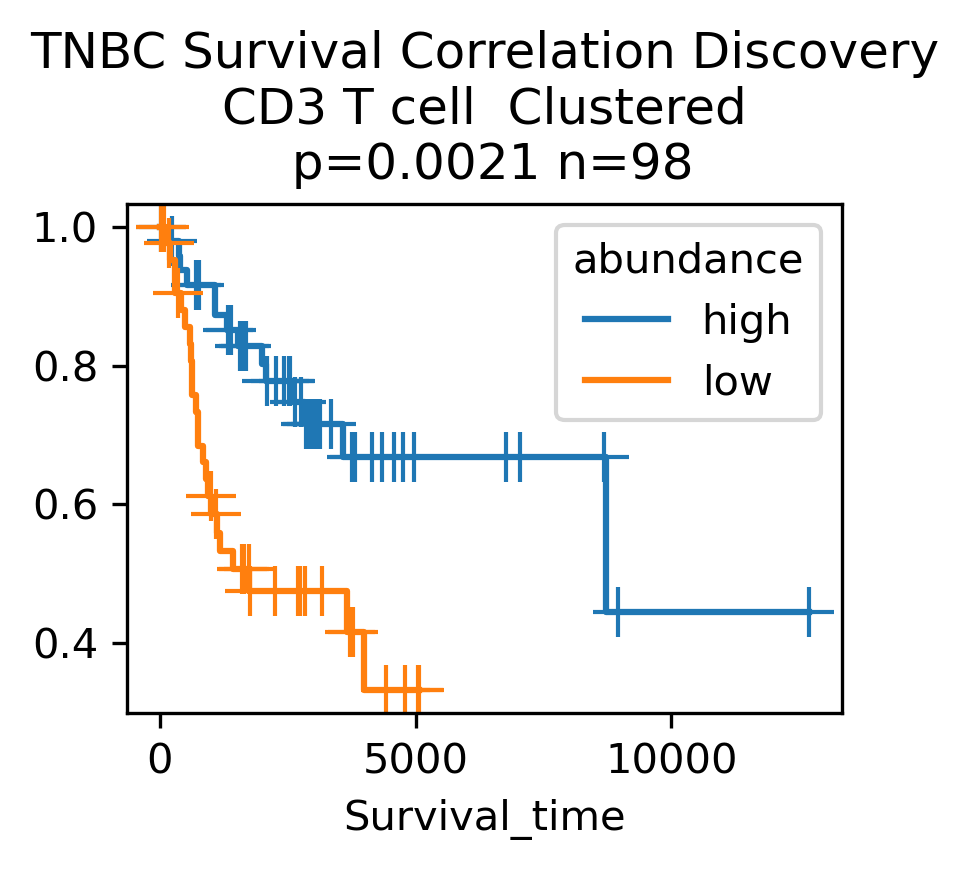

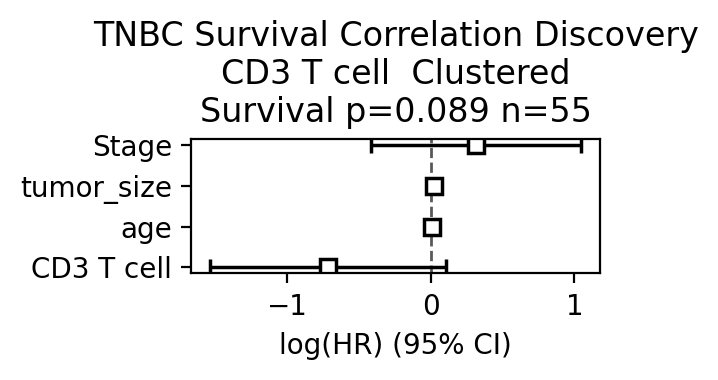

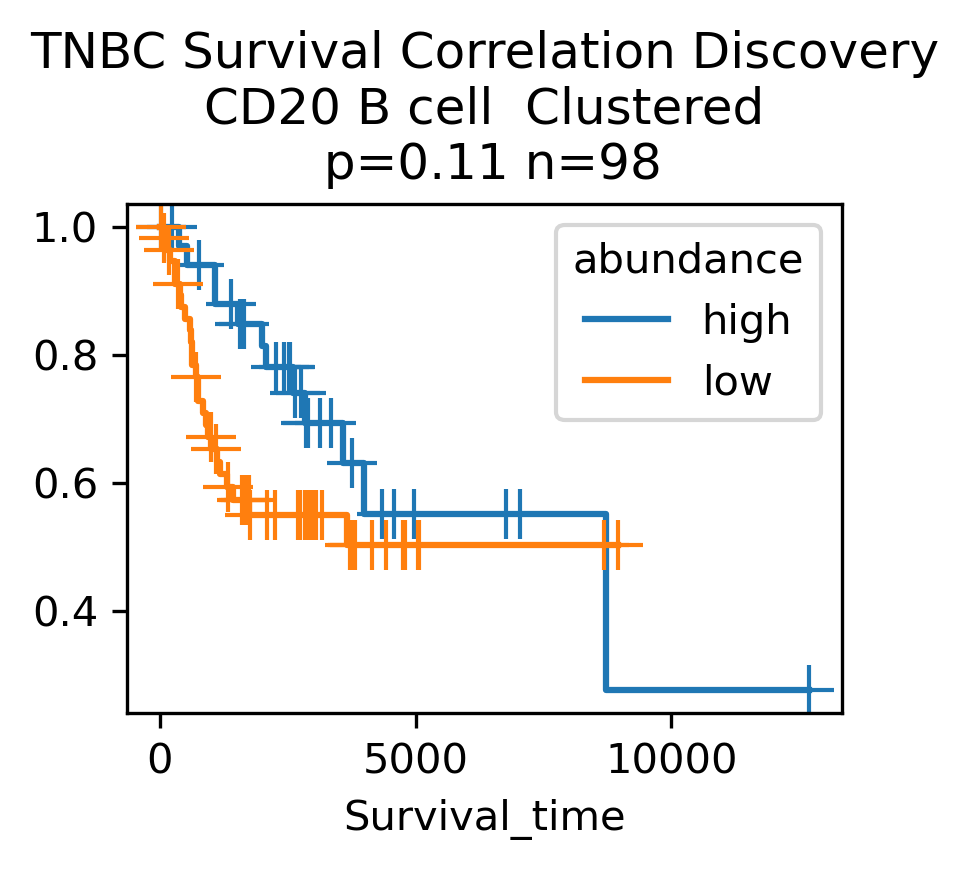

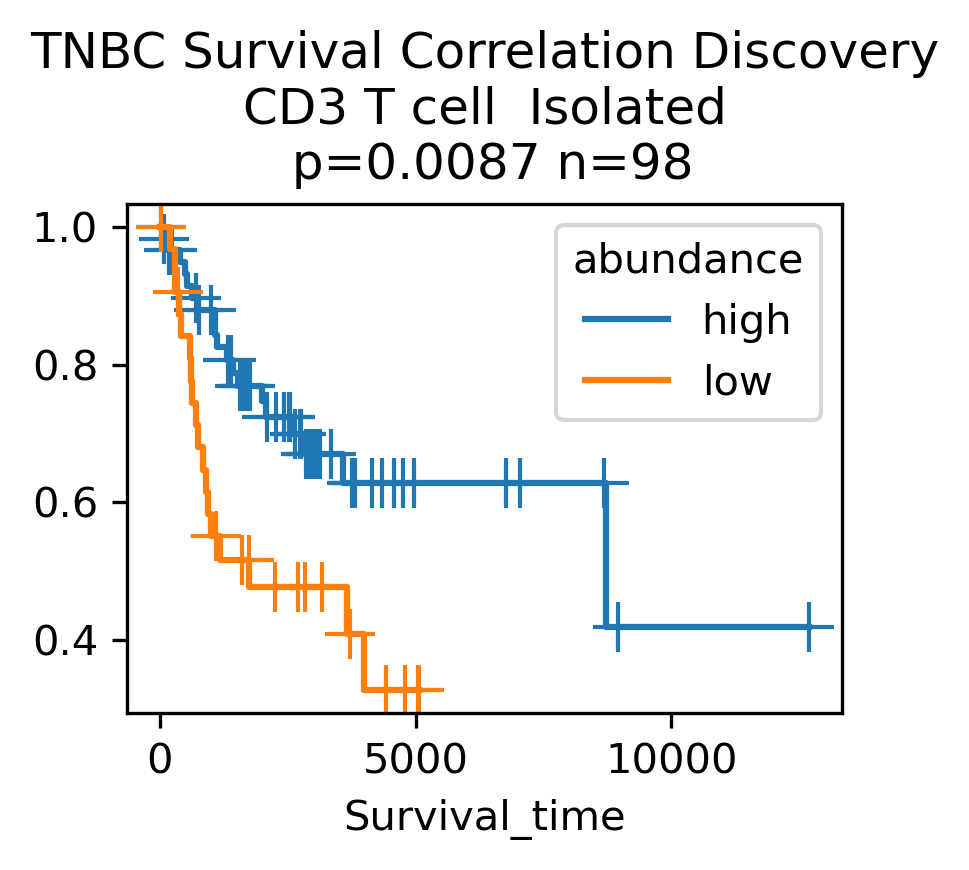

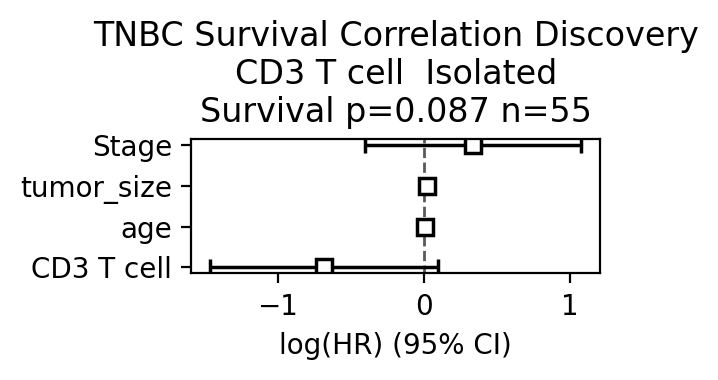

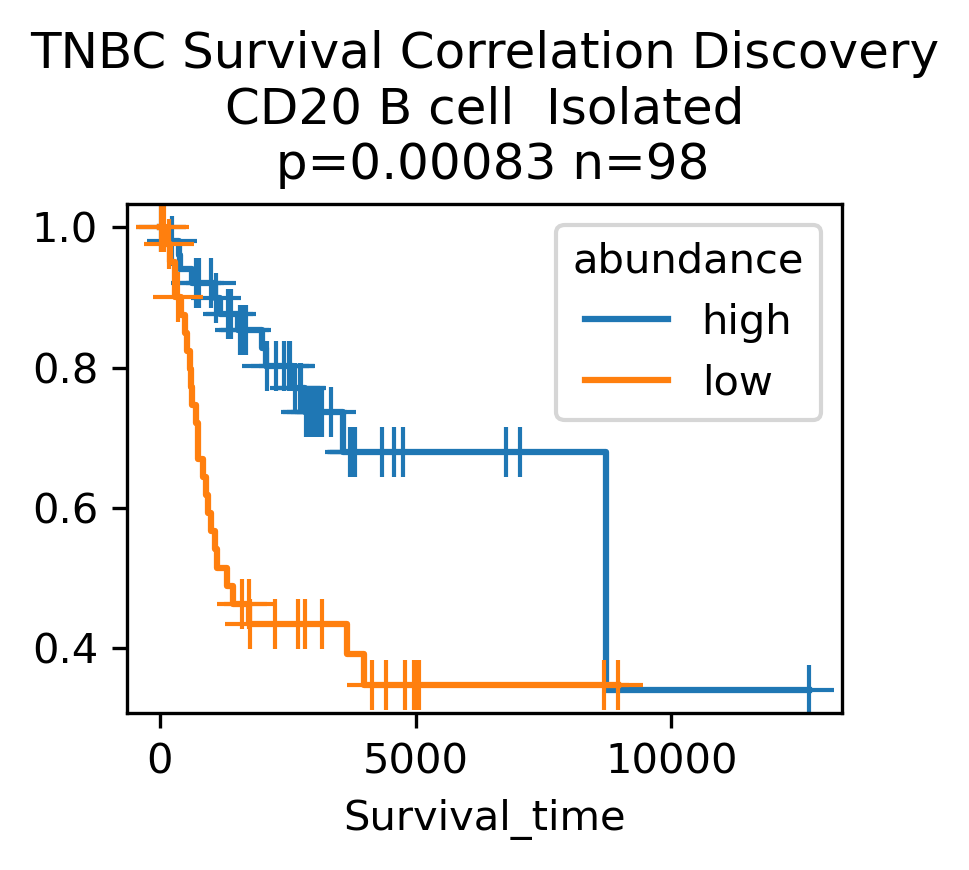

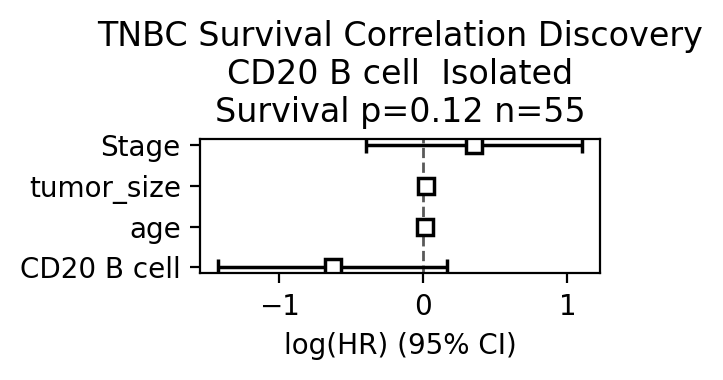

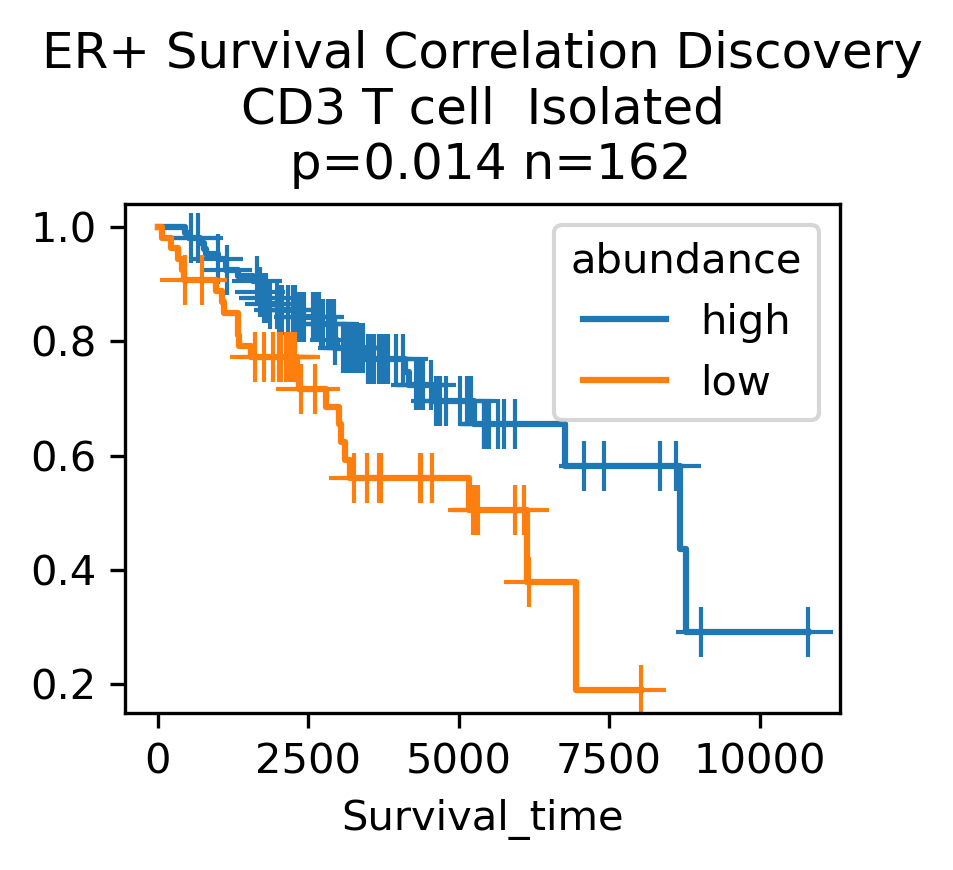

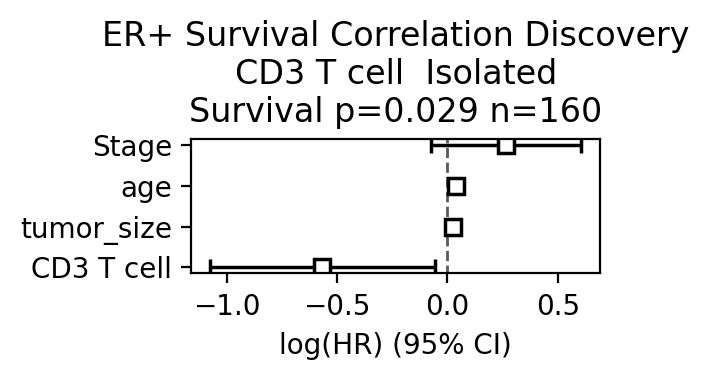

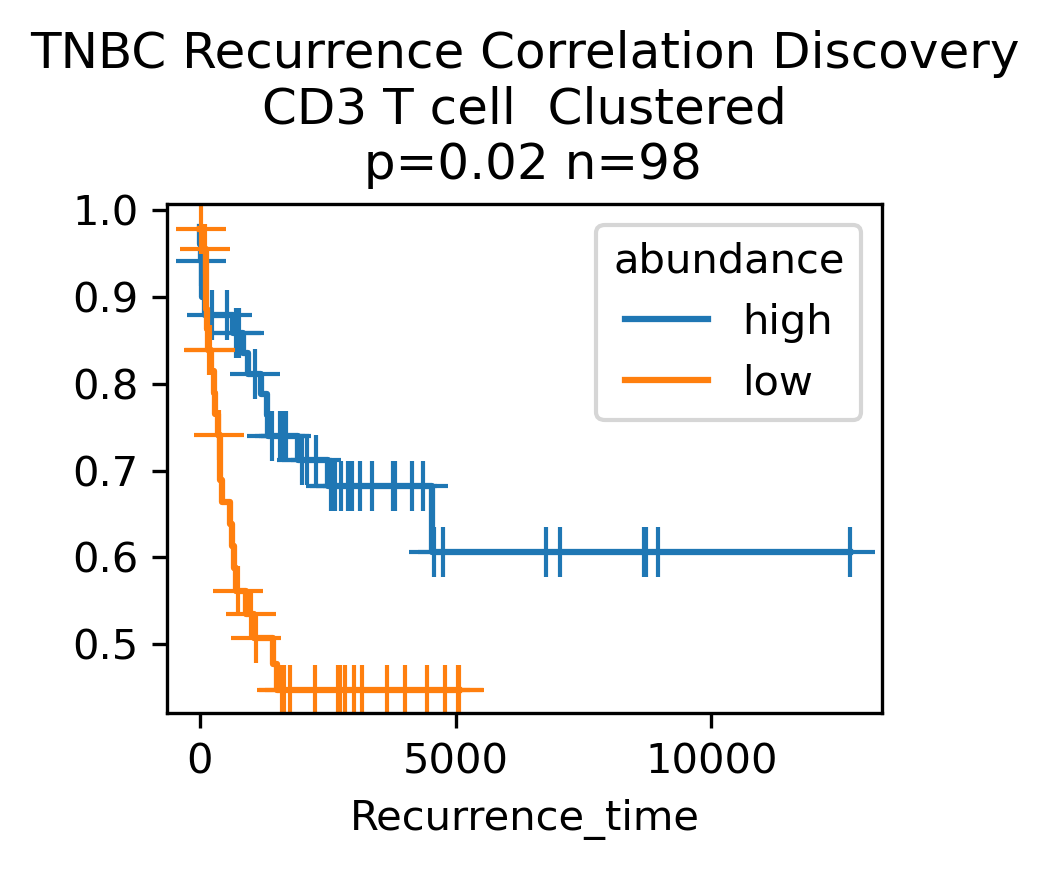

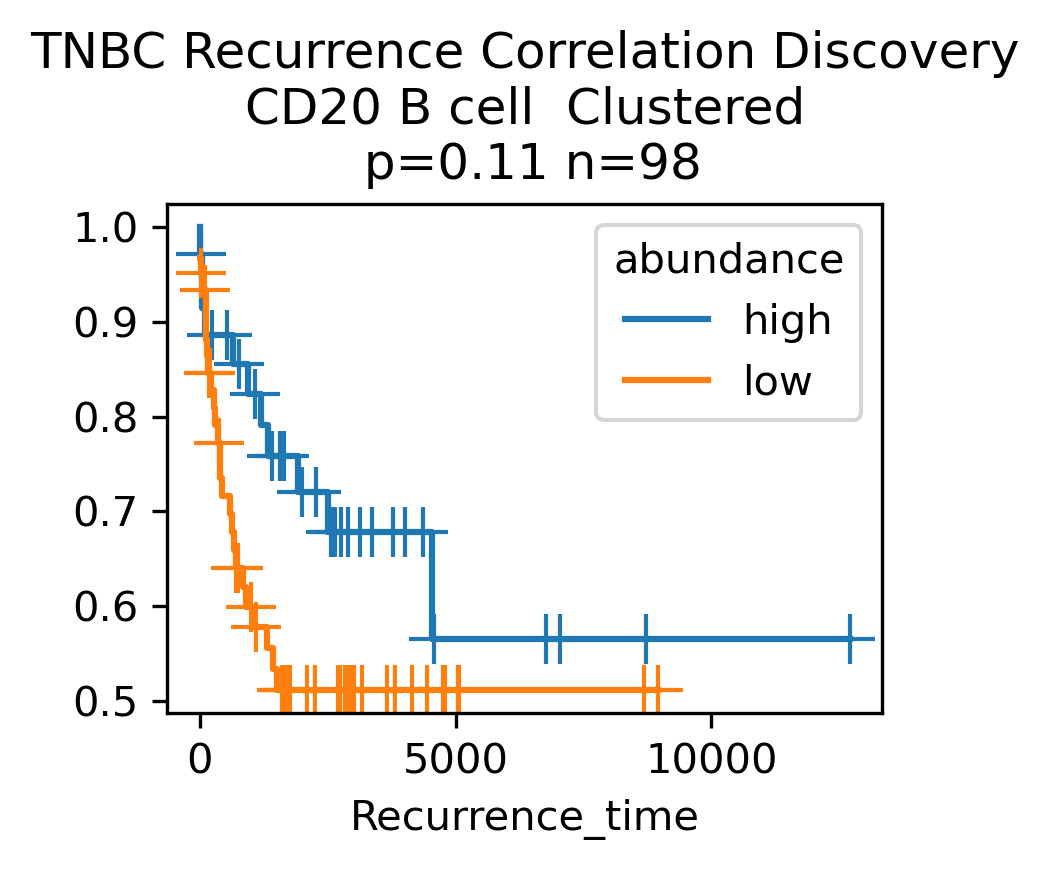

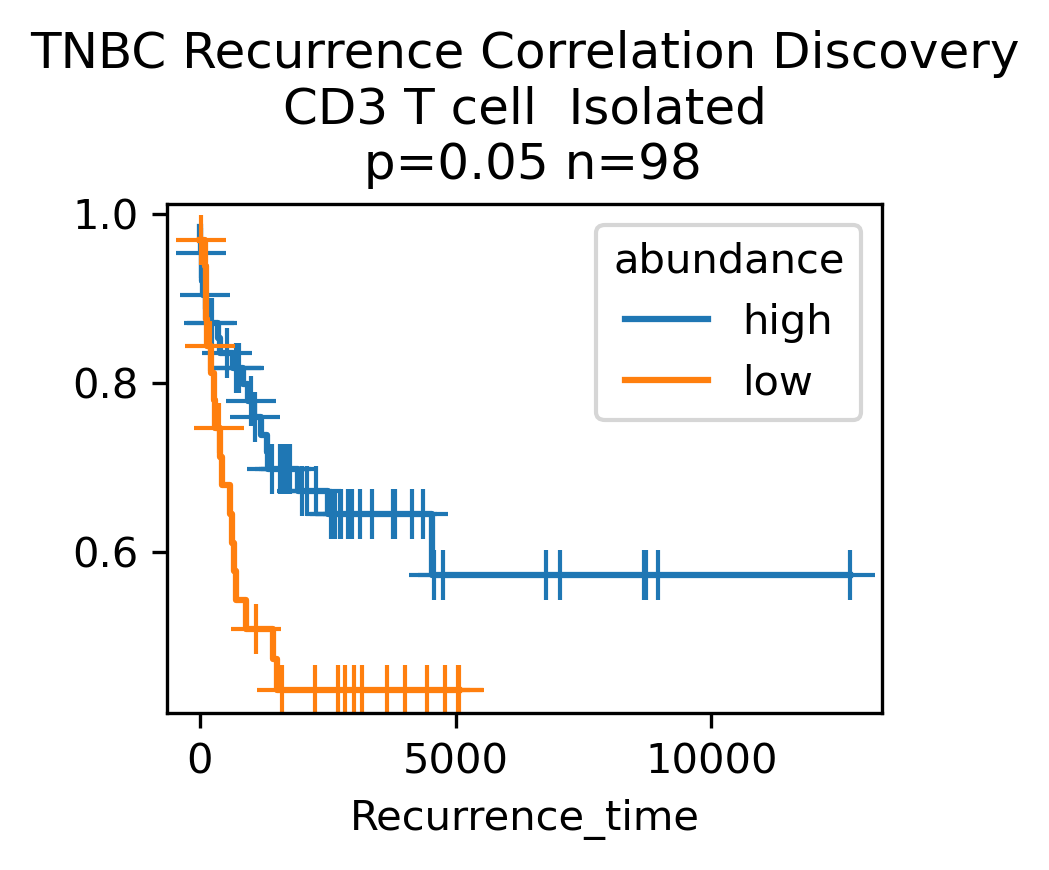

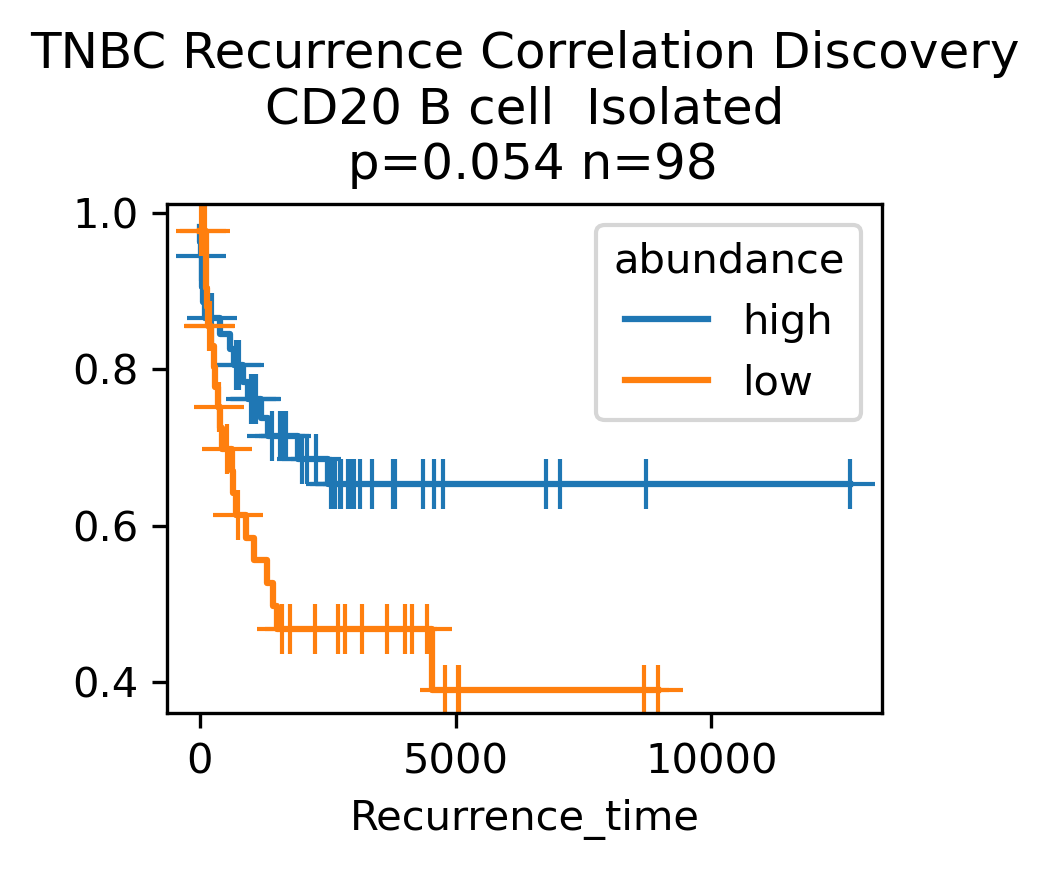

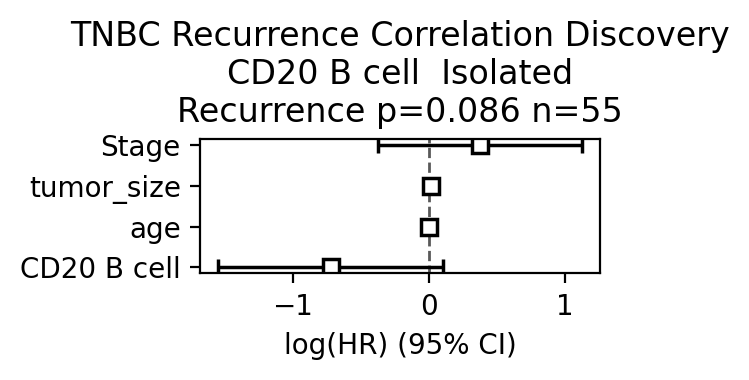

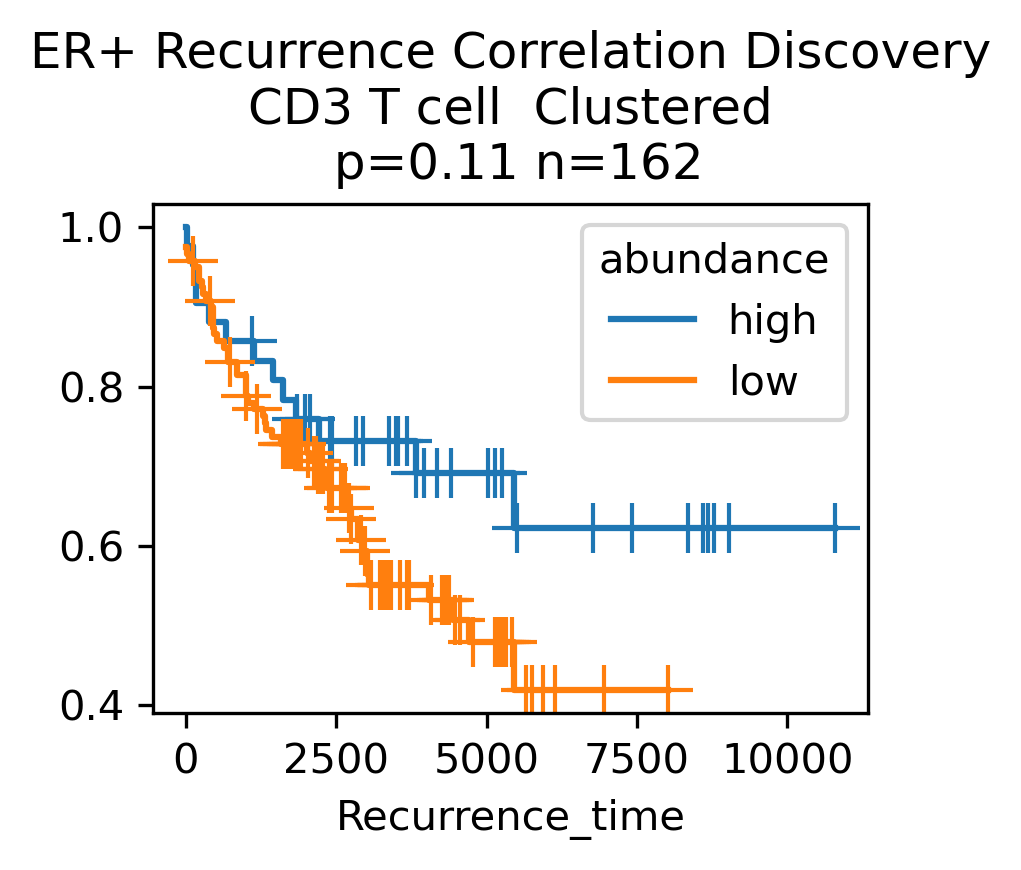

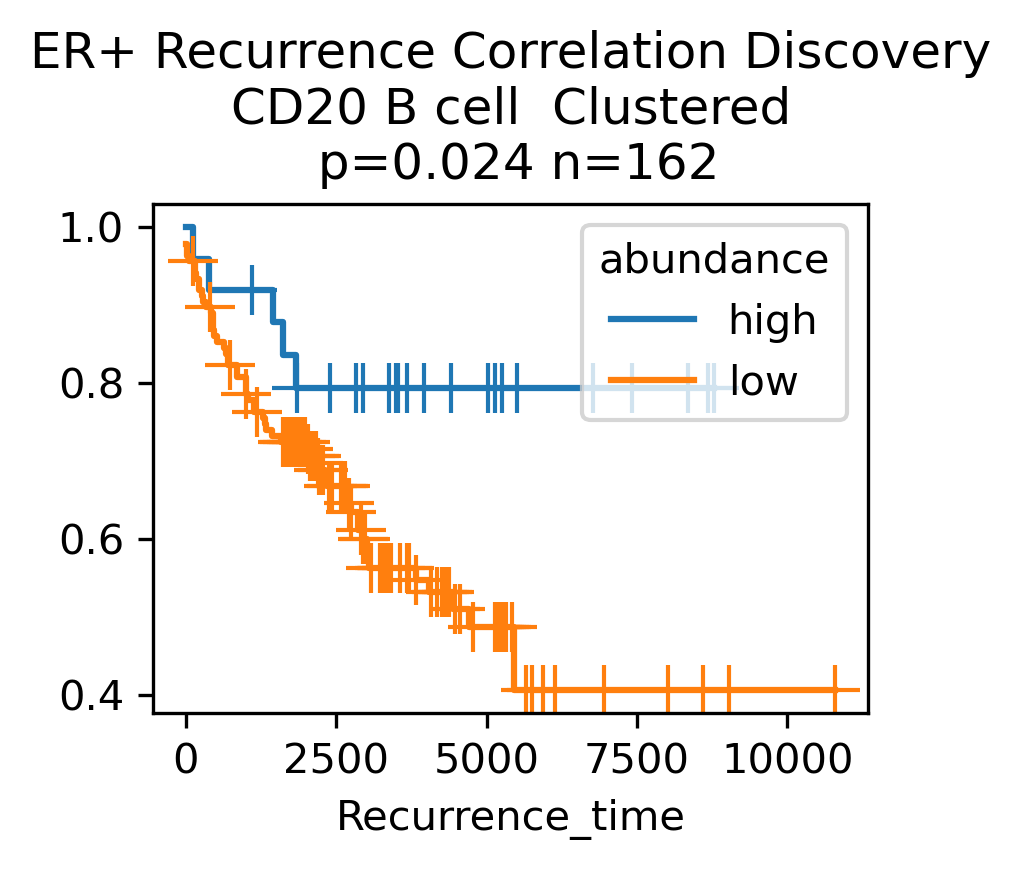

In [27]:
# lymphocyte clusters versus isolated
import importlib
importlib.reload(util)

alpha = 0.15
lls_time = [('Survival_time', 'Survival'),
            ('Recurrence_time', 'Recurrence')]
df_both_all = pd.DataFrame()
dd_discover = {}
d_validate = {'TNBC': ['CD3 T cell_Isolated_0.33',#'CD20 B cell_Isolated_0.33','CD20 B cell_Clustered_0.33'
                      'CD3 T cell_Clustered_0.33',],
             'ER+':['CD3 T cell_Isolated_0.33',#'CD20 B cell_Isolated_0.33','CD3 T cell_Clustered_0.33','CD20 B cell_Clustered_0.33'
                   ]}

ls_all = []        
for s_center in ['Clustered','Isolated']:
    for s_col in ['CD3 T cell', 'CD20 B cell']:
        ls_all.append(f'{s_col}_{s_center}')
        
d_discovery = {#'Discovery':['cycIF'], #
               #'Validation':['IMC','MIBI','cycIF2'], 
               #'Clinical':['IMC','MIBI','cycIF2','cycIF'],
    'Correlation Discovery':['IMC','MIBI','cycIF2','cycIF']
              }

for s_discovery, ls_plat in d_discovery.items():
    for s_time, s_censor in lls_time:
        for s_subtype in ['TNBC','ER+',]: #,
            if s_discovery == 'Discovery':
                ls_cut =[0.33,0.5,0.66]
            elif s_discovery == 'Correlation Discovery': 
                ls_cut =[0.33]
            else:
                ls_all = d_validate[s_subtype]
                ls_cut = [1]
            print(ls_all)
            for cut_p in ls_cut: ##added
                d_data = {}
                ls_pval = []
                for s_col_center in ls_all:
                    #print(s_col_center)
                    s_col = s_col_center.split('_')[0]
                    s_center = s_col_center.split('_')[1]
                    try:
                        cut_p = float(s_col_center.split('_')[2])
                    except:
                        pass
                    df_both=pd.DataFrame()
                    for s_plat in ls_plat:
                        df_count = df.loc[((df.leiden_CD3==s_col) & (df.Platform==s_plat) & (df.LC==s_center)),['Patient','subtype']].groupby('Patient').count()
                        df_div = df.loc[((df.Platform==s_plat)),['Patient','subtype']].groupby('Patient').count()
                        df_mean = (df_count/df_div).rename({'subtype':s_col},axis=1)
                        df_mean.index = df_mean.index.astype('str')
                        df_mean = df_mean.fillna(0) #zero isolated or clustered is lower than some
                        df_sub = df_mean.merge(df_surv,left_index=True,right_index=True,suffixes=('_c',''))
                        if s_subtype == 'All':
                            df_sub['subtype'] = 'All'
                        df_p = util.single_km(df_sub,s_center,s_subtype,s_plat,s_col,savedir = f'{s_date}',alpha=0.000001,
                                cutp=cut_p,s_time=s_time,s_censor=s_censor,s_propo='')
                        df_both=pd.concat([df_both,df_p])
                    df_both['level1'] = s_center #level1 is center
                    df_both['level2'] = s_col #level2 is target
                    df_both['level3'] = cut_p #level3 quantile
                    #log rank
                    try:
                        results = multivariate_logrank_test(event_durations=df_both.loc[:,s_time],
                                                        groups=df_both.abundance, event_observed=df_both.loc[:,s_censor])
                        ls_pval.append(results.summary.p[0])
                    except:
                        ls_pval.append(1)
                    d_data.update({f'{s_col}_{s_center}_{cut_p}':df_both})
                    if s_discovery == 'Correlation Discovery':
                        df_both_all = pd.concat([df_both_all,(df_both.rename({s_col:'mean_neighbors'},axis=1))])
                #run multiple test correction
                d_orig,d_correct,d_result = util.run_multi_test(d_data,df_clin,ls_pval,s_discovery,s_subtype,s_censor,s_time,alpha,s_propo='',
                   s_center_column='leiden',savedir=f'{codedir}/{s_date}/Survival_Plots')
                dd_discover.update({f'{s_subtype}_{s_censor}_{cut_p}':d_orig})
                #cut_p
            #break #subtype
        #break #surv/recur
    #break #discovery
    
for key, d_item in dd_discover.items():
    for key2, item in d_item.items():
        if item < alpha:
            print(f'{key} {key2}')

In [20]:
#util.run_multi_test?e
s_date

'20240904'

In [ ]:

if s_discovery == 'Correlation Discovery':
    d_spatial.update({'LC':df_both_all.rename({'mean_neighbors':'value'},axis=1)})

    d_spatial['LC']

In [ ]:
'''
#plot  spatially 
import matplotlib as mpl
k = 'spatial_aggregate'
for s_slide in ls_slide:
    s_slide = 'JP-TMA1-1_scene034' #s_slide = 'JP-TMA1-1_scene044'#
    print(s_slide)
    fig,ax = plt.subplots(figsize=(5,3.8),dpi=200)
    #plot negative cells
    df_scene = adata_lda.obs[adata_lda.obs.imageid==s_slide]
    ax.scatter(x=df_scene.X_centroid.astype('float'),y=df_scene.Y_centroid.astype('float'),color='lightgray',s=0.2,label=f'_ ')
    for idxs, s_color in enumerate((df_scene.loc[:,f'{k}'].unique())):
        if not s_color == '__non-significant':
            ls_index = df_scene[df_scene.loc[:,f'{k}'] == s_color].index
            if len(df_scene[df_scene.index.isin(ls_index)])>=300:
                df_color = df_scene[df_scene.index.isin(ls_index)]
                ax.scatter(x=df_color.X_centroid.astype('float'),y=df_color.Y_centroid.astype('float'),
                            label=f'{s_color}',s=0.2,color=mpl.cm.tab10.colors[idxs])
        
    ax.set_title(f"{s_slide}", fontsize=16)
    ax.axis('equal')
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
'''

## Ripleys K <a name="kest"></a>

cycIF_ROI_Kcross.csv

cycIF_ROI_Kest

[contents](#contents)

In [ ]:
#load spatstat corrected
s_sample = 'cycIF'
df_rip = pd.read_csv(f'{codedir}/data/{s_sample}_ROI_Kest.csv')
df_rip['Patient'] = df_rip.slide_scene.map(dict(zip(df_lei_both.slide_scene,df_lei_both.Patient)))
df_rip['K_correct'] = df_rip.iso - df_rip.theo
df_rip['r'] = df_rip.r*.325

#mibi and IMC
#load spatstat corrected
s_sample = 'IMC-MIBI'#'IMC_MIBI'
df_rip2 = pd.read_csv(f'{codedir}/data/{s_sample}_ROI_Kest.csv') #ripleys_k.csv
df_rip2['Patient'] = df_rip2.slide_scene.map(dict(zip(df_lei_both.slide_scene,df_lei_both.Patient)))
df_rip2['K_correct'] = df_rip2.iso - df_rip2.theo
df_rip = pd.concat([df_rip,df_rip2])
#df.loc[df.index.str.contains('JP-TMA2'),'Platform'] = 'cycIF2'
s_cell ='tumor'
df_rip['r'] = np.around(df_rip.r, decimals=2)
df_r = df_rip[df_rip.cell==s_cell].groupby('Patient').apply(lambda x: (np.quantile(x.loc[:,'r'],0.25),
                        np.quantile(x.loc[:,'r'],0.5),np.quantile(x.loc[:,'r'],0.75)))
a_r = df_r.iloc[0]
a_r = np.around(a_r, decimals=2)

In [ ]:
# rip L ()
df_rip['L'] = np.sqrt((df_rip.iso/np.pi))
dd_discover = {}
alpha = 0.2
lls_time = [('Survival_time', 'Survival'), ('Recurrence_time', 'Recurrence')]
s_group = 'Subtype_prolif'
df_both_all = pd.DataFrame()

i_r = 50
d_discovery = {#'Discovery':['cycIF'],
               #'MIBI':['MIBI'],
               #'Validation':['IMC','MIBI','cycIF2'], 
               #'Clinical':['IMC','MIBI','cycIF2','cycIF'],
              'Correlation Discovery':['IMC','MIBI','cycIF2','cycIF']
            }

s_median = 'Subtype_prolif'
d_validate = {'TNBC':['tumor_0.66'],#'endothelial_0.5'
              'ER+':['Quies. str._0.66']}
ls_agg = ['tumor', 'Vim+ FB', 'Quies. str.', 'endothelial', 
       'CD3 T cell', 'Macrophage', 'CD20 B cell',
        'CD8 T cell', 'CD4 T cell'] #df_rip.cell.unique()
s_col = 'L'
for s_discovery, ls_plat in d_discovery.items():
    for s_time, s_censor in lls_time:
        for s_subtype in ['TNBC','ER+',]:
            if s_discovery=='Discovery':
                ls_cut_p = [0.33,0.5,0.66]
            elif s_discovery == 'Correlation Discovery': 
                ls_cut_p =[0.5]
            else:
                ls_agg = d_validate[s_subtype]
                ls_cut_p = [1]
            ls_pval = []
            d_data = {}
            for s_center in ls_agg:
                for cut_p in ls_cut_p:
                    if not (s_discovery == 'Discovery') | (s_discovery == 'Correlation Discovery'):
                        cut_p = s_center.split('_')[1]
                        print(cut_p)
                        s_center = s_center.split('_')[0]
                    d_mean = {}
                    for s_plat in ls_plat:
                        if s_plat == 'cycIF':
                            df_sample = df_rip[df_rip.slide_scene.str.contains('JP-TMA1')]
                        elif s_plat == 'cycIF2':
                            df_sample = df_rip[df_rip.slide_scene.str.contains('JP-TMA2')]
                        elif s_plat == 'IMC':
                            df_sample = df_rip[~df_rip.slide_scene.str.contains('scene')]
                        elif s_plat =='MIBI':
                            df_sample = df_rip[(df_rip.slide_scene.str.contains('scene')) & (~df_rip.slide_scene.str.contains('JP-TMA'))]
                        df_mean_all = df_sample[(df_sample.cell==s_center) & (df_sample.r==i_r)].groupby(['r','Patient']).mean(numeric_only=True).reset_index()
                        df_mean_all['Subtype_prolif'] = df_mean_all.Patient.astype('str').map(d_sub_prolif)
                        df_mean = df_mean_all[~df_mean_all.loc[:,s_median].isna()]
                        df_mean.set_index('Patient',inplace=True)
                        d_mean.update({s_plat:df_mean})
                    df_both=pd.DataFrame()
                    for s_plat in ls_plat:
                        df_sub = d_mean[s_plat][d_mean[s_plat].Subtype_prolif.str.contains(s_subtype)]
                        df_sub = df_sub.merge(df_surv,left_index=True,right_index=True)
                        df_sub['Platform'] = s_plat
                        df_p = util.single_km(df_sub,s_center,s_subtype,s_plat,s_col,savedir = f'{s_date}',alpha=0.000001,
                                cutp=0.5,s_time=s_time,s_censor=s_censor,s_propo='Ripleys')
                        df_both=pd.concat([df_both,df_p])
                    df_both['level1'] = s_center #level1 is ripleys l  cell type
                    #log rank
                    try:
                        results = multivariate_logrank_test(event_durations=df_both.loc[:,s_time],
                                                        groups=df_both.abundance, event_observed=df_both.loc[:,s_censor])
                        ls_pval.append(results.summary.p[0])
                    except:
                        ls_pval.append(1)
                    d_data.update({f'{s_center}':df_both})
                    if s_discovery == 'Correlation Discovery':
                        df_both_all = pd.concat([df_both_all,(df_both.rename({s_col:'mean_neighbors'},axis=1))])
            #run multiple test correction
            if len(ls_pval) > 1:
                reject, corrected, __, __ = statsmodels.stats.multitest.multipletests(ls_pval,method='fdr_bh')# #'fdr_bh'
                d_correct = dict(zip(d_data.keys(),corrected))
            else:
                d_correct = dict(zip(d_data.keys(),ls_pval))
            d_orig = dict(zip(d_data.keys(),ls_pval))
            ls_pval_cph = []
            ls_cph_markers = []
            for s_center, p_correct in d_correct.items():
                pvalue = d_orig[s_center]
                if s_discovery == 'Discovery':
                    p_correct_used=None
                else:
                    p_correct_used=p_correct
                if pvalue < 0.9:
                    df_both_surv = d_data[s_center]
                    #cool plotting function for all platforms
                    s_title1 = f'{s_subtype} {s_censor} {s_discovery}'
                    s_title2 = f'{s_center} Ripleys L r={i_r} {cut_p}'
                    fig1, fig2, pval_cph, __ = util.km_cph_all(df_both_surv,df_clin,s_title1,s_title2,s_col,alpha=alpha,s_time=s_time, s_censor=s_censor,
                           s_groups='abundance',s_cph_model='high',ls_clin=['age','tumor_size','Stage'],p_correct=p_correct_used)
                    if not fig1 is None:
                        continue
                        #fig1.savefig(f"{codedir}/{s_date}/Survival_Plots/KM_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}_{cut_p}.png",dpi=300)
                    if not fig2 is None:
                        continue
                        #fig2.savefig(f"{codedir}/{s_date}/Survival_Plots/CPH_{s_title1.replace(' ','_')}_{s_title2.replace(' ','_')}_{cut_p}.png")
                    ls_pval_cph.append(pval_cph)
                    ls_cph_markers.append(s_center)
            try:
                reject2, corrected2, __, __ = statsmodels.stats.multitest.multipletests(ls_pval_cph,alpha=0.1,method='fdr_bh')
                print(f'{s_discovery} {s_subtype}')
                [print(f'{ls_cph_markers[idx]} {corrected2[idx]}') for idx,item in enumerate(reject2) if item]
            except:
                print('')
                df_both_all = pd.concat([df_both_all,(df_both.rename({s_col:'mean_neighbors'},axis=1))]) #save to d_spatial: d_spatial.update({'mixing_score':df_both_all})
            dd_discover.update({f'{s_subtype}_{s_censor}_{cut_p}':d_orig})
            break #subtype
        break #surv/recur
    break #discovery


In [ ]:
if s_discovery == 'Correlation Discovery':
    d_spatial.update({'ripleys_l':df_both_all.rename({'mean_neighbors':'value'},axis=1)})
    d_spatial['ripleys_l']

## K cross  <a name="kcross"></a>

[contents](#contents)

ripleys K between two cell types

In [ ]:
#load spatstat Kcross
s_sample = 'cycIF'
s_stat = 'Kcross'
#ls_kcross = ['JP-TMA1_first','JP-TMA1_second','JP-TMA1_100s','JP-TMA2']
#df_rip = pd.DataFrame()
#for s_cross in ls_kcross:
#    df_rip = pd.concat([df_rip,(pd.read_csv(f'{codedir}/data/{s_sample}_{s_cross}_{s_stat}.csv'))])
df_rip = pd.read_csv(f'{codedir}/data/cycIF_ROI_Kcross.csv')
df_rip['Patient'] = df_rip.slide_scene.map(dict(zip(df_lei_both.slide_scene,df_lei_both.Patient)))
df_rip['Kcross'] = df_rip.iso - df_rip.theo
df_rip['r'] = df_rip.r*.325

#mibi and IMC
#load spatstat corrected
s_sample = 'IMC-MIBI'
df_rip2 = pd.read_csv(f'{codedir}/data/{s_sample}_ROI_{s_stat}.csv')
df_rip2['Patient'] = df_rip2.slide_scene.map(dict(zip(df_lei_both.slide_scene,df_lei_both.Patient)))
df_rip2['Kcross'] = df_rip2.iso - df_rip2.theo
df_rip = pd.concat([df_rip,df_rip2]) #'''

df_rip['r'] = np.around(df_rip.r, decimals=2)
a_r = np.array([25., 50., 75.])
df_rip['leiden'] = df_rip.to_cell + '-' + df_rip.from_cell 

In [ ]:
# for s_slide in ['JP-TMA1-1_scene034','JP-TMA2-1_scene18','JP-TMA2-1_scene10','JP-TMA2-1_scene05']:
#     df_plot = df_rip[(df_rip.from_cell=='tumor') & (df_rip.to_cell=='Macrophage') & (df_rip.slide_scene==s_slide)]
#     fig, ax = plt.subplots(figsize=(4,3))
#     df_plot.plot(x='r',y='iso',ax=ax,label='observed')
#     df_plot.plot(x='r',y='theo',ax=ax,label='theoretical')
#     ax.set_title(s_slide)
#     #break

In [ ]:
# add platform
for s_plat in ['IMC','MIBI','cycIF2','cycIF']:
    if s_plat == 'cycIF':
        df_sample = df_rip[df_rip.slide_scene.str.contains('JP-TMA1')]
    elif s_plat == 'cycIF2':
        df_sample = df_rip[df_rip.slide_scene.str.contains('JP-TMA2')]
    elif s_plat == 'IMC':
        df_sample = df_rip[~df_rip.slide_scene.str.contains('scene')]
    elif s_plat =='MIBI':
        df_sample = df_rip[(df_rip.slide_scene.str.contains('scene')) & (~df_rip.slide_scene.str.contains('JP-TMA'))]
    df_rip.loc[df_rip.Patient.isin(df_sample.Patient),'Platform'] = s_plat
    
df_rip['subtype'] = df_rip.Patient.map(dict(zip(df_surv.index,df_surv.subtype)))
df_rip.rename({'iso':'K cross'},axis=1,inplace=True)
df_rip.head()

In [ ]:
# K cross. nothing is significant
alpha = 0.05
lls_time = [('Survival_time', 'Survival'), ('Recurrence_time', 'Recurrence')]
s_group = 'Subtype_prolif'
df_both_all = pd.DataFrame()
dd_discover = {}
d_validate = {'TNBC':['K cross_Quies. str.-CD3 T cell_0.33',
                      'K cross_CD20 B cell-CD3 T cell_0.66',
                      'K cross_Vim+ FB-CD3 T cell_0.66',
                      'K cross_Macrophage-tumor_0.5'
                     ],
              'ER+':['K cross_Vim+ FB-CD3 T cell_0.33',
                     'K cross_Quies. str.-tumor_0.5'
                    ]}
#set radius      
i_r = 50.0
df = df_rip[df_rip.r==i_r]

ls_all = []        
for s_center in ['tumor','CD3 T cell']:
    for s_col in ['CD20 B cell','tumor','Vim+ FB', 'Quies. str.', 'Macrophage', 'endothelial', 'CD3 T cell']: #'CD4 T cell', 'CD8 T cell', 'FN+ FB',
        ls_all.append(f'K cross_{s_col}-{s_center}')
d_discovery = {#' Discovery':['cycIF'],
               #'Validation':['IMC','MIBI','cycIF2'], 
               #'Clinical':['IMC','MIBI','cycIF2','cycIF']
               'Correlation Discovery':['IMC','MIBI','cycIF2','cycIF']
              }
for s_discovery, ls_plat in d_discovery.items():
    for s_time, s_censor in lls_time:
        for s_subtype in ['ER+','TNBC']:
            if s_discovery == 'Discovery':
                ls_cut =[0.33,0.5,0.66]
            elif s_discovery == 'Correlation Discovery': 
                ls_cut =[0.5]
            else:
                ls_all = d_validate[s_subtype]
                ls_cut = [1]
            for cut_p in ls_cut: ##added
                d_data = {}
                ls_pval = []
                for s_col_center in ls_all:
                    #print(s_col_center)
                    s_col = s_col_center.split('_')[0]
                    s_center = s_col_center.split('_')[1]
                    try:
                        cut_p = float(s_col_center.split('_')[2])
                    except:
                        pass
                    df_both=pd.DataFrame()
                    for s_plat in ls_plat:
                        df_sub = util.make_mean(df,s_plat,s_center,s_subtype,s_col,s_center_column='leiden')
                        df_sub = df_sub.merge(df_surv,left_index=True,right_index=True)
                        df_p = util.single_km(df_sub,s_center,s_subtype,s_plat,s_col,savedir = f'{s_date}',alpha=0.000001,
                                cutp=cut_p,s_time=s_time,s_censor=s_censor,s_propo='')
                        df_both=pd.concat([df_both,df_p])
                    df_both['level1'] = s_center #level1 is center
                    df_both['level2'] = s_col #level2 is target
                    df_both['level3'] = cut_p #level3 quantile
                    #log rank
                    try:
                        results = multivariate_logrank_test(event_durations=df_both.loc[:,s_time],
                                                        groups=df_both.abundance, event_observed=df_both.loc[:,s_censor])
                        ls_pval.append(results.summary.p[0])
                    except:
                        ls_pval.append(1)
                    d_data.update({f'{s_col}_{s_center}_{cut_p}':df_both})
                    if s_discovery == 'Correlation Discovery':
                        df_both_all = pd.concat([df_both_all,(df_both.rename({s_col:'mean_neighbors'},axis=1))])
                #run multiple test correction
                d_orig,d_correct,d_result = util.run_multi_test(d_data,df_clin,ls_pval,s_discovery,s_subtype,s_censor,s_time,alpha,s_propo='',
                   s_center_column='leiden',savedir=f'{codedir}/{s_date}/Survival_Plots')
                dd_discover.update({f'{s_subtype}_{s_censor}_{cut_p}':d_orig})
                #cut_p
            #break #subtype
        break #surv/recur
    break #discovery
    
for key, d_item in dd_discover.items():
    for key2, item in d_item.items():
        if item < alpha:
            print(f'{key} {key2}')

In [ ]:
if s_discovery == 'Correlation Discovery':
    d_spatial.update({'Kcross':df_both_all.rename({'mean_neighbors':'value'},axis=1)})
    d_spatial['Kcross']

### Occupancy <a name="nolan"></a>

[contents](#contents)



In [ ]:
#
df_rip = pd.read_csv(f'{codedir}/data/cycIF_ROI_Occ.csv')
df_rip2 = pd.read_csv(f'{codedir}/data/IMC-MIBI_ROI_Occ.csv')
df_rip = pd.concat([df_rip,df_rip2])
df_rip.rename({'unlist.result_table.':'Occ','Unnamed: 0':'cellnum'},axis=1,inplace=True)
df_rip['cell'] = [item.split('_')[0] for item in df_rip.cellnum]
df_rip['num'] = [item.split('_')[1] for item in df_rip.cellnum]
df_rip['Occupancy'] = df_rip.Occ > 0
df_rip['Patient'] = df_rip.slide_scene.map(dict(zip(df_lei_both.slide_scene,df_lei_both.Patient)))

In [ ]:
for s_plat in ['IMC','MIBI','cycIF2','cycIF']:
    if s_plat == 'cycIF':
        df_sample = df_rip[df_rip.slide_scene.str.contains('JP-TMA1')]
    elif s_plat == 'cycIF2':
        df_sample = df_rip[df_rip.slide_scene.str.contains('JP-TMA2')]
    elif s_plat == 'IMC':
        df_sample = df_rip[~df_rip.slide_scene.str.contains('scene')]
    elif s_plat =='MIBI':
        df_sample = df_rip[(df_rip.slide_scene.str.contains('scene')) & (~df_rip.slide_scene.str.contains('JP-TMA'))]
    df_rip.loc[df_rip.Patient.isin(df_sample.Patient),'Platform'] = s_plat
    
df_rip['subtype'] = df_rip.Patient.map(dict(zip(df_surv.index,df_surv.subtype)))

In [ ]:
#calculate occupancy per cell type per patient
df_mean = df_rip.groupby(['Patient','cell']).Occupancy.value_counts(normalize=True).unstack().loc[:,True].unstack()
df_mean = df_mean.fillna(0) #careful, some cells not present in all cohorts. B and T cells are. Don't run step if analyzing other cell types
df_mean = df_mean.merge(df_surv,left_index=True,right_index=True)


In [ ]:
# occupancy
alpha = 0.1
lls_time = [('Survival_time', 'Survival'),
            ('Recurrence_time', 'Recurrence')]
s_group = 'Subtype_prolif'
df_both_all = pd.DataFrame()
dd_discover = {}
d_validate = {'TNBC':['CD3 T cell_Occupancy_0.33','CD20 B cell_Occupancy_0.33'],
              'ER+':['CD3 T cell_Occupancy_0.33','CD20 B cell_Occupancy_0.33']
             }

ls_all = []        
for s_center in ['CD20 B cell', 'CD3 T cell']:
    ls_all.append(f'{s_center}_Occupancy')
d_discovery = {#'Discovery':['cycIF'],
               #'Validation':['IMC','MIBI','cycIF2'], 
               #'Clinical':['IMC','MIBI','cycIF2','cycIF']
    'Correlation Discovery':['IMC','MIBI','cycIF2','cycIF']
              }
for s_discovery, ls_plat in d_discovery.items():
    for s_time, s_censor in lls_time:
        for s_subtype in ['ER+','TNBC']:
            if s_discovery == 'Discovery':
                ls_cut =[0.33,0.5,0.66]
            elif s_discovery == 'Correlation Discovery': 
                ls_cut =[0.5]
            else:
                ls_all = d_validate[s_subtype]
                ls_cut = [1]
            for cut_p in ls_cut: ##added
                d_data = {}
                ls_pval = []
                for s_col_center in ls_all:
                    #print(s_col_center)
                    s_col = s_col_center.split('_')[0]
                    s_center = s_col_center.split('_')[1]
                    try:
                        cut_p = float(s_col_center.split('_')[2])
                    except:
                        pass
                    df_both=pd.DataFrame()
                    for s_plat in ls_plat:
                        #df_sub = make_mean(df,s_plat,s_center,s_subtype,s_col,s_center_column='leiden')
                        df_sub = df_mean[(df_mean.subtype==s_subtype) & (df_mean.Platform==s_plat)]
                        df_p = util.single_km(df_sub,s_center,s_subtype,s_plat,s_col,savedir = f'{s_date}',alpha=0.000001,
                                cutp=cut_p,s_time=s_time,s_censor=s_censor,s_propo='')
                        df_both=pd.concat([df_both,df_p])
                    df_both['level1'] = s_center #level1 is center
                    df_both['level2'] = s_col #level2 is target
                    df_both['level3'] = cut_p #level3 quantile
                    #log rank
                    try:
                        results = multivariate_logrank_test(event_durations=df_both.loc[:,s_time],
                                                        groups=df_both.abundance, event_observed=df_both.loc[:,s_censor])
                        ls_pval.append(results.summary.p[0])
                    except:
                        ls_pval.append(1)
                    d_data.update({f'{s_col}_{s_center}_{cut_p}':df_both})
                    if s_discovery == 'Correlation Discovery':
                        df_both_all = pd.concat([df_both_all,(df_both.rename({s_col:'mean_neighbors'},axis=1))])
                #run multiple test correction
                d_orig,d_correct,d_result = util.run_multi_test(d_data,df_clin,ls_pval,s_discovery,s_subtype,s_censor,s_time,alpha,s_propo='',
                   s_center_column='leiden',savedir=f'{codedir}/{s_date}/Survival_Plots')
                dd_discover.update({f'{s_subtype}_{s_censor}_{cut_p}':d_orig})
                #cut_p
            #break #subtype
        break #surv/recur
    break #discovery
    
for key, d_item in dd_discover.items():
    for key2, item in d_item.items():
        if item < alpha:
            print(f'{key} {key2}')

In [ ]:
if s_discovery == 'Correlation Discovery':
    d_spatial.update({'Occupancy':df_both_all.rename({'mean_neighbors':'value'},axis=1)})

    d_spatial['Occupancy']

### G cross <a name="gcross"></a>

similar to neighbor counts

[contents](#contents)



In [ ]:
#load spatstat Kcross
s_sample = 'cycIF'
s_stat = 'Gcross'
#ls_kcross = ['JP-TMA1_first','JP-TMA1_second','JP-TMA1_100s','JP-TMA2']
#df_rip = pd.DataFrame()
#for s_cross in ls_kcross:
#    df_rip = pd.concat([df_rip,(pd.read_csv(f'{codedir}/data/{s_sample}_{s_cross}_{s_stat}.csv'))])
df_rip = pd.read_csv(f'{codedir}/data/{s_sample}_ROI_{s_stat}.csv')
df_rip['Patient'] = df_rip.slide_scene.map(dict(zip(df_lei_both.slide_scene,df_lei_both.Patient)))
df_rip['r'] = df_rip.r*.325

#mibi and IMC
#load spatstat corrected
s_sample = 'IMC-MIBI'
df_rip2 = pd.read_csv(f'{codedir}/data/{s_sample}_ROI_{s_stat}.csv')
df_rip2['Patient'] = df_rip2.slide_scene.map(dict(zip(df_lei_both.slide_scene,df_lei_both.Patient)))
df_rip = pd.concat([df_rip,df_rip2]) #'''

df_rip['r'] = np.around(df_rip.r, decimals=2)
a_r = np.array([25., 50., 75.])
df_rip['leiden'] = df_rip.to_cell + '-' + df_rip.from_cell 

In [ ]:
# add platform
for s_plat in ['IMC','MIBI','cycIF2','cycIF']:
    if s_plat == 'cycIF':
        df_sample = df_rip[df_rip.slide_scene.str.contains('JP-TMA1')]
    elif s_plat == 'cycIF2':
        df_sample = df_rip[df_rip.slide_scene.str.contains('JP-TMA2')]
    elif s_plat == 'IMC':
        df_sample = df_rip[~df_rip.slide_scene.str.contains('scene')]
    elif s_plat =='MIBI':
        df_sample = df_rip[(df_rip.slide_scene.str.contains('scene')) & (~df_rip.slide_scene.str.contains('JP-TMA'))]
    df_rip.loc[df_rip.Patient.isin(df_sample.Patient),'Platform'] = s_plat
    
df_rip['subtype'] = df_rip.Patient.map(dict(zip(df_surv.index,df_surv.subtype)))
df_rip.rename({'km':'Gcross'},axis=1,inplace=True)
df_rip['r'] = round(df_rip.r/10)*10
df_rip.head()

In [ ]:
# G cross - nothing is significant
alpha = 0.05
lls_time = [('Survival_time', 'Survival'), ('Recurrence_time', 'Recurrence')]
s_group = 'Subtype_prolif'
df_both_all = pd.DataFrame()
dd_discover = {}
d_validate = {'TNBC':['Gcross_CD20 B cell-tumor_0.33',
                      'Gcross_CD3 T cell-tumor_0.33',
                      'Gcross_Macrophage-tumor_0.33',
                      'Gcross_Quies. str.-CD3 T cell_0.33'
                     ],
              'ER+':['Gcross_Vim+ FB-CD3 T cell_0.33'
                    ]}
#set radius      
i_r = 50.0
df = df_rip[df_rip.r==i_r]

ls_all = []        
for s_center in ['tumor','CD3 T cell']:
    for s_col in ['CD20 B cell','tumor','Vim+ FB', 'Quies. str.', 'Macrophage', 'endothelial', 'CD3 T cell']: #'tumor','CD4 T cell', 'CD8 T cell', 'FN+ FB',
        ls_all.append(f'Gcross_{s_col}-{s_center}')
d_discovery = {#' Discovery':['cycIF'],
               #'Validation':['IMC','MIBI','cycIF2'], 
               #'Clinical':['IMC','MIBI','cycIF2','cycIF']
    'Correlation Discovery':['IMC','MIBI','cycIF2','cycIF']
              }
for s_discovery, ls_plat in d_discovery.items():
    for s_time, s_censor in lls_time:
        for s_subtype in ['ER+','TNBC']:
            if s_discovery == 'Discovery':
                ls_cut =[0.33,0.5,0.66]
            elif s_discovery == 'Correlation Discovery': 
                ls_cut =[0.5]
            else:
                ls_all = d_validate[s_subtype]
                ls_cut = [1]
            for cut_p in ls_cut: ##added
                d_data = {}
                ls_pval = []
                for s_col_center in ls_all:
                    #print(s_col_center)
                    s_col = s_col_center.split('_')[0]
                    s_center = s_col_center.split('_')[1]
                    try:
                        cut_p = float(s_col_center.split('_')[2])
                    except:
                        pass
                    df_both=pd.DataFrame()
                    for s_plat in ls_plat:
                        df_sub = util.make_mean(df,s_plat,s_center,s_subtype,s_col,s_center_column='leiden')
                        df_sub = df_sub.merge(df_surv,left_index=True,right_index=True)
                        df_p = util.single_km(df_sub,s_center,s_subtype,s_plat,s_col,savedir = f'{s_date}',alpha=0.000001,
                                cutp=cut_p,s_time=s_time,s_censor=s_censor,s_propo='')
                        df_both=pd.concat([df_both,df_p])
                    df_both['level1'] = s_center #level1 is center
                    df_both['level2'] = s_col #level2 is target
                    df_both['level3'] = cut_p #level3 quantile
                    #log rank
                    try:
                        results = multivariate_logrank_test(event_durations=df_both.loc[:,s_time],
                                                        groups=df_both.abundance, event_observed=df_both.loc[:,s_censor])
                        ls_pval.append(results.summary.p[0])
                    except:
                        ls_pval.append(1)
                    d_data.update({f'{s_col}_{s_center}_{cut_p}':df_both})
                    if s_discovery == 'Correlation Discovery':
                        df_both_all = pd.concat([df_both_all,(df_both.rename({s_col:'mean_neighbors'},axis=1))])
                #run multiple test correction
                d_orig,d_correct,d_result = util.run_multi_test(d_data,df_clin,ls_pval,s_discovery,s_subtype,s_censor,s_time,alpha,s_propo='',
                   s_center_column='leiden',savedir=f'{codedir}/{s_date}/Survival_Plots')
                dd_discover.update({f'{s_subtype}_{s_censor}_{cut_p}':d_orig})
                #cut_p
            #break #subtype
        break #surv/recur
    break #discovery
    
for key, d_item in dd_discover.items():
    for key2, item in d_item.items():
        if item < alpha:
            print(f'{key} {key2}')

In [ ]:
if s_discovery == 'Correlation Discovery':
    d_spatial.update({'Gcross':df_both_all.rename({'mean_neighbors':'value'},axis=1)})

    d_spatial['Gcross']


## save results

In [ ]:
#done
# df_out = pd.concat(d_spatial)
# df_out.to_csv('20230426_Patient_Spatial_Metrics.csv')

## Immune Tumor Spatial Metrics <a name="metric"></a>

- prognostic value of immune tumor metrics
- correlation of immune tumor spatial metrics


[contents](#contents)


In [ ]:
#load spatial metrics per patient
#df_spatial = pd.read_csv('20220930_Patient_Spatial_Metrics.csv')
#df_spatial = pd.read_csv('20221011_Patient_Spatial_Metrics.csv')
df_spatial = pd.read_csv('data/20230426_Patient_Spatial_Metrics.csv')
df_spatial.rename({'Unnamed: 0':'metric','Unnamed: 1':'Patient'},axis=1,inplace=True)
df_spatial['level2'] = df_spatial.level2.replace({'K cross':np.NaN, 'Gcross':np.NaN})
df_spatial['level1'] = df_spatial.level1.replace({'Occupancy':np.NaN,'mixing_score':'tumor-immune'})
df_spatial['metric'] = df_spatial.metric.replace({'hh_neighbors':'neighbors'})

ls_col = ['metric','level1', 'level2'] #, 'level3'
df_spatial['type'] = df_spatial.loc[:,ls_col].fillna('').apply(lambda x: ' '.join(x.values.astype(str)), axis=1)

#wide dataframe
df_result = df_spatial.loc[:,['type','Patient','value']].pivot_table(index='Patient', columns='type', values='value')

#table of pvalues
df_result_surv = df_result.merge(df_surv,left_index=True,right_index=True,how='left')
len(df_result_surv)

In [ ]:
#tested 75 spatial biomarkers
len(df_spatial.type.unique())

## survival across cohorts

In [ ]:
importlib.reload(util)
import warnings
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore') #category=ApproximationWarning
    df_pvalue = pd.DataFrame(index = df_result.columns)
    df_direction = pd.DataFrame(index = df_result.columns)
    lls_time = [('Survival_time', 'Survival'),('Recurrence_time', 'Recurrence')] #, 
    
    for s_time, s_censor in lls_time:
        for s_subtype in ['TNBC','ER+']:
            for s_plat in ['IMC','cycIF','MIBI']:
                df_subtype = df_result_surv.loc[((df_result_surv.subtype==s_subtype)&(df_result_surv.Platform==s_plat))].copy()
                ls_col = df_subtype.loc[:,df_pvalue.index].loc[:,~df_subtype.loc[:,df_pvalue.index].isna().all()].columns
                for s_col in ls_col:
                    cutp=0.5 #use 0.5 to binarize
                    if s_col.find('mixing_score') > -1:
                        cutp=0.66
                    elif s_col.find('LC') > -1:
                        cutp=0.33
                    ls_index = df_subtype.loc[:,s_col].dropna().index
                    pvalue, median_diff, results = util.km_pvalue(df_subtype.loc[ls_index],s_col,s_time,s_censor,cutp)
                    df_pvalue.loc[s_col,f'{s_subtype}_{s_plat}_{s_censor}'] = pvalue
                    df_direction.loc[s_col,f'{s_subtype}_{s_plat}_{s_censor}'] = median_diff
                    #break
                #break
            #break
        #break

/home/exacloud/gscratch/Chin_Lab/engje/bin/miniconda3/lib/python3.9/site-packages/lifelines/fitters/__init__.py:271: ApproximationWarning: Approximating using `survival_function_`. To increase accuracy, try using or increasing the resolution of the timeline kwarg in `.fit(..., timeline=timeline)`.

  warnings.warn(
/home/exacloud/gscratch/Chin_Lab/engje/bin/miniconda3/lib/python3.9/site-packages/lifelines/fitters/__init__.py:271: ApproximationWarning: Approximating using `survival_function_`. To increase accuracy, try using or increasing the resolution of the timeline kwarg in `.fit(..., timeline=timeline)`.

  warnings.warn(
/home/exacloud/gscratch/Chin_Lab/engje/bin/miniconda3/lib/python3.9/site-packages/lifelines/fitters/__init__.py:271: ApproximationWarning: Approximating using `survival_function_`. To increase accuracy, try using or increasing the resolution of the timeline kwarg in `.fit(..., timeline=timeline)`.

  warnings.warn(
/home/exacloud/gscratch/Chin_Lab/engje/bin/minico

/home/exacloud/gscratch/Chin_Lab/engje/bin/miniconda3/lib/python3.9/site-packages/lifelines/fitters/__init__.py:271: ApproximationWarning: Approximating using `survival_function_`. To increase accuracy, try using or increasing the resolution of the timeline kwarg in `.fit(..., timeline=timeline)`.

  warnings.warn(
/home/exacloud/gscratch/Chin_Lab/engje/bin/miniconda3/lib/python3.9/site-packages/lifelines/fitters/__init__.py:271: ApproximationWarning: Approximating using `survival_function_`. To increase accuracy, try using or increasing the resolution of the timeline kwarg in `.fit(..., timeline=timeline)`.

  warnings.warn(
/home/exacloud/gscratch/Chin_Lab/engje/bin/miniconda3/lib/python3.9/site-packages/lifelines/fitters/__init__.py:271: ApproximationWarning: Approximating using `survival_function_`. To increase accuracy, try using or increasing the resolution of the timeline kwarg in `.fit(..., timeline=timeline)`.

  warnings.warn(
/home/exacloud/gscratch/Chin_Lab/engje/bin/minico

/home/exacloud/gscratch/Chin_Lab/engje/bin/miniconda3/lib/python3.9/site-packages/lifelines/fitters/__init__.py:271: ApproximationWarning: Approximating using `survival_function_`. To increase accuracy, try using or increasing the resolution of the timeline kwarg in `.fit(..., timeline=timeline)`.

  warnings.warn(
/home/exacloud/gscratch/Chin_Lab/engje/bin/miniconda3/lib/python3.9/site-packages/lifelines/fitters/__init__.py:271: ApproximationWarning: Approximating using `survival_function_`. To increase accuracy, try using or increasing the resolution of the timeline kwarg in `.fit(..., timeline=timeline)`.

  warnings.warn(
/home/exacloud/gscratch/Chin_Lab/engje/bin/miniconda3/lib/python3.9/site-packages/lifelines/fitters/__init__.py:271: ApproximationWarning: Approximating using `survival_function_`. To increase accuracy, try using or increasing the resolution of the timeline kwarg in `.fit(..., timeline=timeline)`.

  warnings.warn(
/home/exacloud/gscratch/Chin_Lab/engje/bin/minico

/home/exacloud/gscratch/Chin_Lab/engje/bin/miniconda3/lib/python3.9/site-packages/lifelines/fitters/__init__.py:271: ApproximationWarning: Approximating using `survival_function_`. To increase accuracy, try using or increasing the resolution of the timeline kwarg in `.fit(..., timeline=timeline)`.

  warnings.warn(
/home/exacloud/gscratch/Chin_Lab/engje/bin/miniconda3/lib/python3.9/site-packages/lifelines/fitters/__init__.py:271: ApproximationWarning: Approximating using `survival_function_`. To increase accuracy, try using or increasing the resolution of the timeline kwarg in `.fit(..., timeline=timeline)`.

  warnings.warn(
/home/exacloud/gscratch/Chin_Lab/engje/bin/miniconda3/lib/python3.9/site-packages/lifelines/fitters/__init__.py:271: ApproximationWarning: Approximating using `survival_function_`. To increase accuracy, try using or increasing the resolution of the timeline kwarg in `.fit(..., timeline=timeline)`.

  warnings.warn(
/home/exacloud/gscratch/Chin_Lab/engje/bin/minico

In [ ]:
#direction of median survival
df_dir = pd.DataFrame(data=np.nan_to_num(df_direction,posinf=5000, neginf=-5000),index=df_direction.index,columns=df_direction.columns)
df_dir.index = [item.replace('leiden_','').replace('leidencelltype5_','') for item in df_dir.index]
df_pvalue.index = [item.replace('leiden_','').replace('leidencelltype5_','') for item in df_pvalue.index]

#df_pvalue[(df_pvalue < 0.05).any(axis=1)].to_csv('Spatial_stats_pvalues.csv')
df_pv = df_pvalue[(df_pvalue < 0.05).any(axis=1)]
#plot pvals and survival diffs
fig,ax = plt.subplots(figsize=(12,5))
sns.heatmap(df_dir.loc[df_pv.index].T,cmap='RdBu_r',xticklabels=1,ax=ax,annot=(df_pv<0.05).replace({True:'*',False:''}).T, fmt = '',#mask=(df_pv.fillna(1)>0.05).T,
           linewidths=1,linecolor='gray')
ax.set_xlabel('')

## correlations

In [ ]:
#load composition based metrics to compare to spatial metrics

df1 = pd.read_csv(f'{codedir}/results/results_20220420_JP-TMAs_IMC-TMAs_MIBI_GatedCellTypes_byPatient_bygatedcelltype5_all.csv',index_col=0)
df2 = pd.read_csv(f'{codedir}/results/results_20220420_JP-TMAs_IMC-TMAs_MIBI_LeidenClustering_byPatient_byleidencelltype2_inepithelial_all.csv',index_col=0)
df3 = pd.read_csv(f'{codedir}/results/results_20220420_JP-TMAs_IMC-TMAs_MIBI_LeidenClustering_byPatient_byleidencelltype2_instromal_all.csv',index_col=0)

ls_str = ['Quies. str.','FN+ FB','Vim+ FB','Macrophage','endothelial','CD3 T cell','CD4 T cell','CD8 T cell','CD20 B cell']
df_comp = df1.drop(['endothelial','stromal'],axis=1).merge(df3.loc[:,ls_str],left_index=True,right_index=True)
#.merge(df2.loc[:,['Prolif. t.']],left_index=True,right_index=True)
df_comp = df_comp.rename({'epithelial':'tumor'},axis=1)

df_comp.columns = [f'comp. {item}' for item in df_comp.columns]
df_result_comp = df_result.merge(df_comp,left_index=True,right_index=True)

In [ ]:
#just the dendrogram
df_result = df_spatial.loc[((~df_spatial.type.str.contains('25.0')) & (~df_spatial.type.str.contains(
    '75.0'))& (~df_spatial.type.str.contains('ripleys_k'))),['type','Patient','value']].pivot_table(
    index='Patient', columns='type', values='value')
df_result.columns = [item.replace('leiden_','').replace('leidencelltype5_','') for item in df_result.columns]

dim = (21,21)
mask = (np.ones_like(df_result.corr().fillna(0))) #np.tril
g = sns.clustermap(df_result.corr().fillna(0),method='weighted',figsize=dim,cmap='RdBu_r',
                   cbar=False,dendrogram_ratio=0.1,cbar_pos=None,tree_kws={'linewidths':3},
                   mask=mask
                  #cbar_kws={'shrink':0.2,'fraction':0.05,'label':'Pearson Correlation','pad':.2}
                  )
g.savefig(f'{codedir}/{s_date}/clustermap_for_dendrogram_Spatial_Metric_Correlation.png',dpi=300)
#plt.close()
categories_order = df_result.corr().iloc[g.dendrogram_col.reordered_ind,:].index.tolist()
df_result = df_result.loc[:,categories_order]
rho = df_result.corr().fillna(0)
matrix = np.triu(np.ones_like(rho))
np.fill_diagonal(matrix, val=0)

In [ ]:
# with comp
dim = (21,21)
g = sns.clustermap(df_result_comp.corr().fillna(0),method='weighted',figsize=dim,cmap='RdBu_r',
                   cbar=False,dendrogram_ratio=0.1,cbar_pos=None,
                  #cbar_kws={'shrink':0.2,'fraction':0.05,'label':'Pearson Correlation','pad':.2}
                  )
g.savefig(f'{codedir}/{s_date}/clustermap_for_dendrogram_Spatial_Metric_Composition_Correlation.png',dpi=300)
plt.close()
categories_order = df_result_comp.corr().iloc[g.dendrogram_col.reordered_ind,:].index.tolist()
df_result_comp = df_result_comp.loc[:,categories_order]
rho = df_result_comp.corr().fillna(0)
pval = df_result_comp.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p_vals = pval.applymap(lambda x: ''.join(['*' for t in [0.05] if x<=t])) #[0.001,0.005,0.05]
#np.fill_diagonal(p_vals.values,'')
fig, ax = plt.subplots(figsize=dim,dpi=300)
sns.heatmap(df_result_comp.corr(), vmin=-1, vmax=1,  fmt = '', cmap='RdBu_r',annot=p_vals,#mask=matrix
            ax=ax,cbar_kws={'shrink':0.85,'label':'Pearson Correlation'}) #'anchor':(-1.4,0.0)
ax.set_title(f'Spatial Metric Correlation', fontdict={'fontsize':16}, y=1)
ax.tick_params(axis='both', which='both', length=0)
#fig.savefig(f'{codedir}/{s_date}/heatmap_Spatial_Metric_Composition_Correlation.png', dpi=300, bbox_inches='tight')#'''

In [ ]:
#zoom in (for presentations)
#fewer rows
df_result = df_spatial.loc[((~df_spatial.type.str.contains('25.0')) & (~df_spatial.type.str.contains(
    '75.0'))& (df_spatial.type.str.contains('CD3 T cell'))),['type','Patient','value']].pivot_table(
    index='Patient', columns='type', values='value')
df_result.columns = [item.replace('leiden_','').replace('leidencelltype5_','') for item in df_result.columns]

# with comp
dim = (11,11)
df_comp.columns = [f' {item.replace("comp.","Abundance")}' for item in df_comp.columns]
df_result_comp = df_result.merge(df_comp.loc[:,df_comp.columns.str.contains('CD3 T cell')],left_index=True,right_index=True)
g = sns.clustermap(df_result_comp.corr().fillna(0),method='weighted',figsize=dim,cmap='RdBu_r',
                   cbar=False,dendrogram_ratio=0.1,cbar_pos=None,
                  #cbar_kws={'shrink':0.2,'fraction':0.05,'label':'Pearson Correlation','pad':.2}
                  )
g.savefig(f'{codedir}/{s_date}/clustermap_for_dendrogram_Spatial_Metric_Composition_Correlation.png',dpi=300)
plt.close()
categories_order = df_result_comp.corr().iloc[g.dendrogram_col.reordered_ind,:].index.tolist()
df_result_comp = df_result_comp.loc[:,categories_order]
rho = df_result_comp.corr().fillna(0)
pval = df_result_comp.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p_vals = pval.applymap(lambda x: ''.join(['*' for t in [0.05] if x<=t])) #[0.001,0.005,0.05]
#np.fill_diagonal(p_vals.values,'')
fig, ax = plt.subplots(figsize=dim,dpi=300)
sns.heatmap(df_result_comp.corr(), vmin=-1, vmax=1,  fmt = '', cmap='RdBu_r',annot=p_vals,#mask=matrix
            ax=ax,cbar_kws={'shrink':0.85,'label':'Pearson Correlation'}) #'anchor':(-1.4,0.0)
ax.set_title(f'Spatial Metric Correlation', fontdict={'fontsize':16}, y=1)
ax.tick_params(axis='both', which='both', length=0)
#fig.savefig(f'{codedir}/{s_date}/heatmap_Zoom_Spatial_Metric_Composition_Correlation.png', dpi=300, bbox_inches='tight')#'''

# Immunoregulatory <a name="sqpy"></a>

Patwa et al. Comm Biol. 2021. "We highlight the immunological relevance of the immunoregulatory proteins PD-1, PD-L1, IDO, and Lag3 by tying interactions involving them to recurrence and survival. Multivariate analysis reveals that our methods provide additional prognostic information compared to clinical variables."

[contents](#contents)


In [81]:
#sorted(os.listdir('data'))

In [82]:
#load combined
s_sample = '20220420_JP-TMAs_IMC-TMAs_MIBI' 
s_type = 'all'
df_lei = pd.read_csv(f'{codedir}/data/{s_sample}_CombinedCelltypes_{s_type}.csv',index_col=0,low_memory=False)

In [83]:
#protein positivity (use cycIF thresholds)

ls_man = ['20211207_JP-TMA1_ManualPositive.csv',
 '20211221_JP-TMA2_ManualPositive.csv',]
df_pos = pd.DataFrame()
for s_man in ls_man:
    df = pd.read_csv(f'data/{s_man}',index_col=0)
    df_pos = pd.concat([df_pos,df])
df_pos.rename({'DAPI_X':'Column','DAPI_Y':'Row'},axis=1,inplace=True)  
d_celltype = dict(zip(df_lei.index,df_lei.leiden))
df_pos['Celltype'] = df_pos.index.map(d_celltype)
df_pos['slide_scene'] = [item.split('_cell')[0] for item in df_pos.index]

centroid_df_columns = ['row', 'column', 'celltype']
for s_col in centroid_df_columns:
    df_pos[s_col] = df_pos.loc[:,s_col.title()]
    
#only clustered cells
df_pos = df_pos[df_pos.Celltype.notna()]

In [84]:
b_marker = (df_pos.dtypes=='bool') & (~df_pos.columns.str.contains('DAPI'))
ls_marker = df_pos.loc[:,b_marker].columns.tolist()
print(len(ls_marker))
biom_df_columns = ['Row', 'Column', 'Celltype'] + ls_marker

42


In [90]:
df_pos.loc[:,['slide_scene','PD1']].groupby('slide_scene').sum().sort_values(by='PD1')

PD1
slide_scene            
JP-TMA1-1_scene113    0
JP-TMA1-1_scene025    0
JP-TMA1-1_scene103    0
JP-TMA1-1_scene035    0
JP-TMA1-1_scene047    0
...                 ...
JP-TMA2-1_scene38   300
JP-TMA2-1_scene34   345
JP-TMA1-1_scene075  352
JP-TMA2-1_scene40   505
JP-TMA2-1_scene39   566

[137 rows x 1 columns]

In [107]:
s_scene='JP-TMA1-1_scene075'
centdf = df_pos[df_pos.slide_scene==s_scene]
centdf_pd1 = df_pos[(df_pos.slide_scene==s_scene) & (df_pos.PD1)]
#centdf

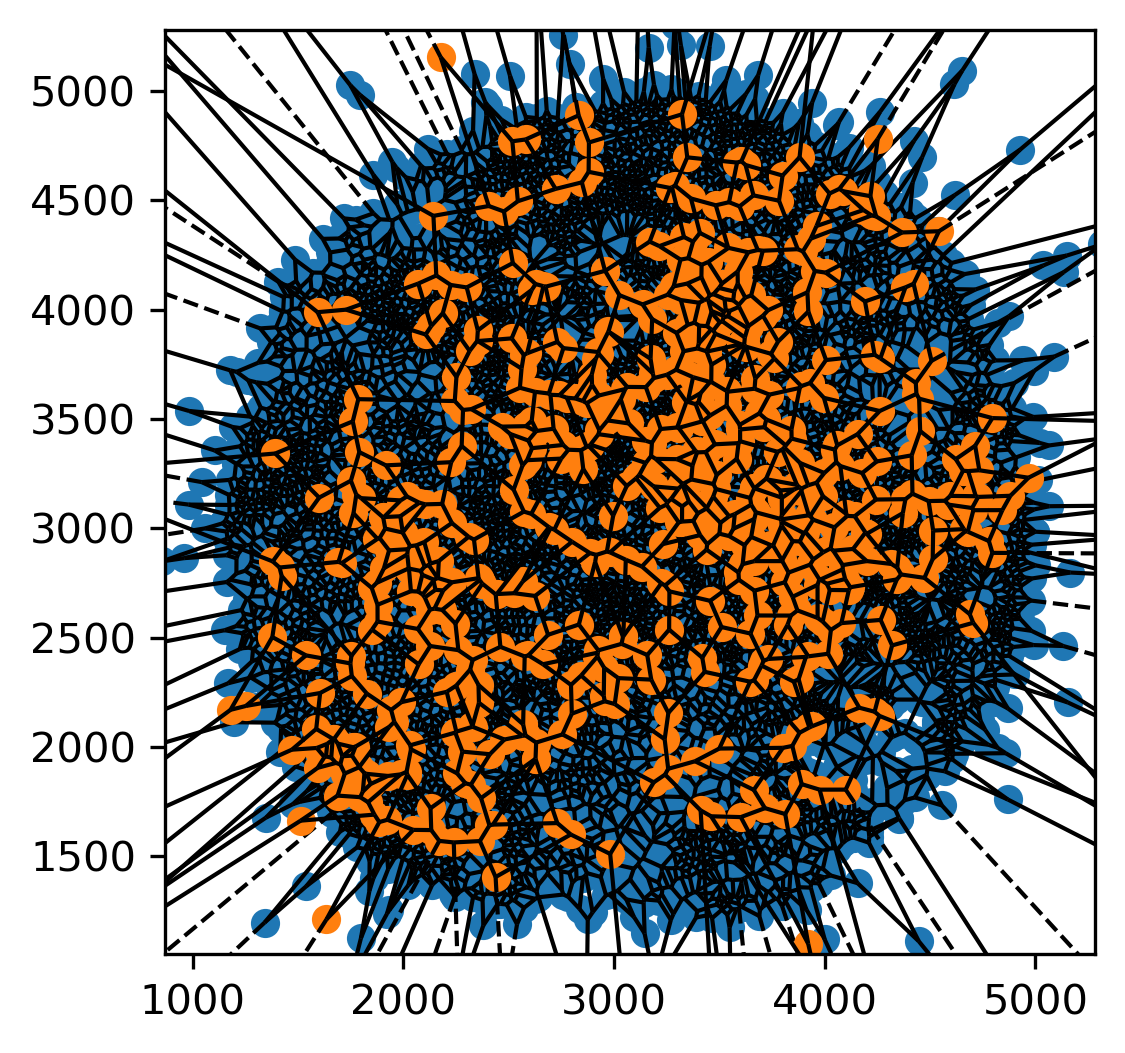

In [109]:
vor = Voronoi(np.c_[centdf.Column.values, centdf.Row.values])
vor2 = Voronoi(np.c_[centdf_pd1.Column.values, centdf_pd1.Row.values])
fig,ax = plt.subplots(figsize=(4,4),dpi=300)
voronoi_plot_2d(vor,ax=ax,show_points=False)
voronoi_plot_2d(vor2,ax=ax,show_points=False)
fig.savefig('Voronoi_example.pdf')

# Voronoi-based Cell-To-Cell Interactions (Patwa et al.) <a name="voronoi"></a>

**Purpose**: calculate cell-to-cell interactions using Voronoi diagrams.  
**Output**: interaction matrices in intermediate_data/created_interaction_matrices. The reader can compare this output to interaction_matrices/ to ensure reproducibility.  
**Estimated time**: 40 minutes.

In [79]:
# pd.DataFrame(ls_marker).to_csv(f'proteins_by_frame.csv')
# biomarker_frames = pd.read_csv("proteins_by_frame.csv",index_col=0)
# biomarker_frames

In [80]:
# #voroni - done
# # binary_infopath = "intermediate_data/protein_positivity/"
# # centroid_path = "intermediate_data/centroids/"
# biomarker_frames = pd.read_csv("proteins_by_frame.csv")

# biom_columns =  biomarker_frames["0"].values

# for patient in df_pos.slide_scene.unique():#os.listdir(binary_infopath):
#     print (patient)
#     com = np.zeros((42,42))
#     b_patient = df_pos.slide_scene==patient
#     centroid_df = df_pos.loc[b_patient,centroid_df_columns].copy()
#     centroid_df.reset_index(inplace=True)
#     biom_df = df_pos.loc[b_patient,biom_df_columns].copy()
#     biom_df.reset_index(inplace=True)
#     biom_df.rename(dict(zip(biomarker_frames.loc[:,'0'],biomarker_frames.index)),axis=1,inplace=True)
#     vor = create_voronoi(centroid_df)
#     edges = vor.ridge_points
#     # Iterate through the ridge points because they define a certain combination
#     for edge in edges:
#         # Find the indices of the cells that the edge separates
#         first_centroid = int(edge[0])
#         second_centroid = int(edge[1])
        
#         # Find their expression
#         first_cell = biom_df.loc[[first_centroid]]
#         second_cell = biom_df.loc[[second_centroid]]
    
#         first_pos = []
#         second_pos = []
#         for column in first_cell.columns[3:]:
#             if first_cell[column].values[0] == 1:
#                 first_pos.append(int(column))
#             if second_cell[column].values[0] == 1:
#                 second_pos.append(int(column))
        
#         #Cartesian product of the proteins that each cell in the adjacency are positive for
#         combinations = product(first_pos, second_pos)
#         for comb in combinations:
#             first_marker = comb[0]
#             second_marker = comb[1]
#             com[first_marker, second_marker] += 1
#             if (first_marker != second_marker):
#                 com[second_marker, first_marker] += 1
#     com_df = pd.DataFrame(com, columns=biom_columns)
#     com_df.set_index(pd.Index(biom_columns), inplace=True)
#     com_df.to_csv(f"intermediate_data/created_interaction_matrices/{patient}.csv")
#     #break

In [58]:
#sorted(os.listdir('intermediate_data/created_interaction_matrices'))

In [59]:
# #load annotation
# df_surv = pd.read_csv('data/TMA_Survival_Subtype.csv',index_col=0)
# df_clin = pd.read_csv('data/TMA_Clinical_Variables.csv',index_col=0)
# df_surv.loc[df_surv.index.str.contains('JP-TMA2'),'Platform'] = 'cycIF2'

# func Proteins
ls_func = [#'Beta Catenin, CD138, CD45RO, CD63, 
    'FoxP3', 'H3K27', 'H3K9',# HLA-DR, HLA #Class 1, IDO, 
    'CK17', 'CK5', 'Ki67',  'PD1','pS6RP'] #Phospho-S6' #Lag3, p53, PD-L1,

#lineage 
ls_lin = [#'CD11b, CD11c, CD16,  CD209,CD56,
    'CD20', 'CD3', 'CD31', 'CD4', 'CD45',  'CD68', 'CD8', #dsDNA, MPO,
  'EGFR', 'CK19', 'aSMA', 'Vim']

In [60]:
biomarker_frames = pd.read_csv("data/proteins_by_frame.csv")
d_markers = {'Immunoregulatory':[15],
 'Functional':biomarker_frames[biomarker_frames.loc[:,"0"].isin(ls_func)].index.tolist(),
 'Lineage':biomarker_frames[biomarker_frames.loc[:,"0"].isin(ls_lin)].index.tolist(),
 }


In [61]:
pwd

'/Users/engje/Documents/Data/cycIF_TMAs'

PD1 Interactions High Median = inf
PD1 Interactions Low Median = 3999.0
[45, 21]
['High', 'Low']


/var/folders/v9/4cccs75d7fn47pkrfvyzr9ysd4jjjl/T/ipykernel_7280/1868841587.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df["clust"][group2] = 1


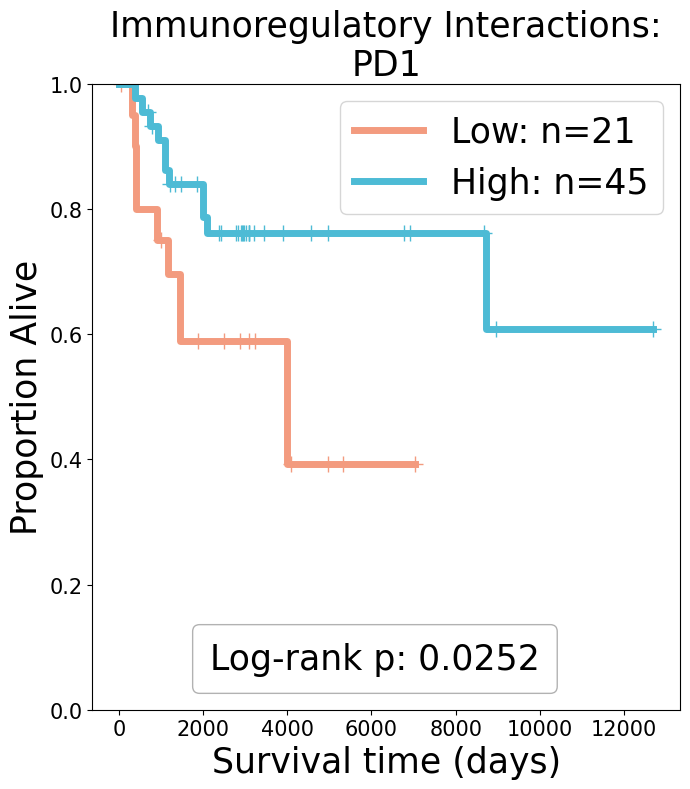

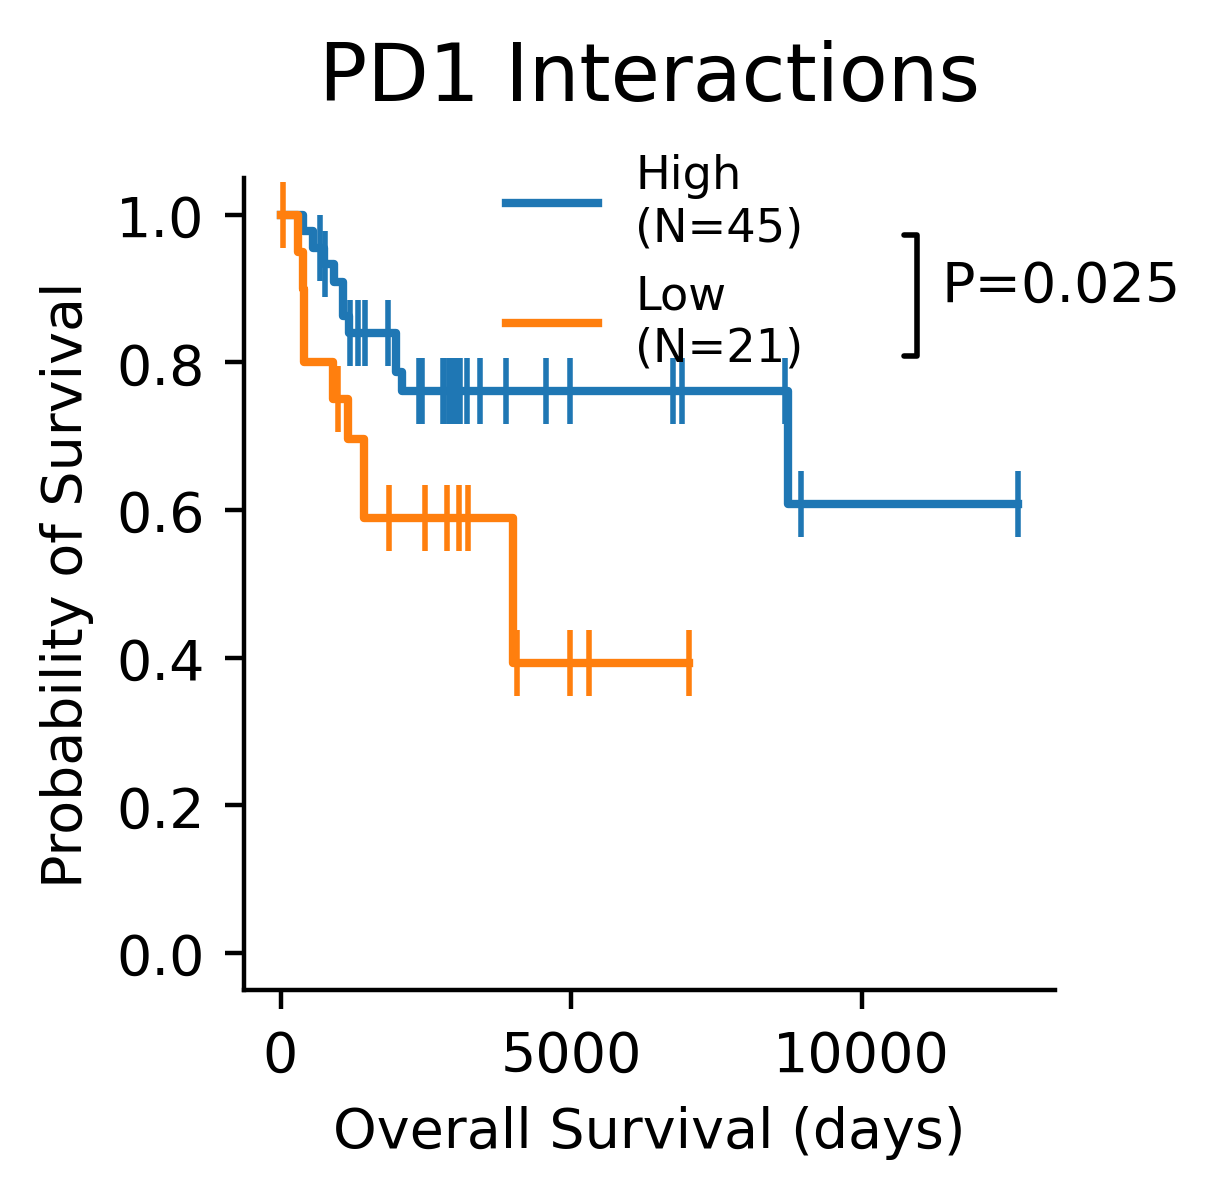

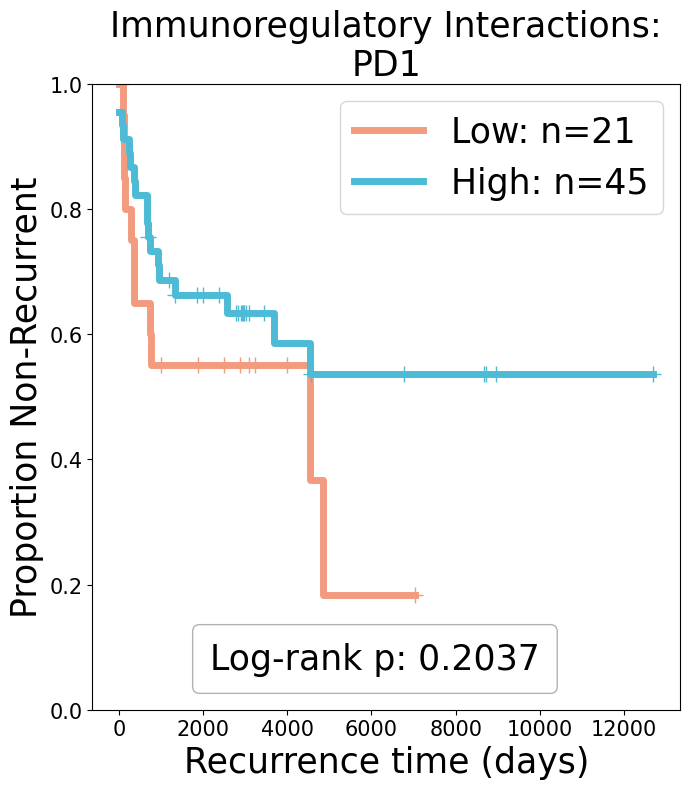

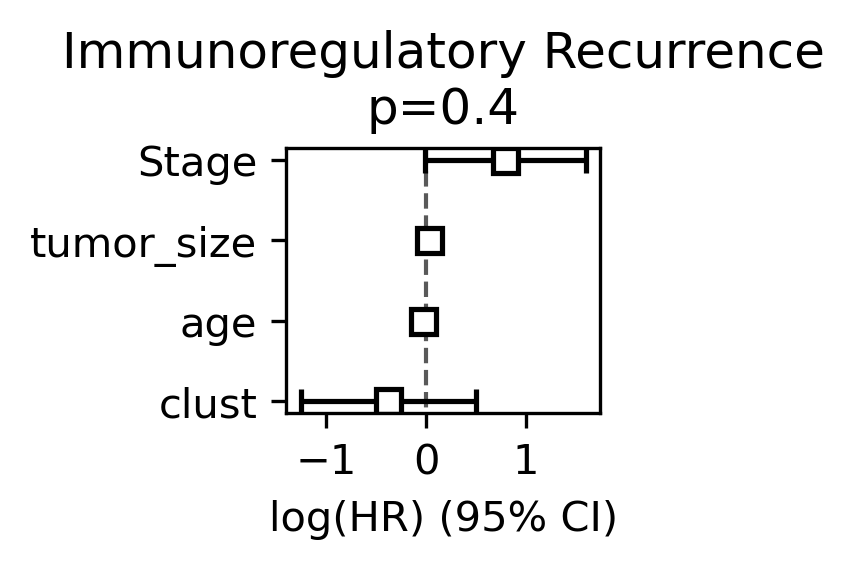

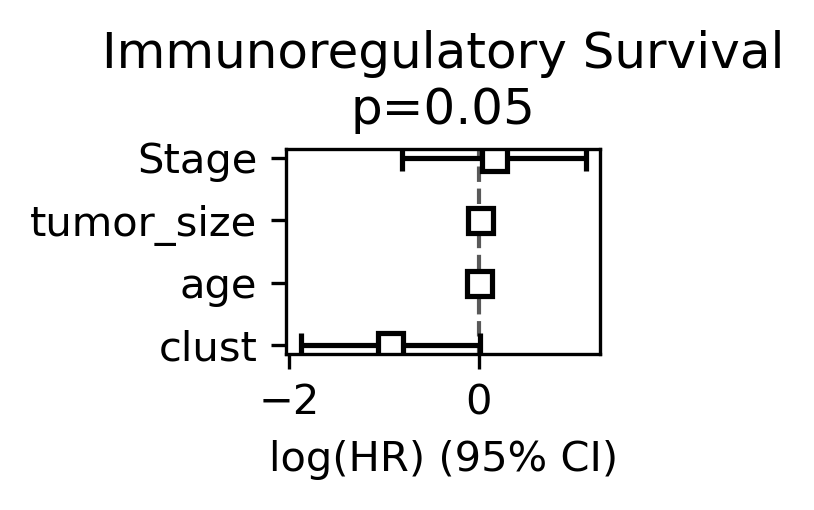

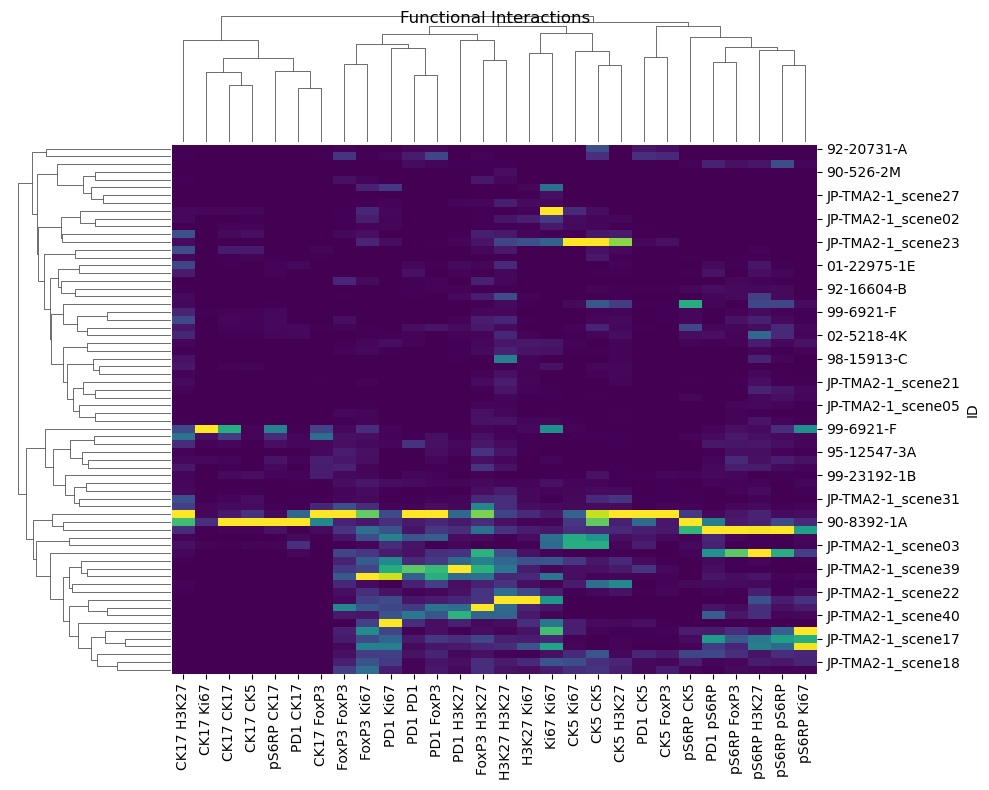

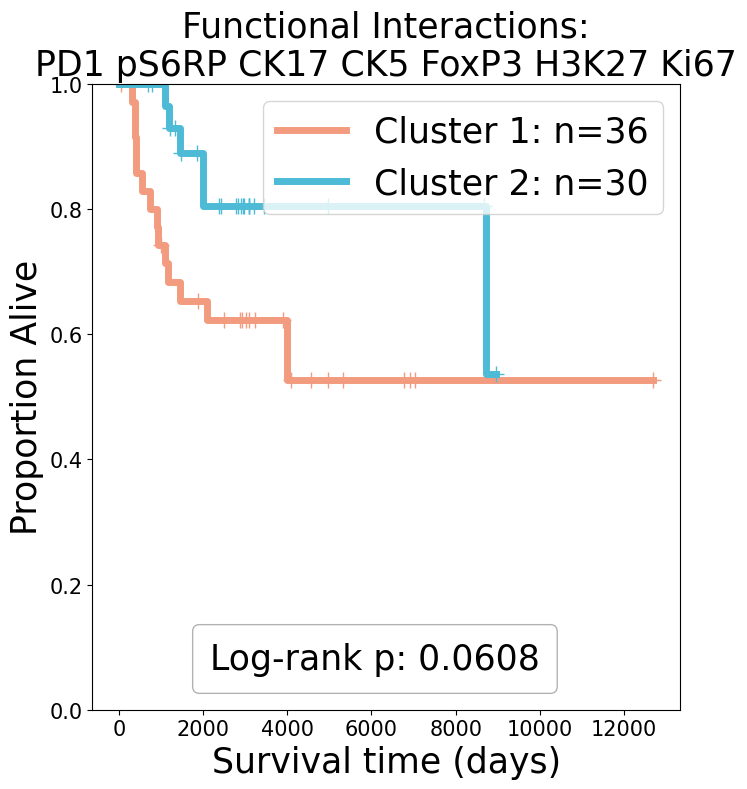

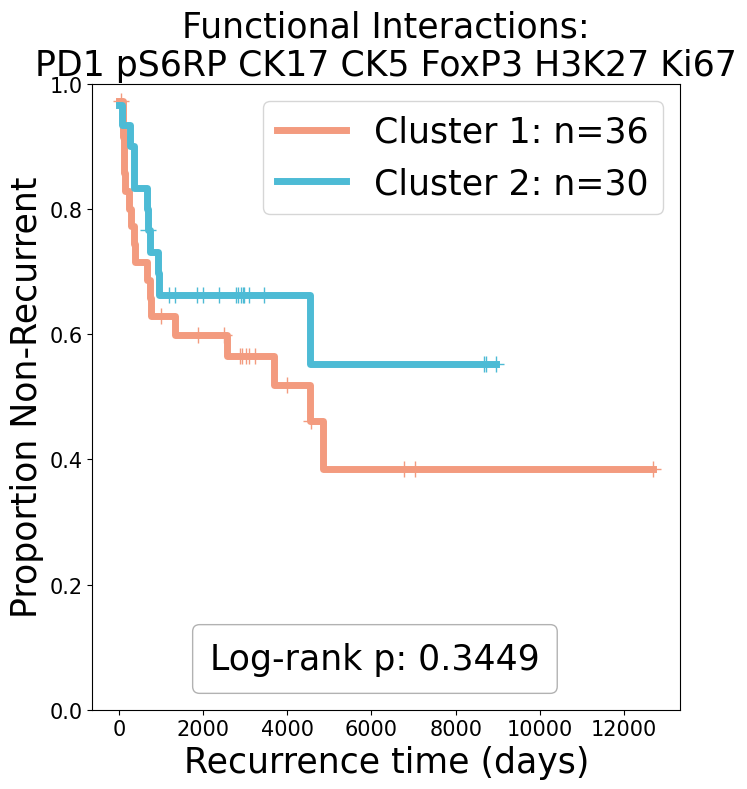

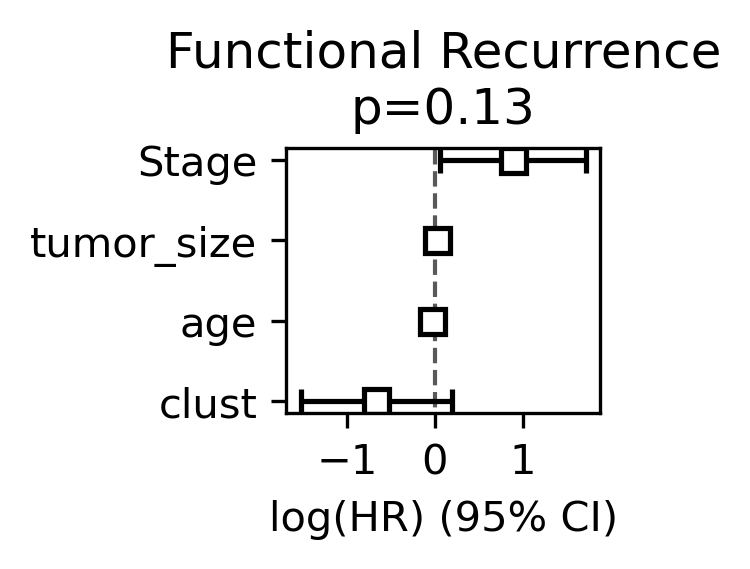

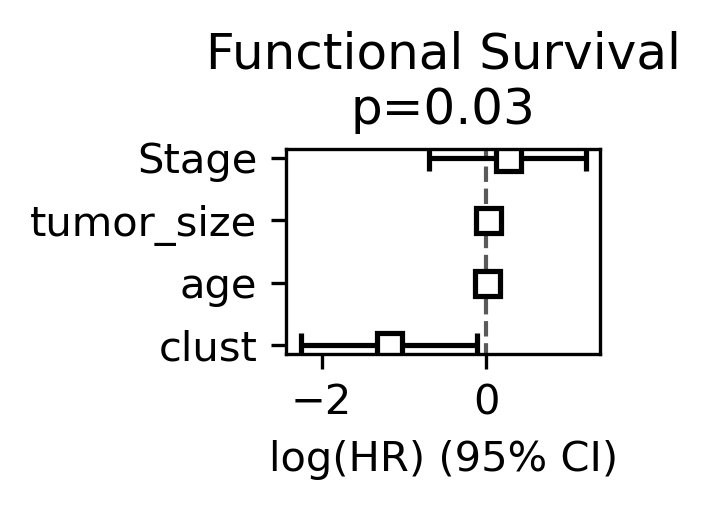

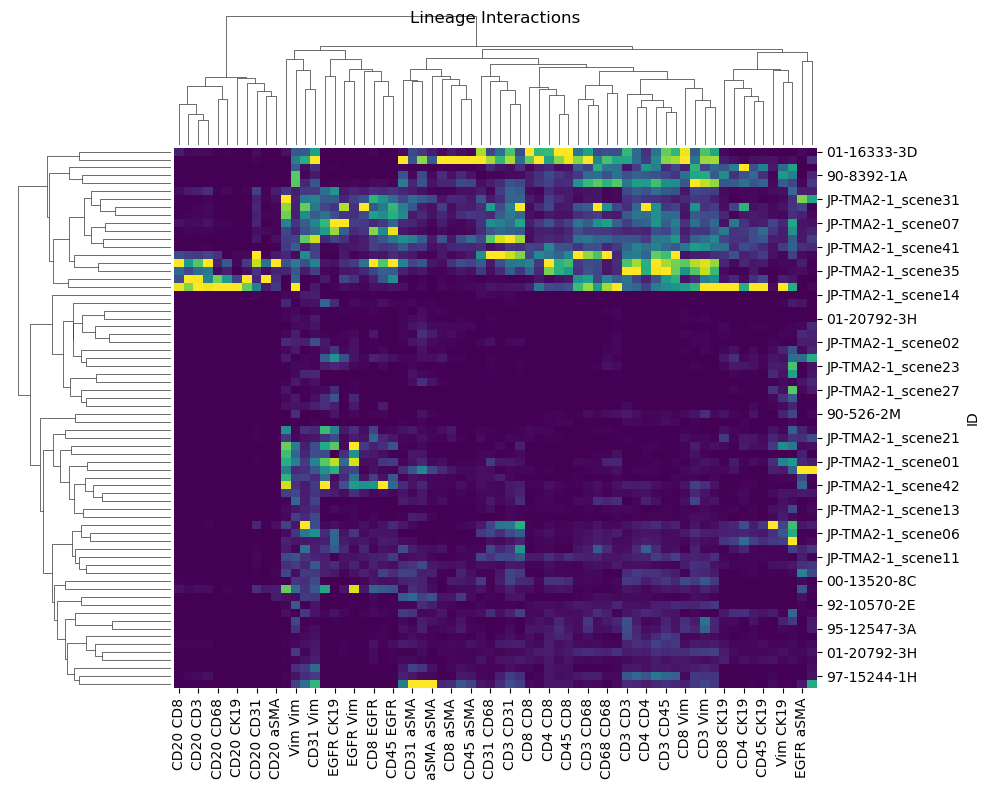

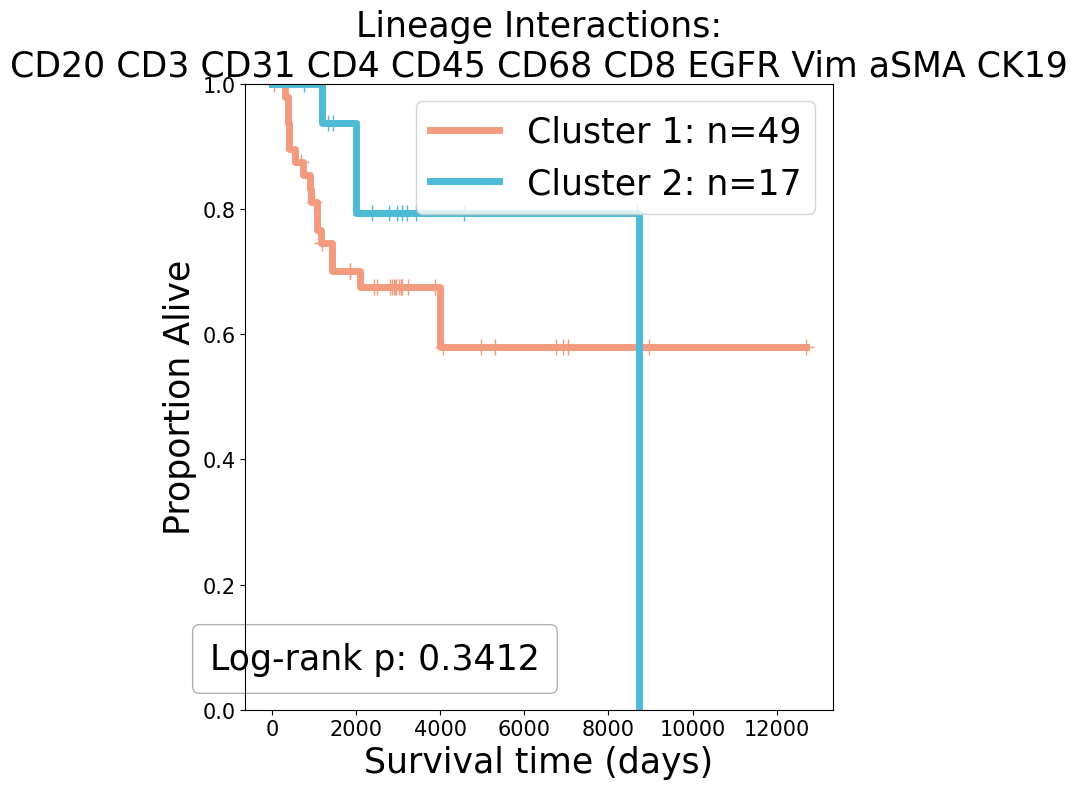

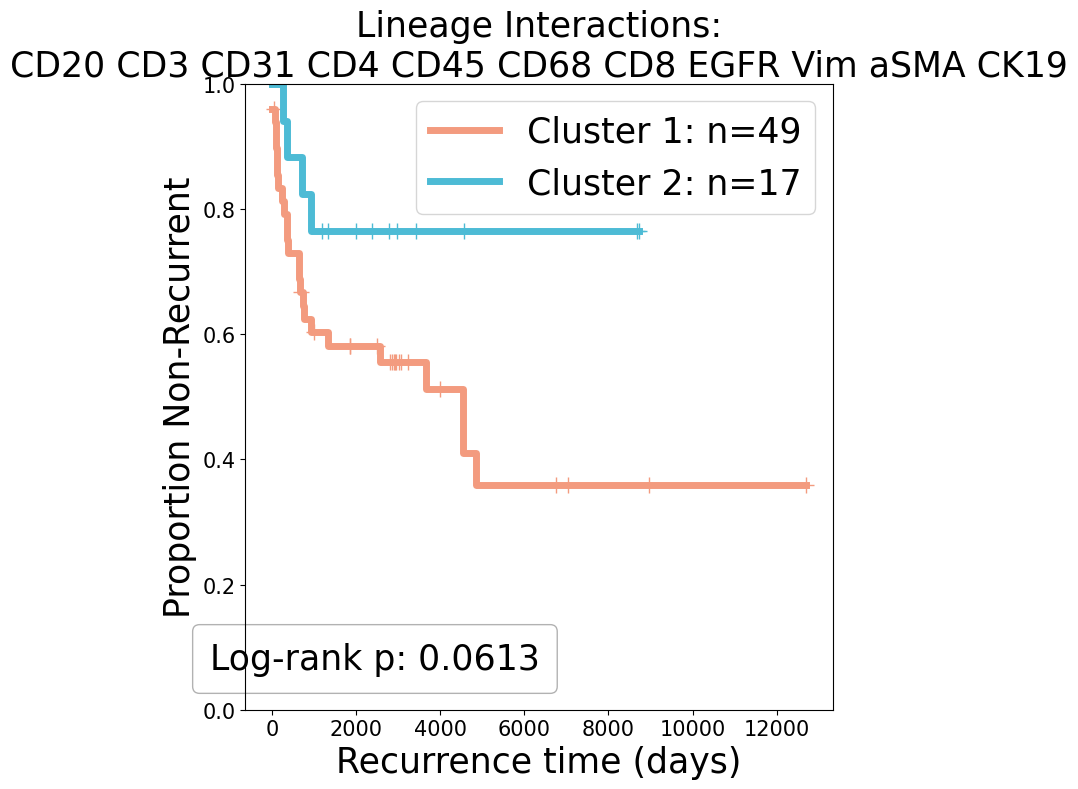

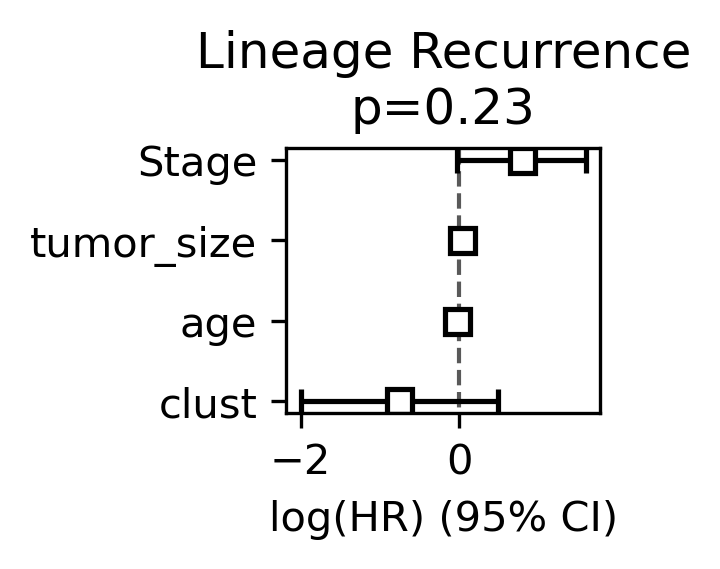

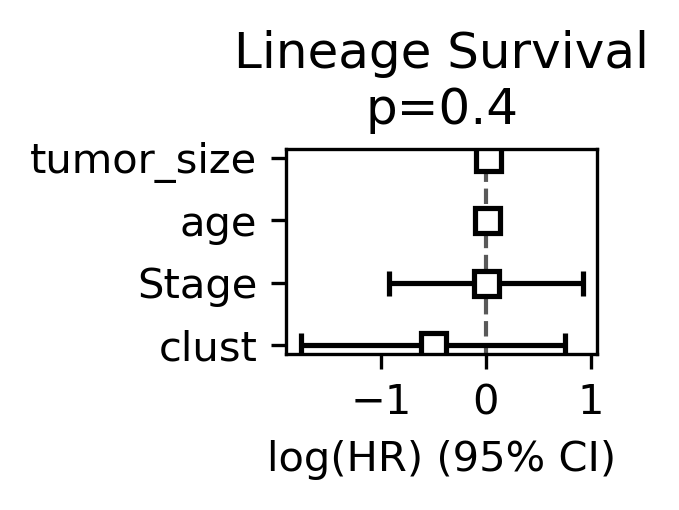

In [76]:
#interactions
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.cluster.hierarchy import fcluster
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import seaborn

import lifelines
import seaborn as sns

#load clinical covariates
df_clin = pd.read_csv('data/TMA_Clinical_Variables.csv')
df_clin.rename({'Unnamed: 0':'ID'},axis=1,inplace=True)

#Path to the clinical data. 
clinical_path = 'data/TMA_Survival_Subtype.csv'#"rawdata/clinical_data.csv"
clinical_df = pd.read_csv(clinical_path, index_col=0)#["ID"])

#Path to interaction matrices
matrices_path = "data/interaction_matrices/"

for key, markers_to_include in d_markers.items():
    # Out of all proteins, only include the functional proteins
    #markers_to_include = [ 15] #CD44 7, PD1 15 , FoxP3 29 #[27, 31, 37, 38]
    
    columns = []
    feature_list = []
    
    #Iterate over all of the co-occurrence matrices in this certain radius. 
    for patient_index in range(len(os.listdir(matrices_path))):
        patient_glcm = os.listdir(matrices_path)[patient_index]
    
        #Skip over the pesky .DS_Store file that shows up in Mac file systems.
        if (patient_glcm[0] == "."):
            continue
    
        #Find the internal_ID of the current patient. 
        identifier = patient_glcm.split(".")[0]
    
    
        #Read the co-occurrence matrix of the current patient and cast to a numpy array excluding the first col.
        current_patient_glcm = pd.read_csv(os.path.join(matrices_path, patient_glcm), index_col="Unnamed: 0")
        current_patient_glcm.set_index(current_patient_glcm.columns, inplace=True)
    
        #feature_name = current_patient_glcm.columns[chosen_feature]
        np_glcm = current_patient_glcm.to_numpy()    
    
        patient_features = []
    
        #Flatten the co-occurrence matrix into a feature vector.
        #Cannot simply run np.flatten because the matrix is symmetrical - I only want the top-right triangle
        #But, have to include the diagonal as well.
        for row in range(np_glcm.shape[0]):
            for column in range(row, np_glcm.shape[1]):
                if row in markers_to_include and column in markers_to_include:
                    if patient_index == 0:
                        feature_name = current_patient_glcm.index[row] + " " + current_patient_glcm.columns[column]
                        columns.append(feature_name)
                    patient_features.append(np_glcm[row][column])
    
        #Find the recurrence outcome of this current patient and how long it took for them to recur
        #Add these values to the feature list for eventual use in the Kaplan-Meier plot.
        try:
            patient_features.append(clinical_df.at[identifier, "Recurrence"]) #int(identifier)
            patient_features.append(clinical_df.at[identifier, "Survival"])
        except KeyError:
            identifier = df_cyc_sub.at[identifier, "Accession"]
            try:
                patient_features.append(clinical_df.at[identifier, "Recurrence"]) #int(identifier)
                patient_features.append(clinical_df.at[identifier, "Survival"])
            except:
                continue
        #print(identifier)
        patient_features.append(clinical_df.at[identifier, "Recurrence_time"]) #int
        patient_features.append(clinical_df.at[identifier, "Survival_time"])
        patient_features.append(identifier)
        feature_list.append(patient_features)
    
    #Determine the names of the columns in the DataFrame for easier future access.
    columns.append("Recurrence")
    columns.append("Survival")
    columns.append("Recurrence_time")
    
    columns.append("Survival_time")
    columns.append("ID")
    
    #Create a dataframe using the features, the recurrence events, and the time taken to recur.
    features_df = pd.DataFrame(feature_list, columns=columns)
    #only TNBC
    features_df['subtype'] = features_df.ID.map(dict(zip(clinical_df.index,clinical_df.subtype)))
    features_df = features_df[features_df.subtype=='TNBC']
    #Obtain a versino of this dataframe with only the features.
    data_only = features_df.drop(columns=["Recurrence_time", "Recurrence","Survival","Survival_time", "ID","subtype"])
    data_only.set_index(features_df["ID"], inplace=True)
    
    #Create the dendrogram.
    if len(markers_to_include) > 1:
        clustergram = seaborn.clustermap(data_only, method="weighted",
                                    metric="canberra", standard_scale = 1, cmap="viridis", figsize=(10,8), cbar_pos=None)
        
        plt.suptitle(f'{key} Interactions')
        
        #Number of clusters to take from the dendrogram
        k = 2
        
        #Use scipy fcluster to find clusters from the clustered dendrograms.
        clusters = list(fcluster(clustergram.dendrogram_row.linkage, k, criterion='maxclust'))
        
        unique_clusters = len(np.unique(np.array(clusters)))
        
        if (unique_clusters < 2):
            print ("Not able to find more than one cluster. ") #If there was no clustering, this method failed.
        
        #Create a new column in the DataFrame that includes what cluster each patient falls into
        features_df["clust"] = clusters
        
        first_cluster_count = clusters.count(1)
        second_cluster_count = clusters.count(2)
    
    else:
        features_df.loc[features_df.iloc[:,0]>0,"clust"] = 2
        features_df.clust.fillna(1, inplace=True)
    features_df = features_df.dropna()

    
    #Define the KaplanMeierFitter
    lls_time = [('Survival_time', 'Survival'),
                ('Recurrence_time', 'Recurrence')] #, 
    for s_time, s_censor in lls_time:
        kmf = KaplanMeierFitter()
        
        #T = Time, E=Event. These are the two parameters that go into Kaplan-Meier curves. 
        T = features_df[s_time]
        E = features_df[s_censor]
        
        group1 = (features_df["clust"] == 1)
        group2 = (features_df["clust"] == 2)
        
        T1 = T[group1]
        E1 = E[group1]
        T2 = T[group2]
        E2 = E[group2]
        
        color_clust1 = "#F39B7FFF"
        color_clust2 = "#4DBBD5FF"
        
        # Just for visualization purposes, make the worse-outcome cluster orange and the other blue
        if E1.mean() < E2.mean():
            T1 = T[group2]
            E1 = E[group2]
            T2 = T[group1]
            E2 = E[group1]
        
            features_df["clust"][group1] = 2
            features_df["clust"][group2] = 1
        
        first_cluster_count = len(T1.index)
        second_cluster_count = len(T2.index)
        
        results_first = logrank_test(T1,T2, event_observed_A=E1, event_observed_B=E2)
        
        p1 = round(results_first.p_value, 4)
        
        plt.figure(figsize=(7,8))
        if key == 'Immunoregulatory':
            kmf.fit(T1, E1, label='Low: n=' + str(first_cluster_count))
            ax = kmf.plot(ci_show=False, show_censors=True, color=color_clust1, lw=5)
            
            kmf.fit(T2, E2, label='High: n=' + str(second_cluster_count))
            ax = kmf.plot(ax=ax, ci_show=False, show_censors=True, color=color_clust2, lw=5)
        else:
            kmf.fit(T1, E1, label='Cluster 1: n=' + str(first_cluster_count))
            ax = kmf.plot(ci_show=False, show_censors=True, color=color_clust1, lw=5)
            
            kmf.fit(T2, E2, label='Cluster 2: n=' + str(second_cluster_count))
            ax = kmf.plot(ax=ax, ci_show=False, show_censors=True, color=color_clust2, lw=5)
        plt.annotate("Log-rank p: " + str(p1), xy=(0.3, 0.15), xycoords="figure fraction", fontsize=25,
            bbox=dict(facecolor='none', edgecolor='black', alpha=0.3, boxstyle="Round, pad=0.5, rounding_size=0.2"))
        plt.legend(fontsize=25,loc='upper right')
        plt.xlabel(f"{s_time.replace('_',' ')} (days)", fontsize=25)
        plt.xticks(fontsize=15)
        if s_censor =="Survival":
            plt.ylabel(f"Proportion Alive", fontsize=25)
        else:
            plt.ylabel(f"Proportion Non-Recurrent", fontsize=25)
        plt.yticks(fontsize=15)
        plt.ylim(0,1)
        ax.set_title(f'{key} Interactions:\n{" ".join([item for item in biomarker_frames.loc[markers_to_include,"0"]])}',fontsize=25)
        plt.tight_layout()
        plt.savefig(f"results/KM_{key}_interactions_km_{s_censor}.pdf", dpi=300)
        if key =='Immunoregulatory':
            features_df['PD1 Interactions'] = features_df.clust.replace({1:'Low',2:'High'})
            if s_censor == 'Survival': 
                fig, ax, __ = plotting.km_plot_cat(features_df,'PD1 Interactions',s_time,s_censor,fontsize='small',loc=(0.3,.74),alpha=0,figsize=(3.1,3.1),x=0.8)
                ax.set_title('PD1 Interactions',pad=14,fontsize='x-large')
                plt.tight_layout()
                plt.savefig(f"KM_{key}_interactions_km_{s_censor}.pdf", dpi=300)
    #add clinical 
    features_df = features_df.merge(df_clin,on='ID',how='left')
    cluster_choice = 'clust'
    df = features_df.copy()
    
    #manipulate the architecture distinction the variable which is originally dtype: str into a quantitative categorical variable
    #df["Architecture"] = df["clust"].astype("category").cat.codes
    
    #Create two separate feature matrices for recurrence and survival
    recurrence_df = df.drop(columns=["Survival", "Survival_time"])[[cluster_choice, "Stage", "age", "tumor_size", "Recurrence", "Recurrence_time"]]
    survival_df = df.drop(columns=["Recurrence", "Recurrence_time"])[[cluster_choice, "Stage", "age", "tumor_size", "Survival", "Survival_time"]]
    
    recurrence_df.dropna(inplace=True)
    survival_df.dropna(inplace=True)
    #Define and fit Cox PH Fitter for recurrence
    recurrence_cph = lifelines.CoxPHFitter()
    recurrence_cph.fit(recurrence_df, duration_col='Recurrence_time', event_col='Recurrence')
    fig,ax=plt.subplots(figsize=(2.2,2),dpi=300)
    recurrence_cph.plot(ax=ax)
    pval = recurrence_cph.summary.loc['clust','p']
    ax.set_title(f'{key} Recurrence\np={pval:.2}')
    plt.tight_layout()
    fig.savefig(f'{key}_Recurrence.pdf')
    #recurrence_summary = recurrence_cph.print_summary()
    
    #Define and fit Cox PH Fitter for survival
    survival_cph = lifelines.CoxPHFitter()
    survival_cph.fit(survival_df, duration_col='Survival_time', event_col='Survival')
    fig,ax=plt.subplots(figsize=(2.2,1.8),dpi=300)
    survival_cph.plot(ax=ax)
    pval = survival_cph.summary.loc['clust','p']
    ax.set_title(f'{key} Survival\np={pval:.1}')
    plt.tight_layout()
    fig.savefig(f'{key}_Survival.pdf')
    #     break
    # break

In [67]:
#sorted(os.listdir('data'))
os.getcwd()

'/Users/engje/Documents/Data/cycIF_TMAs'

# co-expression

In [ ]:
# co-expression DONE
# #binary_infopath = "intermediate_data/protein_positivity/"
# #biomarker_frames = pd.read_csv("rawdata/proteins_by_frame.csv")

# biom_columns = biomarker_frames["0"].values

# #for patient in os.listdir(binary_infopath):
# for patient in df_pos.slide_scene.unique():#os.listdir(binary_infopath):
#     #print (patient)
#     com = np.zeros((42,42))
#     b_patient = df_pos.slide_scene==patient
#     # centroid_df = df_pos.loc[b_patient,centroid_df_columns].copy()
#     # centroid_df.reset_index(inplace=True)
#     infodf = df_pos.loc[b_patient,biom_df_columns].copy()
#     infodf.reset_index(inplace=True)
#     infodf.rename(dict(zip(biomarker_frames.loc[:,'0'],biomarker_frames.index)),axis=1,inplace=True)
#     print (patient)
#     #com = np.zeros((44,44))
    
#     #infodf = pd.read_csv(binary_infopath + patient)
        
#     n_cells = len(infodf.index)
    
#     for cell in range(n_cells):
#         this_cell = infodf.iloc[[cell]]
#         pos_columns = []
#         for column in this_cell.columns[3:]:
#             if this_cell[column].values[0] == 1:
#                 pos_columns.append(int(column))
#         combs = combinations(pos_columns, 2)
#         for combination in combs:
#             com[combination[0], combination[1]] += 1
#             com[combination[1], combination[0]] += 1
#     com_df = pd.DataFrame(com, columns=biom_columns)
#     com_df.set_index(pd.Index(biom_columns), inplace=True)
#     com_df.to_csv(f"intermediate_data/created_coexpression_matrices/{patient}.csv")

In [ ]:
#os.mkdir("intermediate_data/created_coexpression_matrices/")
biomarker_frames = pd.read_csv("data/proteins_by_frame.csv")
d_markers = {#'All':biomarker_frames.index.tolist(),
 'Functional':biomarker_frames[biomarker_frames.loc[:,"0"].isin(ls_func)].index.tolist(),
 'Lineage':biomarker_frames[biomarker_frames.loc[:,"0"].isin(ls_lin)].index.tolist(),
 #'Immunoregulatory':[15],
}

#Path to the clinical data. 
clinical_path = 'data/TMA_Survival_Subtype.csv'#"rawdata/clinical_data.csv"
clinical_df = pd.read_csv(clinical_path, index_col=0)#["ID"])

#Path to interaction matrices
matrices_path = "data/coexpression_matrices/"

for key, markers_to_include in d_markers.items():
    # Out of all proteins, only include the functional proteins
    #markers_to_include = [ 15] #CD44 7, PD1 15 , FoxP3 29 #[27, 31, 37, 38]
    
    columns = []
    feature_list = []
    
    #Iterate over all of the co-occurrence matrices in this certain radius. 
    for patient_index in range(len(os.listdir(matrices_path))):
        patient_glcm = os.listdir(matrices_path)[patient_index]
    
        #Skip over the pesky .DS_Store file that shows up in Mac file systems.
        if (patient_glcm[0] == "."):
            continue
    
        #Find the internal_ID of the current patient. 
        identifier = patient_glcm.split(".")[0]
    
    
        #Read the co-occurrence matrix of the current patient and cast to a numpy array excluding the first col.
        current_patient_glcm = pd.read_csv(os.path.join(matrices_path, patient_glcm), index_col="Unnamed: 0")
        current_patient_glcm.set_index(current_patient_glcm.columns, inplace=True)
    
        #feature_name = current_patient_glcm.columns[chosen_feature]
        np_glcm = current_patient_glcm.to_numpy()    
    
        patient_features = []
    
        #Flatten the co-occurrence matrix into a feature vector.
        #Cannot simply run np.flatten because the matrix is symmetrical - I only want the top-right triangle
        #But, have to include the diagonal as well.
        for row in range(np_glcm.shape[0]):
            for column in range(row, np_glcm.shape[1]):
                if row in markers_to_include and column in markers_to_include:
                    if patient_index == 0:
                        feature_name = current_patient_glcm.index[row] + " " + current_patient_glcm.columns[column]
                        columns.append(feature_name)
                    patient_features.append(np_glcm[row][column])
    
        #Find the recurrence outcome of this current patient and how long it took for them to recur
        #Add these values to the feature list for eventual use in the Kaplan-Meier plot.
        try:
            patient_features.append(clinical_df.at[identifier, "Recurrence"]) #int(identifier)
            patient_features.append(clinical_df.at[identifier, "Survival"])
        except KeyError:
            identifier = df_cyc_sub.at[identifier, "Accession"]
            try:
                patient_features.append(clinical_df.at[identifier, "Recurrence"]) #int(identifier)
                patient_features.append(clinical_df.at[identifier, "Survival"])
            except:
                continue
        #print(identifier)
        patient_features.append(clinical_df.at[identifier, "Recurrence_time"]) #int
        patient_features.append(clinical_df.at[identifier, "Survival_time"])
        patient_features.append(identifier)
        feature_list.append(patient_features)
    
    #Determine the names of the columns in the DataFrame for easier future access.
    columns.append("Recurrence")
    columns.append("Survival")
    columns.append("Recurrence_time")
    
    columns.append("Survival_time")
    columns.append("ID")
    
    #Create a dataframe using the features, the recurrence events, and the time taken to recur.
    features_df = pd.DataFrame(feature_list, columns=columns)
    #only TNBC
    features_df['subtype'] = features_df.ID.map(dict(zip(clinical_df.index,clinical_df.subtype)))
    features_df = features_df[features_df.subtype=='TNBC']
    #Obtain a versino of this dataframe with only the features.
    data_only = features_df.drop(columns=["Recurrence_time", "Recurrence","Survival","Survival_time", "ID","subtype"])
    data_only.set_index(features_df["ID"], inplace=True)
    ls_drop = data_only.loc[:,data_only.sum() == 0].columns
    data_only.drop(ls_drop,axis=1,inplace=True)
    #Create the dendrogram.
    if len(markers_to_include) > 1:
        clustergram = seaborn.clustermap(data_only, method="weighted",
                                    metric="canberra", standard_scale = 1, cmap="viridis", figsize=(10,8), cbar_pos=None)
        
        plt.suptitle(f'{key} Co-expression')
        
        #Number of clusters to take from the dendrogram
        k = 2
        
        #Use scipy fcluster to find clusters from the clustered dendrograms.
        clusters = list(fcluster(clustergram.dendrogram_row.linkage, k, criterion='maxclust'))
        
        unique_clusters = len(np.unique(np.array(clusters)))
        
        if (unique_clusters < 2):
            print ("Not able to find more than one cluster. ") #If there was no clustering, this method failed.
        
        #Create a new column in the DataFrame that includes what cluster each patient falls into
        features_df["clust"] = clusters
        
        first_cluster_count = clusters.count(1)
        second_cluster_count = clusters.count(2)
    
    else:
        features_df.loc[features_df.iloc[:,0]>0,"clust"] = 2
        features_df.clust.fillna(1, inplace=True)
    features_df = features_df.dropna()
    
    
    #Define the KaplanMeierFitter
    lls_time = [('Survival_time', 'Survival'),
                ('Recurrence_time', 'Recurrence')] #, 
    for s_time, s_censor in lls_time:
        kmf = KaplanMeierFitter()
        
        #T = Time, E=Event. These are the two parameters that go into Kaplan-Meier curves. 
        T = features_df[s_time]
        E = features_df[s_censor]
        
        group1 = (features_df["clust"] == 1)
        group2 = (features_df["clust"] == 2)
        
        T1 = T[group1]
        E1 = E[group1]
        T2 = T[group2]
        E2 = E[group2]
        
        color_clust1 = "#F39B7FFF"
        color_clust2 = "#4DBBD5FF"
        
        # Just for visualization purposes, make the worse-outcome cluster orange and the other blue
        if E1.mean() < E2.mean():
            T1 = T[group2]
            E1 = E[group2]
            T2 = T[group1]
            E2 = E[group1]
        
            features_df["clust"][group1] = 2
            features_df["clust"][group2] = 1
        
        first_cluster_count = len(T1.index)
        second_cluster_count = len(T2.index)
        
        results_first = logrank_test(T1,T2, event_observed_A=E1, event_observed_B=E2)
        
        p1 = round(results_first.p_value, 4)
        
        plt.figure(figsize=(7,8))
        kmf.fit(T1, E1, label='Cluster 1: n=' + str(first_cluster_count))
        ax = kmf.plot(ci_show=False, show_censors=True, color=color_clust1, lw=5)
        
        kmf.fit(T2, E2, label='Cluster 2: n=' + str(second_cluster_count))
        ax = kmf.plot(ax=ax, ci_show=False, show_censors=True, color=color_clust2, lw=5)
        plt.annotate("Log-rank p: " + str(p1), xy=(0.6, 0.15), xycoords="figure fraction", fontsize=25,
            bbox=dict(facecolor='none', edgecolor='black', alpha=0.3, boxstyle="Round, pad=0.5, rounding_size=0.2"))
        plt.legend(fontsize=25,loc='upper right')
        plt.xlabel(s_time, fontsize=25)
        plt.xticks(fontsize=15)
        if s_censor =="Survival":
            plt.ylabel(f"Proportion Alive", fontsize=25)
        else:
            plt.ylabel(f"Proportion Non-Recurrent", fontsize=25)
        plt.yticks(fontsize=15)
        plt.ylim(0,1)
        ax.set_title(f'{key} Co-expression:\n{" ".join([item for item in biomarker_frames.loc[markers_to_include,"0"]])}',fontsize=25)
        plt.tight_layout()
        
        plt.savefig(f"results/KM_{key}_coexpression_km_{s_censor}.png", dpi=300)
    break


In [ ]:
#add clinical covariates to immunoregulatory
df_clin = pd.read_csv('data/TMA_Clinical_Variables.csv')
df_clin.rename({'Unnamed: 0':'ID'},axis=1,inplace=True)
features_df = features_df.merge(df_clin,on='ID',how='left')

In [ ]:
#Imports
import numpy as np
import pandas as pd
import lifelines
import seaborn as sns

# CSV_PATH = "intermediate_data/covariate_rsf_data.csv" #put path to csv summarizing cluster features, clinical variables, architecutre distinction, and clinical outcome

# #Read csv summarizing cluster features, clinical variables, morphology distinction, and clinical outcome
# df = pd.read_csv(CSV_PATH, index_col="ID")

# #define which cluster feature to examine
# #options: [coexpression_cluster, functional_proteins_cluster, immunoregulatory_protein_cluster]
# #can either examine each one-at-a-time or iterate through them
# cluster_choice = "coexpression_cluster" 
cluster_choice = 'clust'
df = features_df.copy()

#manipulate the architecture distinction the variable which is originally dtype: str into a quantitative categorical variable
#df["Architecture"] = df["clust"].astype("category").cat.codes

#Create two separate feature matrices for recurrence and survival
recurrence_df = df.drop(columns=["Survival", "Survival_time"])[[cluster_choice, "Stage", "age", "tumor_size", "Recurrence", "Recurrence_time"]]
survival_df = df.drop(columns=["Recurrence", "Recurrence_time"])[[cluster_choice, "Stage", "age", "tumor_size", "Survival", "Survival_time"]]

recurrence_df.dropna(inplace=True)
survival_df.dropna(inplace=True)
#Define and fit Cox PH Fitter for recurrence
recurrence_cph = lifelines.CoxPHFitter()
recurrence_cph.fit(recurrence_df, duration_col='Recurrence_time', event_col='Recurrence')
fig,ax=plt.subplots(figsize=(3,1.5),dpi=300)
recurrence_cph.plot(ax=ax)
pval = recurrence_cph.summary.loc['clust','p']
ax.set_title(f'Co-expression Recurrence\np={pval:.2}')
#recurrence_summary = recurrence_cph.print_summary()

#Define and fit Cox PH Fitter for survival
survival_cph = lifelines.CoxPHFitter()
survival_cph.fit(survival_df, duration_col='Survival_time', event_col='Survival')
fig,ax=plt.subplots(figsize=(3,1.5),dpi=300)
survival_cph.plot(ax=ax)
pval = survival_cph.summary.loc['clust','p']
ax.set_title(f'Co-expression Survival\np={pval:.1}')#
#survival_summary = survival_cph.print_summary()

## distances <a name="dist"></a>

- distance to non-cellular components in ECM

- as in Johnson et al Cell Rep Med 2022

- old, did not use


[contents](#contents)

In [ ]:
#neighbor distance
# collagen detection
'''
# ColI, ColIV
d_thresh =  {'SMT101Bx2-5-Scene-001':[3.8,18],
 'SMT101Bx2-5-Scene-002':[3.8,18],
 'SMT101Bx3-Scene-004': [9,7],
 'SMT101Bx4-3-Scene-001': [15,4],
 'SMT101Bx4-3-Scene-002': [6,4]
 }
from mplex_image import features
import importlib
importlib.reload(features)
from skimage import io
from matplotlib.colors import LogNorm
df_thresh = pd.read_csv('/home/groups/graylab_share/OMERO.rdsStore/engje/Data/20201105_SMT101/101paper_data/thresh_JE_SMT101.csv',index_col=0)
for s_sample in ls_sample:
    df_xy = pd.read_csv(f'{segdir}/features_{s_sample}_CentroidXY.csv',index_col=0)
    os.chdir(f'{subdir}/{s_sample}')
    df_img = mpimage.parse_org()
    for idxs, s_marker in enumerate(['CD31','PDPN','Vim','aSMA','CD68','ColI','ColIV']):
        df_marker = df_img[(df_img.marker==s_marker) & (df_img.scene=='SMT101Bx3-Scene-004')]
        df_dist = pd.DataFrame()
        for idx, s_index in enumerate(df_marker.index):
            img = io.imread(s_index)
            s_scene = df_marker.loc[s_index,'scene']
            print(s_scene)
            #i_thresh = d_thresh[s_scene][idxs]*256
            i_thresh = df_thresh.loc[s_scene.replace('-Scene-','_scene'),s_marker]*256
            mask = img > i_thresh
            fig, ax = plt.subplots()
            ax.imshow(mask)
            fig.savefig(f'{qcdir}/mask_{s_scene}_{s_marker}.png',dpi=200)
            mask_out,shrunk_mask,maskdist,distances = features.mask_border(~mask,type='inner',pixel_distance= 50)
            fig, ax = plt.subplots()
            ax.imshow(distances.clip(min=0.01), norm=LogNorm(vmin=0.01, vmax=2000))
            fig.savefig(f'{qcdir}/mask_{s_scene}_{s_marker}_distances.png',dpi=200)
            df_scene = features.cell_distances(df_xy,s_scene,distances)
            df_dist = df_dist.append(df_scene)
        df_dist.rename({'pixel_dist':f'{s_marker}_dist'},axis=1,inplace=True)
        df_xy = df_xy.merge(df_dist.loc[:,f'{s_marker}_dist'],left_index=True,right_index=True,how='left')
    df_xy.to_csv(f'{segdir}/features_{s_sample}_MaskDistances.csv')
'''

In [ ]:
# import scipy
# def mask_border(mask,type='inner',pixel_distance = 50):
#     '''
#     for inner, distance transform from mask to background
#     for outer, distance transform from back ground to mask
#     returns a mask
#     '''
#     shrunk_mask = mask.copy()
#     if type == 'inner':
#         foreground = ~mask
#         background = mask
#     elif type == 'outer':
#         foreground = ~mask
#         background = mask
#     distances, (i, j) = scipy.ndimage.distance_transform_edt(
#                 background, return_indices=True
#             )
#     maskdist = mask & (distances <= pixel_distance)
#     shrunk_mask[maskdist] = shrunk_mask[i[maskdist], j[maskdist]]
#     mask_out = np.logical_and(mask,np.logical_not(shrunk_mask))
#     return(mask_out,shrunk_mask,maskdist,distances)

# def cell_distances(df_scene,distances):
#     '''
#     load a binary mask of tissue, cell labels, and xy coord datafreame.
#     return data frame of cells witin binary mask
#     '''
#     df_scene = df_scene.copy()
#     df_scene['DAPI_Y'] = df_scene.DAPI_Y.astype('int64')
#     df_scene['DAPI_X'] = df_scene.DAPI_X.astype('int64')
#     df_scene['pixel_dist'] = distances[df_scene.DAPI_Y,df_scene.DAPI_X]
#     return(df_scene)

In [ ]:
# #mask will be positive cell centroids
# df_result = pd.DataFrame()
# for s_scene in sorted(set(df_lei.slide_scene)):
#     print(s_scene)
#     df_scene = df_lei[df_lei.slide_scene==s_scene]   
#     df_result_scene=pd.DataFrame(index=df_scene.index)
#     for s_cell in df_scene.leiden.unique():
#         #print(s_cell)
#         a_scene = np.zeros(shape=(round(df_scene.DAPI_Y.max()+1),round(df_scene.DAPI_X.max())+1),dtype='int')
#         df_cell = df_scene[df_scene.leiden==s_cell]
#         #print(len(df_cell))
#         a_scene[round(df_cell.DAPI_Y).astype('int').values,round(df_cell.DAPI_X).astype('int').values] = 255
#         mask = a_scene > 200
#         distances, (i, j) = scipy.ndimage.distance_transform_edt(~mask, return_indices=True)
#         df_scene_dist = cell_distances(df_scene.loc[:,['DAPI_X','DAPI_Y']],distances)
#         df_result_scene[f'{s_cell}_dist'] = df_scene_dist.pixel_dist
#         #break
#     df_result = df_result.append(df_result_scene)

In [ ]:
#df_result.to_csv(f'{codedir}/data/{s_sample}_PixelDistances.csv')

In [ ]:
# fig,ax=plt.subplots()
# ax.imshow(distances.clip(min=0.01),norm=LogNorm(vmin=0.01, vmax=3000))

In [ ]:
# df_lei = pd.read_csv(f'{codedir}/data/20220118_JP-TMAs_LeidenClustering_neighbors30_resolution0.4_markers22_2sub.csv',index_col=0)
# df_lei['slide_scene'] = [item.split('_cell')[0] for item in df_lei.index]
# df_lei['Patient'] = df_lei.slide_scene.map(dict(zip(df_cyc_sub.index,df_cyc_sub.Accession)))
# df_lei['subtype'] = df_lei.slide_scene.map(dict(zip(df_cyc_sub.index,df_cyc_sub.ID)))
# df_lei['leidencelltype2'] = df_lei.leidencelltype3.replace({'tumor':'epithelial','endothelial':'stromal','immune':'stromal'})
# df_lei['celltype1'] = 'all'
# df_lei['countme'] = True
# df_lei['Platform'] = 'cycIF'
# df_lei['gatedcelltype3'] = df_lei.celltype.replace({'endothelial':'stromal'})
# df_lei['leiden'] = df_lei.leiden.replace(d_celltype_cycif)
# df_lei = df_lei.rename({'aSMA':'SMA'},axis=1)

In [ ]:
# s_sample = '20220118_JP-TMAs_s'
# df_dist = pd.read_csv(f'{codedir}/data/{s_sample}_PixelDistances.csv',index_col=0)

In [ ]:
# from joypy import joyplot
# s_subtype = 'ER+'
# ls_er_index = df_lei[(df_lei.leiden=='Luminal ER+ t.') & (df_lei.subtype==s_subtype)].index
# ls_pro_index = df_lei[(df_lei.leiden=='Proliferating t.')& (df_lei.subtype==s_subtype)].index

In [ ]:
# #proliferating cell counts
# ls_str = ['Vim++ str._dist','NOS str._dist', 'Macrophage_dist', 'Endothelial_dist',
#         'CD3 T cell_dist', 'CD44+ str._dist', 
#       'ECM++ str._dist', 'CD20 B cell_dist', ]
# ls_tum = ['Vim+ t._dist', 'Ecad- t._dist', 'poorly diff t._dist', 'Basal t._dist','Large t._dist',
#          'Myoepithelial_dist', #'Proliferating t._dist',
#           'CD44+ t._dist', 'EGFR hi t._dist','Luminal ER+ t._dist',
#           'Luminal t._dist', 'Luminal hi t._dist']
# fig, ax = joyplot(data=df_dist.loc[ls_pro_index,df_dist.loc[ls_pro_index,ls_str].mean().sort_values().index],grid=True)
# fig2, ax2 = joyplot(data=df_dist.loc[ls_pro_index,df_dist.loc[ls_pro_index,ls_tum].mean().sort_values().index],grid=True)

In [ ]:

# #ER + cell counts
# ls_str = ['NOS str._dist', 'Macrophage_dist', 'Endothelial_dist',
#        'Vim++ str._dist', 'CD3 T cell_dist', 'CD44+ str._dist', 
#       'ECM++ str._dist', 'CD20 B cell_dist', ]
# ls_tum = ['Vim+ t._dist', 'Ecad- t._dist', 'poorly diff t._dist', 'Large t._dist','Basal t._dist',
#          'Myoepithelial_dist', 'Proliferating t._dist','CD44+ t._dist', 'EGFR hi t._dist',#'Luminal ER+ t._dist',
#           'Luminal t._dist', 'Luminal hi t._dist']
# fig, ax = joyplot(data=df_dist.loc[ls_er_index,df_dist.loc[ls_er_index,ls_str].mean().sort_values().index],grid=True)
# fig2, ax2 = joyplot(data=df_dist.loc[ls_er_index,df_dist.loc[ls_er_index,ls_tum].mean().sort_values().index],grid=True)

In [ ]:
# #ER expression vs stromal
# bins = pd.IntervalIndex.from_tuples([(75, 150), (150, 225), (225, 300), (300, 375), (375, 450), (450, 525), (525, 600)])

# df_er = df_lei.loc[ls_er_index,['ER']]
# for s_dist in ls_str:  #df_dist.columns:
#     df_dist.loc[ls_er_index,s_dist]
#     #se_q,bins = pd.qcut(x=df_dist.loc[ls_er_index,s_dist], q=20,retbins=True)
#     se_q = pd.cut(df_dist.loc[ls_er_index,s_dist], bins)
#     s_cell = s_dist.split('_dist')[0]
#     df_er['Distance_Quartile'] = se_q
#     df_er[f'{s_dist}_Quartile'] = se_q
#     print(s_dist)
#     df_er.groupby('Distance_Quartile').median().plot(title=s_dist)
#     df_er.groupby('Distance_Quartile').mean().plot(title=s_dist)
#     #plot
#     fig,ax = joyplot(data=df_er.dropna(),by='Distance_Quartile',grid=True)
#     ax[0].set_title(s_cell)
#     #break

In [ ]:

# ls_columns= ['Vim++ str._dist_Quartile', 'NOS str._dist_Quartile',
#        'Macrophage_dist_Quartile', 'Endothelial_dist_Quartile',
#        'CD3 T cell_dist_Quartile', 'CD44+ str._dist_Quartile',
#        'ECM++ str._dist_Quartile', 'CD20 B cell_dist_Quartile']
# #
# df_er['slide_scene'] =[item.split('_cell')[0] for item in df_er.index]
# for s_marker in ls_columns:
#     df_plot = df_er.drop('Distance_Quartile',axis=1).groupby(['slide_scene',s_marker]).mean().reset_index()
#     fig,ax=plt.subplots()
#     sns.boxplot(data=df_plot,y='ER',x=s_marker,showfliers=False,ax=ax,palette='muted')
#     sns.stripplot(data=df_plot,y='ER',x=s_marker,ax=ax,palette='dark')
#     ax.set_title(s_marker)
#     ax.set_ylim(0,5)
#     #break

In [ ]:
# #ER expression vs tumor
# ls_tum = ['Vim+ t._dist', 'Ecad- t._dist', 'poorly diff t._dist', 'Basal t._dist','Large t._dist',
#          'Myoepithelial_dist', 'Proliferating t._dist','CD44+ t._dist', #'EGFR hi t._dist',#'Luminal ER+ t._dist',
#           'Luminal t._dist', 'Luminal hi t._dist']
# df_er = df_lei.loc[ls_er_index,['ER']]
# for s_dist in ls_tum:  #df_dist.columns:
#     df_dist.loc[ls_er_index,s_dist]
#     #se_q,bins = pd.qcut(x=df_dist.loc[ls_er_index,s_dist], q=15,retbins=True)
#     se_q = pd.cut(df_dist.loc[ls_er_index,s_dist], bins)
#     s_cell = s_dist.split('_dist')[0]
#     df_er['Distance_Quartile'] = se_q
#     df_er[f'{s_dist}_Quartile'] = se_q
#     #plot
#     fig,ax = joyplot(data=df_er.dropna(),by='Distance_Quartile',grid=True)
#     ax[0].set_title(s_cell)
#     #break

In [ ]:
# ls_columns = ['Vim+ t._dist_Quartile',
#        'Ecad- t._dist_Quartile', 'poorly diff t._dist_Quartile',
#        'Basal t._dist_Quartile', 'Large t._dist_Quartile',
#        'Myoepithelial_dist_Quartile', 'Proliferating t._dist_Quartile',
#        'CD44+ t._dist_Quartile', 'Luminal t._dist_Quartile']
# #
# df_er['slide_scene'] =[item.split('_cell')[0] for item in df_er.index]
# for s_marker in ls_columns:
#     df_plot = df_er.drop('Distance_Quartile',axis=1).groupby(['slide_scene',s_marker]).mean().reset_index()
#     fig,ax=plt.subplots()
#     sns.boxplot(data=df_plot,y='ER',x=s_marker,showfliers=False,ax=ax,palette='muted')
#     sns.stripplot(data=df_plot,y='ER',x=s_marker,ax=ax,palette='dark')
#     ax.set_title(s_marker)
#     ax.set_ylim(0,5)
#     #break

In [ ]:
# df_er = df_lei.loc[ls_pro_index,['Ki67']]
# df_ki67 = df_er.copy()
# ls_str = ['NOS str._dist', 'Macrophage_dist', 'Endothelial_dist',
#        'Vim++ str._dist',
#           'CD3 T cell_dist', 'CD44+ str._dist', 
#       'ECM++ str._dist', 'CD20 B cell_dist',
#          ]
# for s_dist in ls_str:  #df_dist.columns:
#     df_dist.loc[ls_pro_index,s_dist]
#     #se_q,bins = pd.qcut(x=df_dist.loc[ls_pro_index,s_dist], q=20,retbins=True)
#     se_q = pd.cut(df_dist.loc[ls_pro_index,s_dist], bins)
#     s_cell = s_dist.split('_dist')[0]
#     df_er['Distance_Quartile'] = se_q
#     df_ki67[f'{s_dist}_Quartile'] = se_q
#     #df_er.groupby('Distance_Quartile').median().plot(title=s_dist)
#     #df_er.groupby('Distance_Quartile').mean().plot(title=s_dist)
#     #plot
#     fig,ax = joyplot(data=df_er.dropna(),by='Distance_Quartile',grid=True)
#     ax[0].set_title(s_cell)
#     #break

In [ ]:

# ls_columns= ['Vim++ str._dist_Quartile', 'NOS str._dist_Quartile',
#        'Macrophage_dist_Quartile', 'Endothelial_dist_Quartile',
#        'CD3 T cell_dist_Quartile', 'CD44+ str._dist_Quartile',
#        'ECM++ str._dist_Quartile', 'CD20 B cell_dist_Quartile']
# #
# df_ki67['slide_scene'] =[item.split('_cell')[0] for item in df_ki67.index]
# for s_marker in ls_columns:
#     df_plot = df_ki67.groupby(['slide_scene',s_marker]).mean().reset_index()
#     fig,ax=plt.subplots()
#     sns.boxplot(data=df_plot,y='Ki67',x=s_marker,showfliers=False,ax=ax,palette='muted')
#     sns.stripplot(data=df_plot,y='Ki67',x=s_marker,ax=ax,palette='dark')
#     ax.set_title(s_marker)
#     ax.set_ylim(0,5)
#     #break

In [ ]:
# ls_tum = ['Vim+ t._dist', 'Ecad- t._dist', 'poorly diff t._dist', #'Basal t._dist',
#           'Large t._dist',
#          'Myoepithelial_dist',# 'Proliferating t._dist',
#           'CD44+ t._dist', 'EGFR hi t._dist','Luminal ER+ t._dist',
#           'Luminal t._dist', 'Luminal hi t._dist']
# for s_dist in ls_tum:  #df_dist.columns:
#     df_dist.loc[ls_pro_index,s_dist]
#     #se_q,bins = pd.qcut(x=df_dist.loc[ls_pro_index,s_dist], q=15,retbins=True)
#     se_q = pd.cut(df_dist.loc[ls_pro_index,s_dist], bins)
#     s_cell = s_dist.split('_dist')[0]
#     df_er['Distance_Quartile'] = se_q
#     df_ki67[f'{s_dist}_Quartile'] = se_q
#     #plot
#     fig,ax = joyplot(data=df_er.dropna(),by='Distance_Quartile',grid=True)
#     ax[0].set_title(s_cell)
#     #break

In [ ]:

# ls_columns= ['Vim+ t._dist_Quartile', 'Ecad- t._dist_Quartile',
#        'poorly diff t._dist_Quartile', 'Large t._dist_Quartile',
#        'Myoepithelial_dist_Quartile', 'CD44+ t._dist_Quartile',
#        'EGFR hi t._dist_Quartile', 'Luminal ER+ t._dist_Quartile',
#        'Luminal t._dist_Quartile', 'Luminal hi t._dist_Quartile']
# #
# df_ki67['slide_scene'] =[item.split('_cell')[0] for item in df_ki67.index]
# for s_marker in ls_columns:
#     df_plot = df_ki67.groupby(['slide_scene',s_marker]).mean().reset_index()
#     fig,ax=plt.subplots()
#     sns.boxplot(data=df_plot,y='Ki67',x=s_marker,showfliers=False,ax=ax,palette='muted')
#     sns.stripplot(data=df_plot,y='Ki67',x=s_marker,ax=ax,palette='dark')
#     ax.set_title(s_marker)
#     ax.set_ylim(0,10)
#     #break